##### Copyright 2018 The TensorFlow Authors.

In [13]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural style transfer

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tuturials/generative/style_transfer"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

This tutorial uses deep learning to compose one image in the style of another image (ever wish you could paint like Picasso or Van Gogh?). This is known as *neural style transfer* and the technique is outlined in <a href="https://arxiv.org/abs/1508.06576" class="external">A Neural Algorithm of Artistic Style</a> (Gatys et al.). 

Note: This tutorial demonstrates the original style-transfer algorithm. It optimizes the image content to a particular style. Modern approaches train a model to generate the stylized image directly (similar to [cyclegan](cyclegan.ipynb)). This approach is much faster (up to 1000x).

For a simple application of style transfer check out this [tutorial](https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization) to learn more about how to use the pretrained [Arbitrary Image Stylization model](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) from [TensorFlow Hub](https://tfhub.dev) or how to use a style transfer model with [TensorFlow Lite](https://www.tensorflow.org/lite/models/style_transfer/overview). 

Neural style transfer is an optimization technique used to take two images—a *content* image and a *style reference* image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.

For example, let’s take an image of this dog and Wassily Kandinsky's Composition 7:

<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg" width="500px"/>

[Yellow Labrador Looking](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg), from Wikimedia Commons by [Elf](https://en.wikipedia.org/wiki/User:Elf). License [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/deed.en)

<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg" width="500px"/>


Now how would it look like if Kandinsky decided to paint the picture of this Dog exclusively with this style? Something like this?

<img src="https://tensorflow.org/tutorials/generative/images/stylized-image.png" style="width: 500px;"/>

## Setup


### Import and configure modules

In [14]:
import os
import tensorflow as tf
from pathlib import Path
import json

# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [15]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

import asyncio
import aiohttp
import aiofiles
import numpy as np
from bs4 import BeautifulSoup
from collections import defaultdict

In [16]:
CONTENTS_PATH = 'contents'
STYLES_PATH = 'styles'
OUTPUTS_PATH = 'outputs'

In [17]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

In [18]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Download images and choose a style image and a content image:

In [19]:
async def download_file(session: aiohttp.ClientSession, url: str, file_path: str):
    if not os.path.exists(file_path):
        async with session.get(url) as resp:
            if resp.status == 200:
                f = await aiofiles.open(file_path, mode='wb')
                await f.write(await resp.read())
                await f.close()
    return url, file_path 


async def download_multiple(session: aiohttp.ClientSession, urls, file_paths):
    return await asyncio.gather(*[download_file(session, url, file_path) for url, file_path in zip(urls, file_paths)])


In [20]:
def cryptopunk_url(i):
    cryptopunk_format = f'https://www.larvalabs.com/public/images/cryptopunks/punk0000.png'
    i_str = str(i)
    return cryptopunk_format.replace('punk0000', 'punk0000'[:-len(i_str)] + i_str)


async def download_cryptopunks(session: aiohttp.ClientSession):
    cryptopunks_path = f'{CONTENTS_PATH}/cryptopunks'
    if not os.path.exists(cryptopunks_path):
        os.makedirs(cryptopunks_path)
    urls = [cryptopunk_url(i) for i in range(10000)]
    file_paths = [f"{cryptopunks_path}/{url.replace('https://www.larvalabs.com/public/images/cryptopunks/', '')}" for url in urls]
    chunks = np.array_split(urls, 100)
    results = []
    
    for chunk in chunks:
        print('chunk =', chunk)
        result = await download_multiple(session, urls, file_paths)
        results.append(result)
        
    return results

In [21]:
async def download_wikiart(session: aiohttp.ClientSession, artist: str):
    url = f'https://www.wikiart.org/en/{artist}/mode/all-paintings?json=2&layout=new&page=1&resultType=text'
    artist_path = f'{STYLES_PATH}/{artist}'
    if not os.path.exists(artist_path):
        os.makedirs(artist_path)
    results = []
    async with session.get(url) as resp:
        if resp.status == 200:
            json_response = await resp.json()
            paintings = json_response['Paintings']
            urls = [painting['image'] for painting in paintings]
            file_paths = [f"{artist_path}/{url.split('/')[-1]}" for url in urls]
            chunks = np.array_split(urls, 100)

            for chunk in chunks:
                print('chunk =', chunk)
                result = await download_multiple(session, urls, file_paths)
                results.append(result)
    return results



In [22]:

async with aiohttp.ClientSession() as session:
    punk_chunks = await download_cryptopunks(session)
    punks = [p for ps in punk_chunks for p in ps]

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk0000.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0001.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0002.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0003.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0004.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0005.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0006.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0007.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0008.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0009.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0010.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0011.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0012.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0013.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk0300.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0301.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0302.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0303.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0304.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0305.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0306.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0307.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0308.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0309.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0310.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0311.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0312.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0313.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk0500.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0501.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0502.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0503.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0504.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0505.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0506.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0507.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0508.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0509.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0510.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0511.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0512.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0513.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk0800.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0801.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0802.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0803.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0804.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0805.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0806.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0807.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0808.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0809.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0810.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0811.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0812.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk0813.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk1100.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1101.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1102.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1103.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1104.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1105.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1106.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1107.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1108.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1109.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1110.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1111.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1112.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1113.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk1300.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1301.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1302.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1303.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1304.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1305.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1306.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1307.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1308.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1309.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1310.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1311.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1312.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1313.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk1600.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1601.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1602.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1603.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1604.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1605.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1606.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1607.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1608.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1609.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1610.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1611.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1612.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1613.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk1900.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1901.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1902.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1903.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1904.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1905.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1906.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1907.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1908.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1909.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1910.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1911.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1912.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk1913.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk2100.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2101.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2102.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2103.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2104.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2105.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2106.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2107.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2108.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2109.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2110.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2111.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2112.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2113.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk2400.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2401.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2402.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2403.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2404.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2405.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2406.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2407.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2408.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2409.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2410.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2411.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2412.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2413.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk2600.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2601.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2602.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2603.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2604.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2605.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2606.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2607.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2608.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2609.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2610.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2611.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2612.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2613.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk2900.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2901.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2902.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2903.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2904.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2905.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2906.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2907.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2908.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2909.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2910.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2911.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2912.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk2913.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk3100.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3101.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3102.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3103.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3104.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3105.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3106.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3107.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3108.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3109.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3110.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3111.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3112.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3113.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk3400.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3401.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3402.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3403.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3404.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3405.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3406.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3407.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3408.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3409.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3410.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3411.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3412.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3413.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk3600.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3601.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3602.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3603.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3604.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3605.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3606.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3607.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3608.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3609.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3610.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3611.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3612.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3613.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk3900.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3901.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3902.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3903.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3904.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3905.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3906.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3907.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3908.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3909.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3910.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3911.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3912.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk3913.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk4100.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4101.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4102.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4103.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4104.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4105.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4106.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4107.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4108.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4109.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4110.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4111.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4112.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4113.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk4500.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4501.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4502.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4503.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4504.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4505.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4506.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4507.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4508.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4509.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4510.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4511.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4512.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4513.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk4700.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4701.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4702.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4703.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4704.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4705.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4706.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4707.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4708.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4709.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4710.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4711.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4712.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk4713.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk5000.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5001.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5002.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5003.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5004.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5005.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5006.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5007.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5008.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5009.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5010.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5011.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5012.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5013.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk5200.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5201.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5202.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5203.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5204.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5205.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5206.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5207.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5208.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5209.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5210.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5211.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5212.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5213.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk5400.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5401.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5402.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5403.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5404.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5405.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5406.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5407.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5408.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5409.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5410.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5411.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5412.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5413.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk5700.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5701.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5702.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5703.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5704.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5705.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5706.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5707.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5708.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5709.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5710.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5711.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5712.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5713.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk5900.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5901.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5902.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5903.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5904.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5905.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5906.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5907.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5908.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5909.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5910.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5911.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5912.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk5913.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk6100.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6101.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6102.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6103.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6104.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6105.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6106.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6107.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6108.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6109.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6110.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6111.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6112.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6113.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk6400.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6401.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6402.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6403.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6404.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6405.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6406.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6407.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6408.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6409.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6410.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6411.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6412.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6413.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk6600.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6601.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6602.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6603.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6604.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6605.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6606.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6607.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6608.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6609.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6610.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6611.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6612.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6613.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk6800.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6801.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6802.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6803.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6804.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6805.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6806.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6807.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6808.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6809.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6810.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6811.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6812.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk6813.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk7000.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7001.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7002.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7003.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7004.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7005.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7006.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7007.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7008.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7009.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7010.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7011.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7012.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7013.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk7300.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7301.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7302.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7303.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7304.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7305.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7306.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7307.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7308.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7309.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7310.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7311.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7312.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7313.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk7500.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7501.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7502.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7503.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7504.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7505.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7506.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7507.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7508.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7509.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7510.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7511.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7512.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7513.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk7700.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7701.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7702.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7703.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7704.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7705.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7706.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7707.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7708.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7709.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7710.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7711.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7712.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7713.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk7900.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7901.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7902.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7903.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7904.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7905.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7906.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7907.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7908.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7909.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7910.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7911.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7912.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk7913.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk8200.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8201.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8202.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8203.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8204.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8205.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8206.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8207.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8208.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8209.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8210.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8211.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8212.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8213.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk8400.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8401.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8402.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8403.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8404.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8405.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8406.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8407.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8408.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8409.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8410.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8411.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8412.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8413.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk8600.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8601.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8602.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8603.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8604.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8605.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8606.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8607.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8608.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8609.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8610.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8611.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8612.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8613.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk8800.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8801.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8802.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8803.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8804.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8805.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8806.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8807.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8808.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8809.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8810.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8811.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8812.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk8813.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk9000.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9001.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9002.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9003.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9004.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9005.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9006.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9007.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9008.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9009.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9010.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9011.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9012.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9013.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk9200.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9201.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9202.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9203.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9204.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9205.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9206.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9207.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9208.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9209.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9210.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9211.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9212.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9213.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk9400.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9401.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9402.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9403.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9404.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9405.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9406.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9407.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9408.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9409.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9410.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9411.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9412.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9413.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk9700.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9701.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9702.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9703.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9704.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9705.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9706.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9707.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9708.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9709.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9710.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9711.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9712.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9713.png'
 'https://www.larvalabs.com/public/image

chunk = ['https://www.larvalabs.com/public/images/cryptopunks/punk9900.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9901.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9902.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9903.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9904.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9905.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9906.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9907.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9908.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9909.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9910.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9911.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9912.png'
 'https://www.larvalabs.com/public/images/cryptopunks/punk9913.png'
 'https://www.larvalabs.com/public/image

In [23]:
print(punks[0])

('https://www.larvalabs.com/public/images/cryptopunks/punk0000.png', 'contents/cryptopunks/punk0000.png')


In [24]:
artists = ['vincent-van-gogh', 'pablo-picasso']

In [25]:
async with aiohttp.ClientSession() as session:
    await asyncio.gather(*[download_wikiart(session, artist) for artist in artists])

chunk = ['https://uploads0.wikiart.org/images/pablo-picasso/the-picador-1890.jpg'
 'https://uploads7.wikiart.org/images/pablo-picasso/house-in-the-field-1893.jpg']
chunk = ['https://uploads5.wikiart.org/images/vincent-van-gogh/the-goat-herd-1862.jpg'
 'https://uploads2.wikiart.org/images/vincent-van-gogh/dog(1).jpg']
chunk = ['https://uploads7.wikiart.org/images/pablo-picasso/plaster-male-torso-1893.jpg'
 'https://uploads0.wikiart.org/images/pablo-picasso/academical-study.jpg']
chunk = ['https://uploads4.wikiart.org/images/vincent-van-gogh/milk-jug.jpg'
 'https://uploads8.wikiart.org/images/vincent-van-gogh/barn-and-farmhouse(1).jpg']
chunk = ['https://uploads1.wikiart.org/images/pablo-picasso/bust-of-young-man.jpg'
 'https://uploads1.wikiart.org/images/pablo-picasso/female-nude-from-back-1895.jpg']
chunk = ['https://uploads7.wikiart.org/images/vincent-van-gogh/two-sketches-of-a-man-leaning-on-his-spade-1867.jpg'
 'https://uploads1.wikiart.org/images/vincent-van-gogh/old-woman-asleep-a

chunk = ['https://uploads1.wikiart.org/images/vincent-van-gogh/digger-1882(1).jpg'
 'https://uploads3.wikiart.org/images/vincent-van-gogh/digger-1882-1(1).jpg']
chunk = ['https://uploads5.wikiart.org/images/pablo-picasso/the-visit-the-two-sisters-1902.jpg'
 'https://uploads3.wikiart.org/images/pablo-picasso/the-woman-with-the-edge-1902.jpg']
chunk = ['https://uploads3.wikiart.org/images/vincent-van-gogh/digger-1882-2(1).jpg'
 'https://uploads3.wikiart.org/images/vincent-van-gogh/digger-1882-3(1).jpg']
chunk = ['https://uploads6.wikiart.org/images/pablo-picasso/two-women-sitting-at-a-bar-1902.jpg'
 'https://uploads5.wikiart.org/images/pablo-picasso/woman-in-a-shawl-1902.jpg']
chunk = ['https://uploads2.wikiart.org/images/vincent-van-gogh/diggers-in-torn-up-street-1882(1).jpg'
 'https://uploads2.wikiart.org/images/vincent-van-gogh/donkey-cart-with-boy-and-scheveningen-woman-1882(1).jpg']
chunk = ['https://uploads4.wikiart.org/images/pablo-picasso/woman-in-blue-1902-1.jpg'
 'https://uploa

## Visualize the input

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [26]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Create a simple function to display an image:

In [27]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

2021-11-29 01:45:34.963043: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-29 01:45:34.978833: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


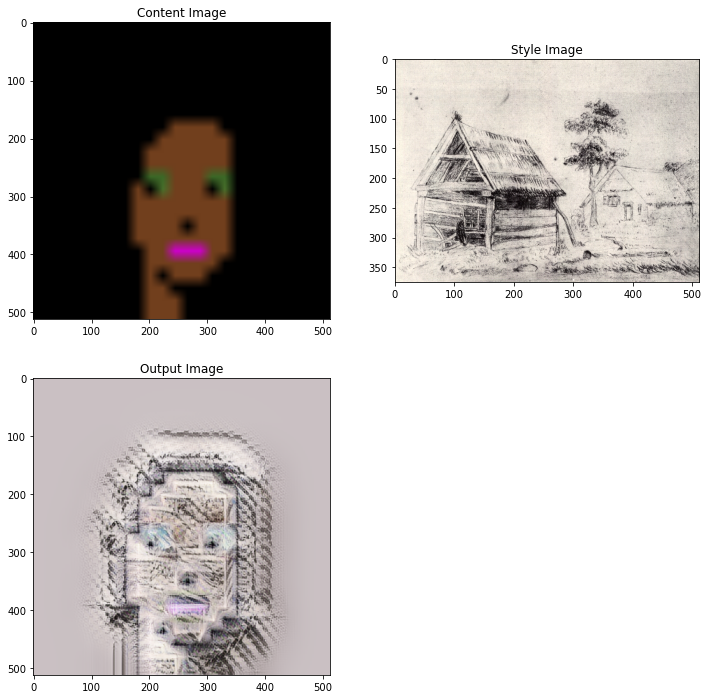

In [28]:
artist = 'vincent-van-gogh'
content_paths = list(sorted(str(path) for path in Path(f'{CONTENTS_PATH}/cryptopunks').glob('*.png')))
styles_paths = list(sorted(str(path) for path in Path(f'{STYLES_PATH}/{artist}').glob('*.jpg')))
content_path = str(np.random.choice(content_paths))
style_path = str(np.random.choice(styles_paths))

artist_output_path = f'{OUTPUTS_PATH}/{artist}-punks'
if not os.path.exists(artist_output_path):
    os.makedirs(artist_output_path)


content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(2, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(2, 2, 2)
imshow(style_image, 'Style Image')

stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
output_file_name = content_path.split('/')[-1].replace('.png', '') + '-' + style_path.split('/')[-1].replace('.jpg', '') + '.png'
output_path = f'{artist_output_path}/{output_file_name}'
tensor_to_image(stylized_image).save(output_path)

output_image = load_img(output_path)
plt.subplot(2, 2, 3)
imshow(output_image, 'Output Image')


## Fast Style Transfer using TF-Hub

This tutorial demonstrates the original style-transfer algorithm, which optimizes the image content to a particular style. Before getting into the details, let's see how the [TensorFlow Hub model](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) does this:

In [32]:
content_paths = list(sorted(str(path) for path in Path(f'{CONTENTS_PATH}/cryptopunks').glob('*.png')))
PINATA_JWT = os.environ.get("PINATA_JWT")
PINATA_BASE_URL = os.environ.get("PINATA_BASE_URL")

def pinata_headers():
    return {"Authorization": f"Bearer {PINATA_JWT}"}

def create_nft_metadata(artist, content, style):
    artist_lower = ' '.join([chunk[0].lower() + chunk[1:] for chunk in artist.split('-')])
    return {
      "name": "Divinity - DevNet",
      "symbol": "DIV",
      "description": "You will probably want to check out https:// solcypher.com to win prizes or thank the creators of this doc.",
      "seller_fee_basis_points": 700, 
      "image": "https://arweave.net/Umi1tOw4hIPn8VkJtq_fjamMgT-YCOGa55g22t6sT6M?ext=jpg", 
      "attributes": [
        {
          "trait_type": "artist",
          "value": artist_lower
        },
        {
          "trait_type": "style",
          "value": style_url
        },
        {
          "trait_type": "content",
          "value": punk_url
        },
        {
          "trait_type": "name",
          "value": punk
        }
      ],
      "collection": {
        "name": "Picasso Punks",
        "family": "ArtistPunks"
      },
      "properties": {
        "files": [ 
          {
            "uri": "https://oabackuplocationofyourfile.jpg",
            "type": "image/jpg"
          }
        ],
        "category": "image",
        "creators": [
          {
            "address": "AvFLeGBFDthzdoct5mHpbUE8ZJdYD4oZXpksoRiws8AG",
            "share": 100
          }
        ]
      }
    }

async def upload_file_to_pinata(session: aiohttp.ClientSession, path: str):
    url = f'{PINATA_BASE_URL}/pinning/pinFileToIPFS'
    form = aiohttp.FormData()
    form.add_field('file', open(path, 'rb'))
    response = await session.post(url, data=form)
    json_response = await response.json()
    return json_response

# async def upload_json_to_pinata(session: aiohttp, path: str):
#     url = f'{PINATA_BASE_URL}/pinning/pinJSONToIPFS'
#     form.add_field('file', open(path, 'rb'))
#     response = await session.post(, data=form)
#     json_response = await response.json()
#     return json_response

async def create_artist_punks(artist):
    artist_lower = ' '.join([chunk[0].lower() + chunk[1:] for chunk in artist.split('-')])
    artist_upper = ' '.join([chunk[0].upper() + chunk[1:] for chunk in artist.split('-')])
    output_paths = defaultdict(list)
    artist_styles_paths = list(sorted(str(path) for path in Path(f'{STYLES_PATH}/{artist}').glob('*.jpg')))
    artist_output_path = f'{OUTPUTS_PATH}/{artist}-punks'
    if not os.path.exists(artist_output_path):
        os.makedirs(artist_output_path)
    punk = content_path.split('/')[-1].replace('.png', '')
    punk_url = f'https://www.larvalabs.com/public/images/cryptopunks/{punk}.png'
    style_path = str(np.random.choice(artist_styles_paths))
    style = style_path.split('/')[-1].replace('.png', '').replace('.jpg', '').replace('.jpeg', '')
    style_url = f'https://up``ncent-van-gogh/{style}.jpg'
    output_file_name = f'{punk}.png'
    punk_path = f'{artist_output_path}/{punk}'
    if not os.path.exists(punk_path):
        os.makedirs(punk_path)
    output_path = f'{punk_path}/{output_file_name}'
    output_json_path = f'{punk_path}/{output_file_name.replace(".png", ".json")}'
    try:
        content_image = load_img(str(content_path))
        style_image = load_img(style_path)
        stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
        tensor_to_image(stylized_image).save(output_path)
        headers = pinata_headers()
        async with aiohttp.ClientSession(headers=headers) as session:
            json_response = await upload_to_pinata(session, output_path)
            print(json_response)
        ipfs_hash = json_response['IpfsHash']
        output_json = {
            "attributes": [
                {
                  "trait_type": "artist",
                  "value": artist_lower
                },
                {
                  "trait_type": "style",
                  "value": style_url
                },
                {
                  "trait_type": "content",
                  "value": punk_url
                },
                {
                  "trait_type": "name",
                  "value": punk
                }
            ],
            "description": f'cryptopunk {punk} in the style of {style} by artist {artist_lower}',
            "image": f"https://gateway.pinata.cloud/ipfs/{ipfs_hash}",
            "name": punk
        }
        print(json.dumps(output_json, indent=4, sort_keys=True))
        with open(output_json_path, 'w') as output_json_file:
            json.dump(output_json, output_json_file, indent=4, sort_keys=True)
        async with aiohttp.ClientSession(headers=headers) as session:
            json_response = await upload_to_pinata(session, output_json_path)
            print(json_response)
        output_paths[artist].append((content_path, style_path, output_path, output_json_path, True))
    except Exception as e:
        print('e =', e)
        output_paths[artist].append((content_path, style_path, output_path, output_json_path, False))
    return output_paths
            

In [33]:
output_paths = await create_artist_punks('vincent-van-gogh')

{'IpfsHash': 'QmYxV8NNw2iba8pGjy8P81zq2LvpGq8Nkj2qJTdnkVgunM', 'PinSize': 501060, 'Timestamp': '2021-11-21T04:53:06.087Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/scheveningen-woman-sewing-2-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0000.png"
        },
        {
            "trait_type": "name",
            "value": "punk0000"
        }
    ],
    "description": "cryptopunk punk0000 in the style of scheveningen-woman-sewing-2-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmYxV8NNw2iba8pGjy8P81zq2LvpGq8Nkj2qJTdnkVgunM",
    "name": "punk0000"
}
{'IpfsHash': 'QmQbmyod22WDLuXX4UYeunxruFZdvwMTj1Udcyy9aA1Prv', 'PinSize': 777, 'Timestamp': '2021-11-21T04:53:

{'IpfsHash': 'QmYkVJGPrnTv9L1F3J1SgXdjRF2eSZDHKX1K3DjQoZ3Rca', 'PinSize': 801, 'Timestamp': '2021-11-21T04:53:30.799Z'}
{'IpfsHash': 'QmW9qRckqjMmXE6AM8k3jiF4zzvirDqmcgEdSDVHVATrYQ', 'PinSize': 416107, 'Timestamp': '2021-11-21T04:53:32.863Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/old-man-with-a-stick-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0009.png"
        },
        {
            "trait_type": "name",
            "value": "punk0009"
        }
    ],
    "description": "cryptopunk punk0009 in the style of old-man-with-a-stick-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmW9qRckqjMmXE6AM8k3jiF4zzvirDqmcgEdSDVHVATrYQ",
    "name": "punk0009"
}
{'Ip

{'IpfsHash': 'QmVQENbo2cQJEv6rpCqj43g3P6WizGKqPi2Aa5RP72FwpU', 'PinSize': 335988, 'Timestamp': '2021-11-21T04:54:02.242Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/woman-churning-butter-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0017.png"
        },
        {
            "trait_type": "name",
            "value": "punk0017"
        }
    ],
    "description": "cryptopunk punk0017 in the style of woman-churning-butter-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmVQENbo2cQJEv6rpCqj43g3P6WizGKqPi2Aa5RP72FwpU",
    "name": "punk0017"
}
{'IpfsHash': 'QmSQ61dPuCxd1sZ2rgE14tZDGfkRHEM4jXxswDnA9UAjyz', 'PinSize': 765, 'Timestamp': '2021-11-21T04:54:05.579Z'}
{'

{'IpfsHash': 'QmdvE2CJPcAjvsxbgb48wV3hnbtrPTAr9GfUpZ7mHuEGcJ', 'PinSize': 807, 'Timestamp': '2021-11-21T04:54:28.479Z'}
{'IpfsHash': 'QmQpmu6nFMSWtxzyxsSRBq5vVSXXvKBNHzxgFNHaPW5Y4Z', 'PinSize': 304052, 'Timestamp': '2021-11-21T04:54:30.358Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/windmils-at-dordrecht-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0026.png"
        },
        {
            "trait_type": "name",
            "value": "punk0026"
        }
    ],
    "description": "cryptopunk punk0026 in the style of windmils-at-dordrecht-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmQpmu6nFMSWtxzyxsSRBq5vVSXXvKBNHzxgFNHaPW5Y4Z",
    "name": "punk0026"
}
{'

{'IpfsHash': 'QmYDW14gzbuas8mJfrWaE4kuab4PRgkfyoorakC4UBtJJV', 'PinSize': 291797, 'Timestamp': '2021-11-21T04:54:50.895Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/country-lane-with-trees-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0034.png"
        },
        {
            "trait_type": "name",
            "value": "punk0034"
        }
    ],
    "description": "cryptopunk punk0034 in the style of country-lane-with-trees-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmYDW14gzbuas8mJfrWaE4kuab4PRgkfyoorakC4UBtJJV",
    "name": "punk0034"
}
{'IpfsHash': 'Qmbs3pCDzFDoerrKaCqshahhqJ1Q453jG46MS692FHjhcp', 'PinSize': 775, 'Timestamp': '2021-11-21T04:54:51

{'IpfsHash': 'QmcA7rDqr8bo5G7WV1G5svR8DJdJz4qzKHKaNzyw1t2Stx', 'PinSize': 735, 'Timestamp': '2021-11-21T04:55:16.205Z'}
{'IpfsHash': 'QmcmJK7FPkRdFA87tpqDfhCG9B4Mf8qjNeb62kbE6SCW2r', 'PinSize': 287759, 'Timestamp': '2021-11-21T04:55:19.391Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/meadows-near-rijswijk-and-the-schenkweg-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0043.png"
        },
        {
            "trait_type": "name",
            "value": "punk0043"
        }
    ],
    "description": "cryptopunk punk0043 in the style of meadows-near-rijswijk-and-the-schenkweg-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmcmJK7FPkRdFA87tpqDfhCG9B4Mf8qjNeb62kbE

{'IpfsHash': 'QmXdvxmkzM47pbknA91rtKx4WCCrcZGw9yGecbKTTgx392', 'PinSize': 347742, 'Timestamp': '2021-11-21T04:55:43.272Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/vicarage-and-church-at-etten-1876.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0051.png"
        },
        {
            "trait_type": "name",
            "value": "punk0051"
        }
    ],
    "description": "cryptopunk punk0051 in the style of vicarage-and-church-at-etten-1876 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmXdvxmkzM47pbknA91rtKx4WCCrcZGw9yGecbKTTgx392",
    "name": "punk0051"
}
{'IpfsHash': 'QmQnv1wbAo67DTwMWpg4ru35yjPFRHQyxKdjjFLsfXr4d9', 'PinSize': 779, 'Timestamp': '2021-11-21T04:5

{'IpfsHash': 'QmbgSbmc6ZekDoauaFnQK5YoG8GUdKHTLWmKmKx27pTHqU', 'PinSize': 763, 'Timestamp': '2021-11-21T04:56:06.957Z'}
{'IpfsHash': 'Qmb8hpkam9S53PRedux5GCRfh1bHaTBHrVXfP79sPpQy8S', 'PinSize': 264151, 'Timestamp': '2021-11-21T04:56:09.064Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/still-life-with-cabbage-and-clogs-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0060.png"
        },
        {
            "trait_type": "name",
            "value": "punk0060"
        }
    ],
    "description": "cryptopunk punk0060 in the style of still-life-with-cabbage-and-clogs-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qmb8hpkam9S53PRedux5GCRfh1bHaTBHrVXfP79sPpQy8S",
   

{'IpfsHash': 'QmehXE4Sc4FAqSKBQi3pLCPRp1PyFXFnyJepQqvncmQQLG', 'PinSize': 799, 'Timestamp': '2021-11-21T04:56:32.736Z'}
{'IpfsHash': 'QmPY3NNwg47fCntE3Q93zUK9sHvcCBAvKPrYuD3sZnBmTy', 'PinSize': 393970, 'Timestamp': '2021-11-21T04:56:35.065Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/woman-sitting-at-the-fireside-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0069.png"
        },
        {
            "trait_type": "name",
            "value": "punk0069"
        }
    ],
    "description": "cryptopunk punk0069 in the style of woman-sitting-at-the-fireside-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmPY3NNwg47fCntE3Q93zUK9sHvcCBAvKPrYuD3sZnBmTy",
    "name":

{'IpfsHash': 'Qmc52xqjFaVSfr6VD31zBZw4kyqYKi7tg3E6WKfwG7ytYF', 'PinSize': 383919, 'Timestamp': '2021-11-21T04:56:58.866Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/barn-and-farmhouse(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0077.png"
        },
        {
            "trait_type": "name",
            "value": "punk0077"
        }
    ],
    "description": "cryptopunk punk0077 in the style of barn-and-farmhouse(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qmc52xqjFaVSfr6VD31zBZw4kyqYKi7tg3E6WKfwG7ytYF",
    "name": "punk0077"
}
{'IpfsHash': 'QmRn6JmKbA3ni2Bgd13VkdfpoyragwFYjmaQGjkWmjhEHZ', 'PinSize': 755, 'Timestamp': '2021-11-21T04:56:59.422Z'}
{'IpfsHash':

{'IpfsHash': 'QmRs4CTPD4riDmw9ndBo8HgzQBpDXSjuHnJYAEb8RSBD3o', 'PinSize': 757, 'Timestamp': '2021-11-21T04:57:20.339Z'}
{'IpfsHash': 'QmV3jFkgeDvxWiW5j3915KNZpkME1X4b8yda5WFtUr3EBi', 'PinSize': 345399, 'Timestamp': '2021-11-21T04:57:23.077Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/woman-sitting-on-a-basket-with-head-in-hands.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0086.png"
        },
        {
            "trait_type": "name",
            "value": "punk0086"
        }
    ],
    "description": "cryptopunk punk0086 in the style of woman-sitting-on-a-basket-with-head-in-hands by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmV3jFkgeDvxWiW5j3915KNZpkME1X4b8yda5WFt

{'IpfsHash': 'QmYD7UQRvXoit8TgjKYrXWjTPXkCCh1jLApCWAAfEAjBZk', 'PinSize': 342896, 'Timestamp': '2021-11-21T04:57:44.613Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/sower-with-hand-in-sack-1881-1.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0094.png"
        },
        {
            "trait_type": "name",
            "value": "punk0094"
        }
    ],
    "description": "cryptopunk punk0094 in the style of sower-with-hand-in-sack-1881-1 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmYD7UQRvXoit8TgjKYrXWjTPXkCCh1jLApCWAAfEAjBZk",
    "name": "punk0094"
}
{'IpfsHash': 'QmSMFQA5ZafwX99rqds9HUP6cQEDYneKo3bT866BmjZnyF', 'PinSize': 773, 'Timestamp': '2021-11-21T04:57:45.1

{'IpfsHash': 'QmWR4hsYaKBsdThLK3gN183iWbGPJqvKZX7r4XFjEh23JW', 'PinSize': 825, 'Timestamp': '2021-11-21T04:58:09.870Z'}
{'IpfsHash': 'QmTz2mLMZLjr5LqGsx6tXsVK4g262ievsX8NShg9tXwLpu', 'PinSize': 401496, 'Timestamp': '2021-11-21T04:58:12.368Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/woman-churning-butter-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0103.png"
        },
        {
            "trait_type": "name",
            "value": "punk0103"
        }
    ],
    "description": "cryptopunk punk0103 in the style of woman-churning-butter-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmTz2mLMZLjr5LqGsx6tXsVK4g262ievsX8NShg9tXwLpu",
    "name": "punk0103"
}
{'

{'IpfsHash': 'QmNe8NjBP6qihRQojFEEz6jVPq1JnA7b9qvELnps9UGM3n', 'PinSize': 775, 'Timestamp': '2021-11-21T04:58:39.783Z'}
{'IpfsHash': 'QmUZCqDeTHG5ZcvYAu5iV5nf9qBZgh9qY6oot1ztN7HPeH', 'PinSize': 442969, 'Timestamp': '2021-11-21T04:58:41.997Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/entrance-to-the-pawn-bank-the-hague-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0112.png"
        },
        {
            "trait_type": "name",
            "value": "punk0112"
        }
    ],
    "description": "cryptopunk punk0112 in the style of entrance-to-the-pawn-bank-the-hague-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmUZCqDeTHG5ZcvYAu5iV5nf9qBZgh9qY6oot1ztN7

{'IpfsHash': 'QmTUXi3sFmY797YDPJns33LwaLERNR9kkqextj19TjhhgV', 'PinSize': 725, 'Timestamp': '2021-11-21T04:59:09.180Z'}
{'IpfsHash': 'Qmag51XRUXMjTBPtKiAbpYrVwmcbC12fd7NSP5Q9GTnGuW', 'PinSize': 300185, 'Timestamp': '2021-11-21T04:59:11.566Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/old-woman-with-a-shawl-and-a-walking-stick-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0121.png"
        },
        {
            "trait_type": "name",
            "value": "punk0121"
        }
    ],
    "description": "cryptopunk punk0121 in the style of old-woman-with-a-shawl-and-a-walking-stick-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qmag51XRUXMjTBPtKiAbpYrVwmcbC12fd7

{'IpfsHash': 'QmSqyFNaQbkd8DvgCTMWuAo5R4rstEy8cTPhcQKkFkVNeA', 'PinSize': 427279, 'Timestamp': '2021-11-21T04:59:35.382Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/man-standing-with-arms-folded-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0129.png"
        },
        {
            "trait_type": "name",
            "value": "punk0129"
        }
    ],
    "description": "cryptopunk punk0129 in the style of man-standing-with-arms-folded-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmSqyFNaQbkd8DvgCTMWuAo5R4rstEy8cTPhcQKkFkVNeA",
    "name": "punk0129"
}
{'IpfsHash': 'QmNrjXgD42k5u9tueQHS7LttVmqacrCkq4pPwxPDemLZCp', 'PinSize': 781, 'Timestamp': '2021-11-21T04

{'IpfsHash': 'QmUXRePGeWupD5ULJmUxN5uvk3NJuysSLR1W1A4RgQobHf', 'PinSize': 745, 'Timestamp': '2021-11-21T04:59:57.121Z'}
{'IpfsHash': 'QmaAhELMxti2ehYa4vEDDukeouTv1W7SPDZEyQHqBhB91v', 'PinSize': 426016, 'Timestamp': '2021-11-21T04:59:59.182Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/head-of-a-woman-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0138.png"
        },
        {
            "trait_type": "name",
            "value": "punk0138"
        }
    ],
    "description": "cryptopunk punk0138 in the style of head-of-a-woman-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmaAhELMxti2ehYa4vEDDukeouTv1W7SPDZEyQHqBhB91v",
    "name": "punk0138"
}
{'IpfsHash': '

{'IpfsHash': 'QmWnnk33b59mniVS9RxfTZo7Vk25eaqUkSXdxiFeRi7Fdp', 'PinSize': 745, 'Timestamp': '2021-11-21T05:00:20.901Z'}
{'IpfsHash': 'QmQjNM1wo4G7euysJzvUUgiFZPMuBNpRKWMnSKTi55irsK', 'PinSize': 280910, 'Timestamp': '2021-11-21T05:00:23.262Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/view-of-royal-road-ramsgate-1876.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0147.png"
        },
        {
            "trait_type": "name",
            "value": "punk0147"
        }
    ],
    "description": "cryptopunk punk0147 in the style of view-of-royal-road-ramsgate-1876 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmQjNM1wo4G7euysJzvUUgiFZPMuBNpRKWMnSKTi55irsK",
    "name": "pu

{'IpfsHash': 'QmdUJP1eSGZjF4wmAJAJb8gW6kr8mN2Ve8Tnx1HpX7Z9jo', 'PinSize': 807, 'Timestamp': '2021-11-21T05:00:45.683Z'}
{'IpfsHash': 'QmVuoEG17hvHtDCeeVXF5SBUZRPSCaUAiZFD7ubBt3TFPy', 'PinSize': 424726, 'Timestamp': '2021-11-21T05:00:47.884Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/sower-after-millet-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0156.png"
        },
        {
            "trait_type": "name",
            "value": "punk0156"
        }
    ],
    "description": "cryptopunk punk0156 in the style of sower-after-millet-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmVuoEG17hvHtDCeeVXF5SBUZRPSCaUAiZFD7ubBt3TFPy",
    "name": "punk0156"
}
{'IpfsHa

{'IpfsHash': 'QmVjVdfYnm764scP5ZWDh4YRFKnNuRLmUCXJmTue15j4tQ', 'PinSize': 359283, 'Timestamp': '2021-11-21T05:01:10.724Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/peasant-with-a-chopping-knife-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0164.png"
        },
        {
            "trait_type": "name",
            "value": "punk0164"
        }
    ],
    "description": "cryptopunk punk0164 in the style of peasant-with-a-chopping-knife-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmVjVdfYnm764scP5ZWDh4YRFKnNuRLmUCXJmTue15j4tQ",
    "name": "punk0164"
}
{'IpfsHash': 'QmUShTdANZ88iwzBXuDUy4wW3zMgV1VU4pozXNnvWp23M3', 'PinSize': 781, 'Timestamp': '2021-11-21T05

{'IpfsHash': 'QmbZF163wg68wPZM18qoPfDKpXcYxZs7qtPy7TyK6n1jqX', 'PinSize': 755, 'Timestamp': '2021-11-21T05:01:34.301Z'}
{'IpfsHash': 'QmatFi8oEzYNyb9XokshhzDJRgykxsgoWByphpj84PvBth', 'PinSize': 372450, 'Timestamp': '2021-11-21T05:01:36.707Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/milk-jug.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0173.png"
        },
        {
            "trait_type": "name",
            "value": "punk0173"
        }
    ],
    "description": "cryptopunk punk0173 in the style of milk-jug by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmatFi8oEzYNyb9XokshhzDJRgykxsgoWByphpj84PvBth",
    "name": "punk0173"
}
{'IpfsHash': 'QmZ72T4VzVwVd7t7U8qAdS2B

{'IpfsHash': 'QmX9wv7vTAo2hHHYqDJZm2SVr12ud9m1xm1bhWpX2dwKQj', 'PinSize': 787, 'Timestamp': '2021-11-21T05:02:01.585Z'}
{'IpfsHash': 'Qmbyo8gLQtzr8pT2k9Xp46baTVM1czz4Vo1oidmgHXdH3n', 'PinSize': 333322, 'Timestamp': '2021-11-21T05:02:03.679Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/miners-wives-carrying-sacks-of-coal-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0182.png"
        },
        {
            "trait_type": "name",
            "value": "punk0182"
        }
    ],
    "description": "cryptopunk punk0182 in the style of miners-wives-carrying-sacks-of-coal-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qmbyo8gLQtzr8pT2k9Xp46baTVM1czz4Vo1oidmgHXdH3n",

{'IpfsHash': 'QmS9dCw3GKHy5YrT2p3yRXXYyj4mU9T2onWyfM6ZatpUsV', 'PinSize': 313367, 'Timestamp': '2021-11-21T05:02:25.409Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/coalmine-in-the-borinage-1879(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0190.png"
        },
        {
            "trait_type": "name",
            "value": "punk0190"
        }
    ],
    "description": "cryptopunk punk0190 in the style of coalmine-in-the-borinage-1879(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmS9dCw3GKHy5YrT2p3yRXXYyj4mU9T2onWyfM6ZatpUsV",
    "name": "punk0190"
}
{'IpfsHash': 'QmTq6FqotzikZJP7hE9hzDaHhhKKaacPaaopp2pN4NCeZo', 'PinSize': 777, 'Timestamp': '2021-11-21T05:02:

{'IpfsHash': 'QmbE4MZA8DyitqQWS6MeahaCvcT38k9nwFdUNr4z7AjxYE', 'PinSize': 771, 'Timestamp': '2021-11-21T05:02:49.452Z'}
{'IpfsHash': 'QmSeTjmZb1rqfrZJXRR3vmo5fyGCh6pqU2AQBsVTn2C78H', 'PinSize': 376182, 'Timestamp': '2021-11-21T05:02:54.118Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/a-girl-raking-1881(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0199.png"
        },
        {
            "trait_type": "name",
            "value": "punk0199"
        }
    ],
    "description": "cryptopunk punk0199 in the style of a-girl-raking-1881(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmSeTjmZb1rqfrZJXRR3vmo5fyGCh6pqU2AQBsVTn2C78H",
    "name": "punk0199"
}
{'IpfsHash':

{'IpfsHash': 'QmZoP6uCADUEGtwS4Rn6BeZjsigfqTYJ6XnXjApVwqKUuC', 'PinSize': 803, 'Timestamp': '2021-11-21T05:03:19.165Z'}
{'IpfsHash': 'QmVv9wLwBoHLUoi6gtDPSp85ao1h8D87vJnEWAMQbN3Rvx', 'PinSize': 343021, 'Timestamp': '2021-11-21T05:03:21.239Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/field-with-thunderstorm-1881(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0208.png"
        },
        {
            "trait_type": "name",
            "value": "punk0208"
        }
    ],
    "description": "cryptopunk punk0208 in the style of field-with-thunderstorm-1881(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmVv9wLwBoHLUoi6gtDPSp85ao1h8D87vJnEWAMQbN3Rvx",
    "name": "punk

{'IpfsHash': 'QmP1z7uHVfkE4BAebhhk9NyapiyWrXh8bLNXnbeHToWUnQ', 'PinSize': 737, 'Timestamp': '2021-11-21T05:03:43.426Z'}
{'IpfsHash': 'QmSkLSNybZp6TDF4A3fdox1bjaDjU6zcjcjixtq1YiTe76', 'PinSize': 426182, 'Timestamp': '2021-11-21T05:03:45.483Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/sculpture-and-still-life-with-cabbage-and-clogs-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0217.png"
        },
        {
            "trait_type": "name",
            "value": "punk0217"
        }
    ],
    "description": "cryptopunk punk0217 in the style of sculpture-and-still-life-with-cabbage-and-clogs-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmSkLSNybZp6TDF4A3fdox1b

{'IpfsHash': 'QmV4EN4dRN4sKc2LFojYN6ua5DFaLhRBBz6xGjS9xPrp38', 'PinSize': 366242, 'Timestamp': '2021-11-21T05:04:06.673Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/woman-near-a-window-twice-man-with-winnow-sower-and-woman-with-broom.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0225.png"
        },
        {
            "trait_type": "name",
            "value": "punk0225"
        }
    ],
    "description": "cryptopunk punk0225 in the style of woman-near-a-window-twice-man-with-winnow-sower-and-woman-with-broom by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmV4EN4dRN4sKc2LFojYN6ua5DFaLhRBBz6xGjS9xPrp38",
    "name": "punk0225"
}
{'IpfsHash': 'QmbVMzaGM593NyzquUbzewoy

{'IpfsHash': 'QmTR8w1tNpjK8umgsWDhCzYYd1xad71KRxPYWRPPsGaVPi', 'PinSize': 801, 'Timestamp': '2021-11-21T05:04:33.972Z'}
{'IpfsHash': 'QmVRto5m983zfzbbwoEm9xZZPEjrqV35QS2u76sQN5smZu', 'PinSize': 422440, 'Timestamp': '2021-11-21T05:04:36.069Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/iron-mill-in-the-hague-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0234.png"
        },
        {
            "trait_type": "name",
            "value": "punk0234"
        }
    ],
    "description": "cryptopunk punk0234 in the style of iron-mill-in-the-hague-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmVRto5m983zfzbbwoEm9xZZPEjrqV35QS2u76sQN5smZu",
    "name": "punk0234"
}


{'IpfsHash': 'QmR1rR35cFoPkVz63RwzqwUwWUnzNfEqjFfzSZUCRcQvDH', 'PinSize': 370634, 'Timestamp': '2021-11-21T05:05:07.582Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/dunes-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0242.png"
        },
        {
            "trait_type": "name",
            "value": "punk0242"
        }
    ],
    "description": "cryptopunk punk0242 in the style of dunes-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmR1rR35cFoPkVz63RwzqwUwWUnzNfEqjFfzSZUCRcQvDH",
    "name": "punk0242"
}
{'IpfsHash': 'QmSzVGCNq1pv134neorR94XSjZSPpj67GeHhayW7pnY34L', 'PinSize': 739, 'Timestamp': '2021-11-21T05:05:08.250Z'}
{'IpfsHash': 'QmNhVNWfjjHD27

{'IpfsHash': 'Qmdzb8aqdDZA7UFCzGPZ1CQBecnhPpiNZgPkWmZ5vEnVvD', 'PinSize': 787, 'Timestamp': '2021-11-21T05:05:31.163Z'}
{'IpfsHash': 'QmZdEnpRH4bqeSfTuAziLBHsuoEPzxVthG33bBSKtY1JKR', 'PinSize': 266583, 'Timestamp': '2021-11-21T05:05:33.583Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/a-carpenter-with-apron-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0251.png"
        },
        {
            "trait_type": "name",
            "value": "punk0251"
        }
    ],
    "description": "cryptopunk punk0251 in the style of a-carpenter-with-apron-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmZdEnpRH4bqeSfTuAziLBHsuoEPzxVthG33bBSKtY1JKR",
    "name": "punk02

{'IpfsHash': 'QmaJjJ2BMHdX5KPGGsYjYhcQycygKz45AcGCmY5Bvfxigp', 'PinSize': 745, 'Timestamp': '2021-11-21T05:05:58.693Z'}
{'IpfsHash': 'QmXjSgQWmXmH4AKPBHeUUQsgFTw2vPY5AokxQzVSwBKCM4', 'PinSize': 475640, 'Timestamp': '2021-11-21T05:06:01.459Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/miners-1880.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0260.png"
        },
        {
            "trait_type": "name",
            "value": "punk0260"
        }
    ],
    "description": "cryptopunk punk0260 in the style of miners-1880 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmXjSgQWmXmH4AKPBHeUUQsgFTw2vPY5AokxQzVSwBKCM4",
    "name": "punk0260"
}
{'IpfsHash': 'QmPUopckkKfWYg2oFm

{'IpfsHash': 'QmWCfN8h72WkMrMQzMLXdFyGDk29k5cqogJQqwcrGE7LCy', 'PinSize': 435426, 'Timestamp': '2021-11-21T05:06:28.528Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/the-garden-of-the-parsonage-with-arbor-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0268.png"
        },
        {
            "trait_type": "name",
            "value": "punk0268"
        }
    ],
    "description": "cryptopunk punk0268 in the style of the-garden-of-the-parsonage-with-arbor-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmWCfN8h72WkMrMQzMLXdFyGDk29k5cqogJQqwcrGE7LCy",
    "name": "punk0268"
}
{'IpfsHash': 'QmTEXRgicFzEJRczhybCPpM8MSD8fU7xS38Ao1L45rvTJ2', 'PinSize': 799, 'Timestam

{'IpfsHash': 'QmVZv6yj6byfMM9K9Aca2pr9okjKXJYgsRqu61nqpMxZfi', 'PinSize': 765, 'Timestamp': '2021-11-21T05:06:51.026Z'}
{'IpfsHash': 'QmXz1U6HcFx4iADr8ugq2AnJJjmSpM7UkwY4Aq3kqrXZuZ', 'PinSize': 369514, 'Timestamp': '2021-11-21T05:06:53.086Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/diggers-in-torn-up-street-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0277.png"
        },
        {
            "trait_type": "name",
            "value": "punk0277"
        }
    ],
    "description": "cryptopunk punk0277 in the style of diggers-in-torn-up-street-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmXz1U6HcFx4iADr8ugq2AnJJjmSpM7UkwY4Aq3kqrXZuZ",
    "name": "

{'IpfsHash': 'QmY1EsNa1gL8Kcajye6tdBfzDA6cHPAkuLnF4cVgaK4W6L', 'PinSize': 336635, 'Timestamp': '2021-11-21T05:07:14.050Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/miners-women-carrying-sacks-the-bearers-of-the-burden-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0285.png"
        },
        {
            "trait_type": "name",
            "value": "punk0285"
        }
    ],
    "description": "cryptopunk punk0285 in the style of miners-women-carrying-sacks-the-bearers-of-the-burden-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmY1EsNa1gL8Kcajye6tdBfzDA6cHPAkuLnF4cVgaK4W6L",
    "name": "punk0285"
}
{'IpfsHash': 'QmaSSj5LNxbUY6xfx64aTqLYt727n8TepukCf5ygS5d7

{'IpfsHash': 'QmTQodERmHgYSSVxM17JGmzysmWNwjzFTc4Ud4Kfp3QWha', 'PinSize': 787, 'Timestamp': '2021-11-21T05:07:35.442Z'}
{'IpfsHash': 'QmYTeWVb9fGf88mhUWFo19nAzpQPkTzcD7CAxZwbFRh2nD', 'PinSize': 477932, 'Timestamp': '2021-11-21T05:07:37.477Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/group-of-people-on-the-beach-with-fishing-boat-arriving-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0294.png"
        },
        {
            "trait_type": "name",
            "value": "punk0294"
        }
    ],
    "description": "cryptopunk punk0294 in the style of group-of-people-on-the-beach-with-fishing-boat-arriving-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qm

{'IpfsHash': 'QmTTfxnN47fN92yQ9DdMjnDpwbUZEVbEsMvEqUocCLXvrA', 'PinSize': 408458, 'Timestamp': '2021-11-21T05:07:59.321Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/dog(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0302.png"
        },
        {
            "trait_type": "name",
            "value": "punk0302"
        }
    ],
    "description": "cryptopunk punk0302 in the style of dog(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmTTfxnN47fN92yQ9DdMjnDpwbUZEVbEsMvEqUocCLXvrA",
    "name": "punk0302"
}
{'IpfsHash': 'QmTg9FBr5KhzqTmfaeWKfjr22Uzfm2SXuKDjjFbfnDYdGN', 'PinSize': 725, 'Timestamp': '2021-11-21T05:07:59.866Z'}
{'IpfsHash': 'QmYBkBfDwZFvnZz34ZhXGuyMu32n

{'IpfsHash': 'QmX9NqgHmbP66ogG63oKQHoQawmX9aPGdvkySbinuoHetv', 'PinSize': 755, 'Timestamp': '2021-11-21T05:08:21.153Z'}
{'IpfsHash': 'QmPfPz4Dk8GmzqYJBfGqdjihwjjdRdt8rETX2BQFsDr1QS', 'PinSize': 324933, 'Timestamp': '2021-11-21T05:08:23.294Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/miners-in-the-snow-winter-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0311.png"
        },
        {
            "trait_type": "name",
            "value": "punk0311"
        }
    ],
    "description": "cryptopunk punk0311 in the style of miners-in-the-snow-winter-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmPfPz4Dk8GmzqYJBfGqdjihwjjdRdt8rETX2BQFsDr1QS",
    "name": "punk03

{'IpfsHash': 'QmWRYyJFUC7zhTbUgk1Rxa8qWw3uTZ4YFVLmv7ZzNfCZkM', 'PinSize': 273111, 'Timestamp': '2021-11-21T05:08:45.014Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/church-pew-with-worshippers-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0319.png"
        },
        {
            "trait_type": "name",
            "value": "punk0319"
        }
    ],
    "description": "cryptopunk punk0319 in the style of church-pew-with-worshippers-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmWRYyJFUC7zhTbUgk1Rxa8qWw3uTZ4YFVLmv7ZzNfCZkM",
    "name": "punk0319"
}
{'IpfsHash': 'QmejEv6jvCC1Ysgm94pL6yC9UDS6zSuwsK4gfF9pvWkTDX', 'PinSize': 783, 'Timestamp': '2021-11-21T

{'IpfsHash': 'Qmcx7y9vxMBs2nqGz4Y8HkQbyV8nuE1Bwj8LmZzrjqYTwr', 'PinSize': 829, 'Timestamp': '2021-11-21T05:09:05.929Z'}
{'IpfsHash': 'QmeHyj9R8F33PSuCfenbaXipJA2vtoRvwVk2PX2x6FZQm6', 'PinSize': 400598, 'Timestamp': '2021-11-21T05:09:07.948Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/beach-and-boats-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0328.png"
        },
        {
            "trait_type": "name",
            "value": "punk0328"
        }
    ],
    "description": "cryptopunk punk0328 in the style of beach-and-boats-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmeHyj9R8F33PSuCfenbaXipJA2vtoRvwVk2PX2x6FZQm6",
    "name": "punk0328"
}
{'IpfsHa

{'IpfsHash': 'QmTH7uXdJPux15wPsskjYeQNo7EHnRSEgjP5UDYnQWwkvu', 'PinSize': 422535, 'Timestamp': '2021-11-21T05:09:27.841Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/peasant-sitting-by-the-fireplace-worn-out-1881-1.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0336.png"
        },
        {
            "trait_type": "name",
            "value": "punk0336"
        }
    ],
    "description": "cryptopunk punk0336 in the style of peasant-sitting-by-the-fireplace-worn-out-1881-1 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmTH7uXdJPux15wPsskjYeQNo7EHnRSEgjP5UDYnQWwkvu",
    "name": "punk0336"
}
{'IpfsHash': 'Qme2K9ZKKEB1aMuuSpLVyPtW6CDGinQ4gqaQhze7i88sny', 'PinSize': 809,

{'IpfsHash': 'QmNgkgQJ4nok9fYWFrxfaEex16m5pbFwzFPE7vgxSxmMdJ', 'PinSize': 789, 'Timestamp': '2021-11-21T05:09:50.781Z'}
{'IpfsHash': 'QmfKNBWRX2Uke66QEnrne6cx2ffWa6ZXjgB79DKzdUqc1t', 'PinSize': 397902, 'Timestamp': '2021-11-21T05:09:52.747Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/a-girl-in-a-wood-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0345.png"
        },
        {
            "trait_type": "name",
            "value": "punk0345"
        }
    ],
    "description": "cryptopunk punk0345 in the style of a-girl-in-a-wood-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmfKNBWRX2Uke66QEnrne6cx2ffWa6ZXjgB79DKzdUqc1t",
    "name": "punk0345"
}
{'Ipfs

{'IpfsHash': 'QmfZ2JeUupi8bgcwZnmsVsaLTLbiMBu4sgSnGjJX6FhwqM', 'PinSize': 287529, 'Timestamp': '2021-11-21T05:10:16.109Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/orphan-man-with-cap-and-walking-stick-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0353.png"
        },
        {
            "trait_type": "name",
            "value": "punk0353"
        }
    ],
    "description": "cryptopunk punk0353 in the style of orphan-man-with-cap-and-walking-stick-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmfZ2JeUupi8bgcwZnmsVsaLTLbiMBu4sgSnGjJX6FhwqM",
    "name": "punk0353"
}
{'IpfsHash': 'QmX9WWig2UujfaDpAeCPg2wUMoXEdvKkWUFPYgbdLGm1Va', 'PinSize': 797, 'Timestamp'

{'IpfsHash': 'QmZUMjctcYdnCwJFt47pq4grC5vWmwVhZAVE2K6tp8LpA3', 'PinSize': 759, 'Timestamp': '2021-11-21T05:10:36.926Z'}
{'IpfsHash': 'QmNjN8Qs5Y3UVZw6VH77wTEhNuT6eBPkjJV4kWga99zot2', 'PinSize': 378998, 'Timestamp': '2021-11-21T05:10:38.898Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/an-almshouse-man-in-a-top-hat-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0362.png"
        },
        {
            "trait_type": "name",
            "value": "punk0362"
        }
    ],
    "description": "cryptopunk punk0362 in the style of an-almshouse-man-in-a-top-hat-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmNjN8Qs5Y3UVZw6VH77wTEhNuT6eBPkjJV4kWga99zot2",
    "

{'IpfsHash': 'QmagzHxB41nQ8qQiM55vKYGQVPBq9LiNBKx6seaPR7wxvZ', 'PinSize': 765, 'Timestamp': '2021-11-21T05:10:59.964Z'}
{'IpfsHash': 'QmPeucSYLKcswocqL5N8zkHDgNc4evyPxBURrqQAwRebmm', 'PinSize': 349317, 'Timestamp': '2021-11-21T05:11:01.986Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/canal(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0371.png"
        },
        {
            "trait_type": "name",
            "value": "punk0371"
        }
    ],
    "description": "cryptopunk punk0371 in the style of canal(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmPeucSYLKcswocqL5N8zkHDgNc4evyPxBURrqQAwRebmm",
    "name": "punk0371"
}
{'IpfsHash': 'QmRUGHRWEGpNpqbxvxnpoQXX

{'IpfsHash': 'QmXdJtSGXFUjMKRJNrcjnmfWvDk36TaQUtCY8Bbpb3vBRo', 'PinSize': 743, 'Timestamp': '2021-11-21T05:11:23.101Z'}
{'IpfsHash': 'Qmb5wF2mCua5rEBMzjFRSNBCu2q3saisnA2qT38am2RDVc', 'PinSize': 306051, 'Timestamp': '2021-11-21T05:11:25.328Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/a-digger-1881(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0380.png"
        },
        {
            "trait_type": "name",
            "value": "punk0380"
        }
    ],
    "description": "cryptopunk punk0380 in the style of a-digger-1881(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qmb5wF2mCua5rEBMzjFRSNBCu2q3saisnA2qT38am2RDVc",
    "name": "punk0380"
}
{'IpfsHash': 'QmQQAv7S

{'IpfsHash': 'QmPEatWBTxPrkoZFbK3jA5xxW7TZPcXSXbvhJMygcRABhK', 'PinSize': 767, 'Timestamp': '2021-11-21T05:11:47.386Z'}
{'IpfsHash': 'QmTuQgjhte8vFVa2JzZggPhCQm1V7m1k772DxViSdrTin9', 'PinSize': 331067, 'Timestamp': '2021-11-21T05:11:49.418Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/farmer-sitting-at-the-fireside-and-reading-1881(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0389.png"
        },
        {
            "trait_type": "name",
            "value": "punk0389"
        }
    ],
    "description": "cryptopunk punk0389 in the style of farmer-sitting-at-the-fireside-and-reading-1881(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmTuQgjhte8vFVa2JzZggPhCQm1V

{'IpfsHash': 'QmeT3LkQeLLeEQSnnwr7L4s7VaHHC6BLFSqJgrCBxG5qa1', 'PinSize': 397403, 'Timestamp': '2021-11-21T05:12:12.611Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/bench-with-three-persons-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0397.png"
        },
        {
            "trait_type": "name",
            "value": "punk0397"
        }
    ],
    "description": "cryptopunk punk0397 in the style of bench-with-three-persons-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmeT3LkQeLLeEQSnnwr7L4s7VaHHC6BLFSqJgrCBxG5qa1",
    "name": "punk0397"
}
{'IpfsHash': 'Qmeo3ugCJiqzTtC2ZWoKTUP8BVbdN77yYANsz9nVHzcFZF', 'PinSize': 777, 'Timestamp': '2021-11-21T05:12:

{'IpfsHash': 'QmQBj4G5rNk9gWYgaWuWutxRBAwQ4h1JS7ve8XaeuLhXBx', 'PinSize': 723, 'Timestamp': '2021-11-21T05:12:33.760Z'}
{'IpfsHash': 'QmbzVRewiybqa3p8ReLz1Ybha4Qp2Vo2czaxQXYGsVBoLg', 'PinSize': 404042, 'Timestamp': '2021-11-21T05:12:35.803Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/old-woman-with-a-shawl-and-a-walking-stick-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0406.png"
        },
        {
            "trait_type": "name",
            "value": "punk0406"
        }
    ],
    "description": "cryptopunk punk0406 in the style of old-woman-with-a-shawl-and-a-walking-stick-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmbzVRewiybqa3p8ReLz1Ybha4Qp2Vo2cz

{'IpfsHash': 'QmQzTpxRtJxtkmJLcVBR3xBoWqC5jX3dAvVe9uGQYPTvbF', 'PinSize': 346501, 'Timestamp': '2021-11-21T05:12:57.042Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/man-putting-potatoes-in-a-sack-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0414.png"
        },
        {
            "trait_type": "name",
            "value": "punk0414"
        }
    ],
    "description": "cryptopunk punk0414 in the style of man-putting-potatoes-in-a-sack-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmQzTpxRtJxtkmJLcVBR3xBoWqC5jX3dAvVe9uGQYPTvbF",
    "name": "punk0414"
}
{'IpfsHash': 'QmSKvjYVywxVgQSZ3wj8MrQZz9WsZbHqQYijykm9XFddQr', 'PinSize': 783, 'Timestamp': '2021-11-21T

{'IpfsHash': 'QmQnPRyCEh8TCwS4vbhvMp8kwvUSkgYqW8HGNEr3zYrMWW', 'PinSize': 753, 'Timestamp': '2021-11-21T05:13:17.936Z'}
{'IpfsHash': 'QmQJUanHbgSj4J3DBBrspXkmVLrB4xtFjbhwpj5wYVSNos', 'PinSize': 371849, 'Timestamp': '2021-11-21T05:13:19.851Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/vicarage-and-church-at-etten-1876.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0423.png"
        },
        {
            "trait_type": "name",
            "value": "punk0423"
        }
    ],
    "description": "cryptopunk punk0423 in the style of vicarage-and-church-at-etten-1876 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmQJUanHbgSj4J3DBBrspXkmVLrB4xtFjbhwpj5wYVSNos",
    "name": "

{'IpfsHash': 'QmaynNcFfM5phboKu3aG4RSpDzUoX46N164pyzVXXrvPKS', 'PinSize': 779, 'Timestamp': '2021-11-21T05:13:39.968Z'}
{'IpfsHash': 'QmQXnN2BACDhnDK9fWLwn8bxFmEPBjiaYEKgQoTrPuATw8', 'PinSize': 327208, 'Timestamp': '2021-11-21T05:13:41.876Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/beach-at-scheveningen-in-calm-weather-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0432.png"
        },
        {
            "trait_type": "name",
            "value": "punk0432"
        }
    ],
    "description": "cryptopunk punk0432 in the style of beach-at-scheveningen-in-calm-weather-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmQXnN2BACDhnDK9fWLwn8bxFmEPBjiaYEKgQo

{'IpfsHash': 'QmUzYtKYxMrbA5ukmgFEE4Uq4y6Q61utLXVn4tDqkvULQg', 'PinSize': 769, 'Timestamp': '2021-11-21T05:14:05.603Z'}
{'IpfsHash': 'QmbZGFuGUNi2cRTeEpK4uc7RAxE5XRMTMaFzB5UYeiMZLr', 'PinSize': 346543, 'Timestamp': '2021-11-21T05:14:07.544Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/woman-sitting-on-a-basket-with-head-in-hands.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0441.png"
        },
        {
            "trait_type": "name",
            "value": "punk0441"
        }
    ],
    "description": "cryptopunk punk0441 in the style of woman-sitting-on-a-basket-with-head-in-hands by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmbZGFuGUNi2cRTeEpK4uc7RAxE5XRMTMaFzB5UY

{'IpfsHash': 'QmfQBehXWwnkpreBpUrD1mBh6kDzqPeiRb3YfK2UZrJUYL', 'PinSize': 337761, 'Timestamp': '2021-11-21T05:14:28.146Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/sower-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0449.png"
        },
        {
            "trait_type": "name",
            "value": "punk0449"
        }
    ],
    "description": "cryptopunk punk0449 in the style of sower-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmfQBehXWwnkpreBpUrD1mBh6kDzqPeiRb3YfK2UZrJUYL",
    "name": "punk0449"
}
{'IpfsHash': 'QmTRsdDFDTLWg7JbWaym4YgXqMBGK73nQRJFf6bKpCp1Bv', 'PinSize': 733, 'Timestamp': '2021-11-21T05:14:28.657Z'}
{'IpfsHash': 'QmSdKZdMcCL5tHJHr1wj

{'IpfsHash': 'QmbYApBAZDaetZTRni9GhmsZzjTDvmQGLV99agbxN4j7is', 'PinSize': 787, 'Timestamp': '2021-11-21T05:14:49.420Z'}
{'IpfsHash': 'Qmeck4JXW1HPFKDMvmYLJ82aJLZDUrztBschSZknjcEcJe', 'PinSize': 386756, 'Timestamp': '2021-11-21T05:14:51.377Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/woman-sitting-on-a-basket-with-head-in-hands.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0458.png"
        },
        {
            "trait_type": "name",
            "value": "punk0458"
        }
    ],
    "description": "cryptopunk punk0458 in the style of woman-sitting-on-a-basket-with-head-in-hands by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qmeck4JXW1HPFKDMvmYLJ82aJLZDUrztBschSZkn

{'IpfsHash': 'QmfFd7SkEpcSz4RBjrATuxXvyQVcRjCeBKtGqjJTZrvC52', 'PinSize': 422683, 'Timestamp': '2021-11-21T05:15:11.828Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/bent-figure-of-a-woman-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0466.png"
        },
        {
            "trait_type": "name",
            "value": "punk0466"
        }
    ],
    "description": "cryptopunk punk0466 in the style of bent-figure-of-a-woman-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmfFd7SkEpcSz4RBjrATuxXvyQVcRjCeBKtGqjJTZrvC52",
    "name": "punk0466"
}
{'IpfsHash': 'QmRt92QHhwghKaVkBKKb2pLibA3xpM8SUywWBM9GzzRFD2', 'PinSize': 773, 'Timestamp': '2021-11-21T05:15:12.3

{'IpfsHash': 'QmWmM6Ad28HRHqTVBfbBgbRbaxfDjik7RfZVvpPuYFsVxd', 'PinSize': 356510, 'Timestamp': '2021-11-21T05:15:33.545Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/view-of-royal-road-ramsgate-1876-1.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0474.png"
        },
        {
            "trait_type": "name",
            "value": "punk0474"
        }
    ],
    "description": "cryptopunk punk0474 in the style of view-of-royal-road-ramsgate-1876-1 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmWmM6Ad28HRHqTVBfbBgbRbaxfDjik7RfZVvpPuYFsVxd",
    "name": "punk0474"
}
{'IpfsHash': 'QmbG2WoKHgru5bCJzLtXaeBfcm6DLVKvxcQTHG9qwtV2i7', 'PinSize': 781, 'Timestamp': '2021-11-21T05

{'IpfsHash': 'QmbMBKfHDrQAFfTuW4txDuyXpqVSH85H349i9GMb7R3ePR', 'PinSize': 755, 'Timestamp': '2021-11-21T05:15:57.531Z'}
{'IpfsHash': 'QmcFS6nTu3kRvYZBJbMKZ9UY2pVa4Fbp7VjEgTMqDSMGfS', 'PinSize': 333118, 'Timestamp': '2021-11-21T05:15:59.481Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/man-writing-facing-left-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0483.png"
        },
        {
            "trait_type": "name",
            "value": "punk0483"
        }
    ],
    "description": "cryptopunk punk0483 in the style of man-writing-facing-left-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmcFS6nTu3kRvYZBJbMKZ9UY2pVa4Fbp7VjEgTMqDSMGfS",
    "name": "punk0483"


{'IpfsHash': 'QmSUKgeGnQQmrhnz76hYCNAvccS8Pb44E6gPyh691UFj4B', 'PinSize': 293683, 'Timestamp': '2021-11-21T05:16:28.075Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/woman-near-a-window-twice-man-with-winnow-sower-and-woman-with-broom.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0491.png"
        },
        {
            "trait_type": "name",
            "value": "punk0491"
        }
    ],
    "description": "cryptopunk punk0491 in the style of woman-near-a-window-twice-man-with-winnow-sower-and-woman-with-broom by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmSUKgeGnQQmrhnz76hYCNAvccS8Pb44E6gPyh691UFj4B",
    "name": "punk0491"
}
{'IpfsHash': 'QmZoibXrxPzTacghoLj9m3k8

{'IpfsHash': 'QmSv8hAHKtd9BMumYUsLW7jaD8CL9rPh7HbS3cXhapTxWT', 'PinSize': 797, 'Timestamp': '2021-11-21T05:16:56.972Z'}
{'IpfsHash': 'QmPRfzKNfZs15C8E6Y9aigwg4V8xBCn4Q5SAEpN2oUprSp', 'PinSize': 320652, 'Timestamp': '2021-11-21T05:16:59.540Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/four-men-cutting-wood-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0500.png"
        },
        {
            "trait_type": "name",
            "value": "punk0500"
        }
    ],
    "description": "cryptopunk punk0500 in the style of four-men-cutting-wood-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmPRfzKNfZs15C8E6Y9aigwg4V8xBCn4Q5SAEpN2oUprSp",
    "name": "punk0500

{'IpfsHash': 'QmWZahU1kcB9MWXWnNdjZUaDkD8d7DXxpSjPqkTkotnN42', 'PinSize': 382597, 'Timestamp': '2021-11-21T05:17:28.660Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/old-man-with-a-top-hat-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0508.png"
        },
        {
            "trait_type": "name",
            "value": "punk0508"
        }
    ],
    "description": "cryptopunk punk0508 in the style of old-man-with-a-top-hat-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmWZahU1kcB9MWXWnNdjZUaDkD8d7DXxpSjPqkTkotnN42",
    "name": "punk0508"
}
{'IpfsHash': 'QmPyckYCQTHc2w4tDeXPTCNmCfUrbP97iZtzj63G7Gby5i', 'PinSize': 767, 'Timestamp': '2021-11-21T05:17:29.189Z'}


{'IpfsHash': 'QmRzzupuciaAXrdBbLwy8zUCJjASiPbmgsfiASFWevYn1k', 'PinSize': 797, 'Timestamp': '2021-11-21T05:17:51.176Z'}
{'IpfsHash': 'QmV3KU9Nryx28bam4uwtjtBfsXYmCB2fkAMcwHbKuBa2tQ', 'PinSize': 389083, 'Timestamp': '2021-11-21T05:17:53.175Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/farmer-leaning-on-his-spade-1881(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0517.png"
        },
        {
            "trait_type": "name",
            "value": "punk0517"
        }
    ],
    "description": "cryptopunk punk0517 in the style of farmer-leaning-on-his-spade-1881(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmV3KU9Nryx28bam4uwtjtBfsXYmCB2fkAMcwHbKuBa2tQ",
    "name

{'IpfsHash': 'QmTphLvva59x5hqxifeMaGXqSU6uQEEteUWL32zGZWo65D', 'PinSize': 825, 'Timestamp': '2021-11-21T05:18:30.139Z'}
{'IpfsHash': 'QmQWDA5rWyZTUCzJybrTMhYcEnRoraPXEUPPnHAEGib4jW', 'PinSize': 290558, 'Timestamp': '2021-11-21T05:18:34.773Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/bench-with-four-persons-and-baby-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0526.png"
        },
        {
            "trait_type": "name",
            "value": "punk0526"
        }
    ],
    "description": "cryptopunk punk0526 in the style of bench-with-four-persons-and-baby-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmQWDA5rWyZTUCzJybrTMhYcEnRoraPXEUPPnHAEGib4jW",

{'IpfsHash': 'QmQ361uMdtjrRJQmLTzm3uwp7RR2RxTbe4rVaeX15ZiZb7', 'PinSize': 337896, 'Timestamp': '2021-11-21T05:18:59.371Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/bent-figure-of-a-woman-sien-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0534.png"
        },
        {
            "trait_type": "name",
            "value": "punk0534"
        }
    ],
    "description": "cryptopunk punk0534 in the style of bent-figure-of-a-woman-sien-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmQ361uMdtjrRJQmLTzm3uwp7RR2RxTbe4rVaeX15ZiZb7",
    "name": "punk0534"
}
{'IpfsHash': 'QmaHaad2KYKEfKhoVY6FnPVk6fJQv36Jgkafb12WmUyJ89', 'PinSize': 783, 'Timestamp': '2021-11-21T

{'IpfsHash': 'QmTWwBrycu87Bc9Pggh5At9KHUat35wkuqq4P4X3EcP3Ci', 'PinSize': 745, 'Timestamp': '2021-11-21T05:19:23.801Z'}
{'IpfsHash': 'QmTDnA33k7x5TC491sA2e7dFDtxwfnB1NTrzu1xANwmDRm', 'PinSize': 421892, 'Timestamp': '2021-11-21T05:19:26.037Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/scheveningen-woman-standing-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0543.png"
        },
        {
            "trait_type": "name",
            "value": "punk0543"
        }
    ],
    "description": "cryptopunk punk0543 in the style of scheveningen-woman-standing-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmTDnA33k7x5TC491sA2e7dFDtxwfnB1NTrzu1xANwmDRm",
    "name": "pu

{'IpfsHash': 'QmdHtqhUY76Zuh5hM2jqX1PEYurYvzry5s6XcXdSfzpSHG', 'PinSize': 323155, 'Timestamp': '2021-11-21T05:19:48.993Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/fisherman-on-the-beach-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0551.png"
        },
        {
            "trait_type": "name",
            "value": "punk0551"
        }
    ],
    "description": "cryptopunk punk0551 in the style of fisherman-on-the-beach-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmdHtqhUY76Zuh5hM2jqX1PEYurYvzry5s6XcXdSfzpSHG",
    "name": "punk0551"
}
{'IpfsHash': 'QmUbKE84RmiaHudHW5t4yLhqN3mA2LtCd7Fmy9Qtcr3pd3', 'PinSize': 773, 'Timestamp': '2021-11-21T05:19:49.5

{'IpfsHash': 'QmXc5w9vRffCHjMco7un2Z2nY7AoDpd3RfGtqTN5odWPJh', 'PinSize': 743, 'Timestamp': '2021-11-21T05:20:16.738Z'}
{'IpfsHash': 'QmUii8ze3SURaFJUrLRmhoS7b3b44JnkMcPYP66rbSdwhd', 'PinSize': 300273, 'Timestamp': '2021-11-21T05:20:19.149Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/baby-in-a-carriage(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0560.png"
        },
        {
            "trait_type": "name",
            "value": "punk0560"
        }
    ],
    "description": "cryptopunk punk0560 in the style of baby-in-a-carriage(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmUii8ze3SURaFJUrLRmhoS7b3b44JnkMcPYP66rbSdwhd",
    "name": "punk0560"
}
{'IpfsHash':

{'IpfsHash': 'QmQ7E7yxJeuhVTzHBPEWe44AqnpF5JX1T52oWean1sqoyZ', 'PinSize': 785, 'Timestamp': '2021-11-21T05:20:45.367Z'}
{'IpfsHash': 'Qmd7VQbwsBkcCaq5GDd3DcePqke5iQgiYbgxgSoGk4SqaB', 'PinSize': 295010, 'Timestamp': '2021-11-21T05:20:47.536Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/sower-with-hand-in-sack-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0569.png"
        },
        {
            "trait_type": "name",
            "value": "punk0569"
        }
    ],
    "description": "cryptopunk punk0569 in the style of sower-with-hand-in-sack-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qmd7VQbwsBkcCaq5GDd3DcePqke5iQgiYbgxgSoGk4SqaB",
    "name": "punk0569"


{'IpfsHash': 'QmfVRB9JUEuMrDCLSBJSNXLE95GsBPDekha3UxSYkwRnQq', 'PinSize': 765, 'Timestamp': '2021-11-21T05:21:11.296Z'}
{'IpfsHash': 'QmXRmebEKvS9Z2hqVvVkc8d9kD6Gnxrs46farU2jm1tkYf', 'PinSize': 311578, 'Timestamp': '2021-11-21T05:21:13.574Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/bending-woman-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0578.png"
        },
        {
            "trait_type": "name",
            "value": "punk0578"
        }
    ],
    "description": "cryptopunk punk0578 in the style of bending-woman-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmXRmebEKvS9Z2hqVvVkc8d9kD6Gnxrs46farU2jm1tkYf",
    "name": "punk0578"
}
{'IpfsHash':

{'IpfsHash': 'QmNtJhiuCqBPAyetmBq1HFzCzBj4KXeY8Ynd6wkoQdtrPF', 'PinSize': 254529, 'Timestamp': '2021-11-21T05:21:39.276Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/sower-1881-1.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0586.png"
        },
        {
            "trait_type": "name",
            "value": "punk0586"
        }
    ],
    "description": "cryptopunk punk0586 in the style of sower-1881-1 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmNtJhiuCqBPAyetmBq1HFzCzBj4KXeY8Ynd6wkoQdtrPF",
    "name": "punk0586"
}
{'IpfsHash': 'QmQ5eepFiUjiytCntmWmMRUuoa52siQd7bjtex8k1T4EEm', 'PinSize': 737, 'Timestamp': '2021-11-21T05:21:39.828Z'}
{'IpfsHash': 'QmaHMaddtg6qWPjL

{'IpfsHash': 'QmdomKBkQqGPodusrvLGhSvYkkVmp53xSR9o6dD1nGv4J8', 'PinSize': 803, 'Timestamp': '2021-11-21T05:22:05.930Z'}
{'IpfsHash': 'QmUaVx6abxMebYPGj5bHmXXJ5LXqTtwDbCFJkwEEXiGdS7', 'PinSize': 325265, 'Timestamp': '2021-11-21T05:22:08.275Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/man-sitting-reading-a-book-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0595.png"
        },
        {
            "trait_type": "name",
            "value": "punk0595"
        }
    ],
    "description": "cryptopunk punk0595 in the style of man-sitting-reading-a-book-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmUaVx6abxMebYPGj5bHmXXJ5LXqTtwDbCFJkwEEXiGdS7",
    "name": "punk

{'IpfsHash': 'QmSfbR8EuXqddAohdZpZWL6dVszoxcLAWtfJnERLzYCH8f', 'PinSize': 799, 'Timestamp': '2021-11-21T05:22:35.094Z'}
{'IpfsHash': 'QmQtQkC8FUhRqHjFWdpZwX1MKwCPi39XMW9FNse3pBUJSu', 'PinSize': 536469, 'Timestamp': '2021-11-21T05:22:37.416Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/au-charbonnage-caf\u00e9-1878(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0603.png"
        },
        {
            "trait_type": "name",
            "value": "punk0603"
        }
    ],
    "description": "cryptopunk punk0603 in the style of au-charbonnage-caf\u00e9-1878(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmQtQkC8FUhRqHjFWdpZwX1MKwCPi39XMW9FNse3pBUJSu",
    "name": "pu

{'IpfsHash': 'QmYfwiZKDasve9S6GGqyV7U5oJdnugFK97uEvGuYJdTkDs', 'PinSize': 799, 'Timestamp': '2021-11-21T05:23:02.359Z'}
{'IpfsHash': 'QmWruKWoJJXd2zKyGs4aRjSsTzoycK7ZE6EKHXbx3HdDUU', 'PinSize': 412983, 'Timestamp': '2021-11-21T05:23:04.719Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/man-and-woman-seen-from-the-back-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0612.png"
        },
        {
            "trait_type": "name",
            "value": "punk0612"
        }
    ],
    "description": "cryptopunk punk0612 in the style of man-and-woman-seen-from-the-back-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmWruKWoJJXd2zKyGs4aRjSsTzoycK7ZE6EKHXbx3HdDUU",
    "

{'IpfsHash': 'QmY1abozHQTpV3jn88nSa1U7BLhpHswQNRV12u69ujDtvM', 'PinSize': 829, 'Timestamp': '2021-11-21T05:23:34.255Z'}
{'IpfsHash': 'Qmd7oPTnn75CuUfcLZNSepceKmh8zpk2brm1jjRpVkUd6R', 'PinSize': 363578, 'Timestamp': '2021-11-21T05:23:36.424Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/miners-in-the-snow-winter-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0621.png"
        },
        {
            "trait_type": "name",
            "value": "punk0621"
        }
    ],
    "description": "cryptopunk punk0621 in the style of miners-in-the-snow-winter-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qmd7oPTnn75CuUfcLZNSepceKmh8zpk2brm1jjRpVkUd6R",
    "name": "punk06

{'IpfsHash': 'QmZ14E6jvHBHMrnb3bktuxPnXz46d2C7EyW8PExoh4P3he', 'PinSize': 347081, 'Timestamp': '2021-11-21T05:24:00.468Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/miners-in-the-snow-winter-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0629.png"
        },
        {
            "trait_type": "name",
            "value": "punk0629"
        }
    ],
    "description": "cryptopunk punk0629 in the style of miners-in-the-snow-winter-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmZ14E6jvHBHMrnb3bktuxPnXz46d2C7EyW8PExoh4P3he",
    "name": "punk0629"
}
{'IpfsHash': 'QmcwzJweD5eacYVNgsqA3zKJgV3GhP6EW8T4L3hh5TpuDv', 'PinSize': 773, 'Timestamp': '2021-11-21T05:24:00.9

{'IpfsHash': 'QmboA46AGrrC5EKCXGJ3NXCWF4rK9DSRUUkhemU3vuQpnZ', 'PinSize': 739, 'Timestamp': '2021-11-21T05:24:27.375Z'}
{'IpfsHash': 'QmQVrSMr3BHPSVjHGfpHtb9cL8YsWbN4APJcm6qGbT3hGZ', 'PinSize': 318887, 'Timestamp': '2021-11-21T05:24:29.753Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/beach-at-scheveningen-in-calm-weather-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0638.png"
        },
        {
            "trait_type": "name",
            "value": "punk0638"
        }
    ],
    "description": "cryptopunk punk0638 in the style of beach-at-scheveningen-in-calm-weather-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmQVrSMr3BHPSVjHGfpHtb9cL8YsWbN4APJcm6

{'IpfsHash': 'QmQkagQqukT6VYGG3BUZ78okPQfcwnMQ5xEKSLTgXSa1wT', 'PinSize': 751, 'Timestamp': '2021-11-21T05:24:59.688Z'}
{'IpfsHash': 'QmZbWekLwdRCHoouUnpJJVTdaeBJ75GQC3sn6HuHrasvb2', 'PinSize': 449264, 'Timestamp': '2021-11-21T05:25:02.242Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/scheveningen-woman-sewing-2-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0647.png"
        },
        {
            "trait_type": "name",
            "value": "punk0647"
        }
    ],
    "description": "cryptopunk punk0647 in the style of scheveningen-woman-sewing-2-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmZbWekLwdRCHoouUnpJJVTdaeBJ75GQC3sn6HuHrasvb2",
    "name": "pu

{'IpfsHash': 'QmQ1QQVv7va782iYZkceBEHgSvGMbhVNEfLYmHpJbEcCyt', 'PinSize': 753, 'Timestamp': '2021-11-21T05:25:27.635Z'}
{'IpfsHash': 'QmQGetkqgcTB3RUnp4H4C84pY6s4SPtVpei8ubwffVZNWx', 'PinSize': 304357, 'Timestamp': '2021-11-21T05:25:29.978Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/sower-with-hand-in-sack-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0656.png"
        },
        {
            "trait_type": "name",
            "value": "punk0656"
        }
    ],
    "description": "cryptopunk punk0656 in the style of sower-with-hand-in-sack-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmQGetkqgcTB3RUnp4H4C84pY6s4SPtVpei8ubwffVZNWx",
    "name": "punk0656"


{'IpfsHash': 'QmcZvCovCaLNbMZQC9Up8cdydP7LRtZx1uN4rFuegEC1K8', 'PinSize': 775, 'Timestamp': '2021-11-21T05:25:59.951Z'}
{'IpfsHash': 'QmUTgnaHeCEBs6RDXk3VJEBcMSNKmYhMSHhB1LqGnXZZKu', 'PinSize': 443455, 'Timestamp': '2021-11-21T05:26:04.840Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/girl-near-the-stove-grinding-coffee-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0665.png"
        },
        {
            "trait_type": "name",
            "value": "punk0665"
        }
    ],
    "description": "cryptopunk punk0665 in the style of girl-near-the-stove-grinding-coffee-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmUTgnaHeCEBs6RDXk3VJEBcMSNKmYhMSHhB1LqGnX

{'IpfsHash': 'QmeyQAtMv2TaKBCJgvJWCFAZ4NGMwspaVyf5jFs3XCTdtM', 'PinSize': 777, 'Timestamp': '2021-11-21T05:26:36.310Z'}
{'IpfsHash': 'QmPapAyXBfs8SUuXNR1qP4VMgtRhsHQhybMQoQKeWyUv1c', 'PinSize': 336142, 'Timestamp': '2021-11-21T05:26:39.182Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/small-house-on-a-road-with-pollard-willows-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0673.png"
        },
        {
            "trait_type": "name",
            "value": "punk0673"
        }
    ],
    "description": "cryptopunk punk0673 in the style of small-house-on-a-road-with-pollard-willows-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmPapAyXBfs8SUuXNR1qP4VMgtRhsHQhyb

{'IpfsHash': 'QmPwHfZduoyqRyGpKsQpk68UvkgA4i11inzae1F8VV2iYk', 'PinSize': 757, 'Timestamp': '2021-11-21T05:27:04.235Z'}
{'IpfsHash': 'QmdxPVry1m9Dp3jc5CaBEmzHbfH9F4tiHh3GpGzc1qxJbK', 'PinSize': 324499, 'Timestamp': '2021-11-21T05:27:06.644Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/beach-and-sea-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0682.png"
        },
        {
            "trait_type": "name",
            "value": "punk0682"
        }
    ],
    "description": "cryptopunk punk0682 in the style of beach-and-sea-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmdxPVry1m9Dp3jc5CaBEmzHbfH9F4tiHh3GpGzc1qxJbK",
    "name": "punk0682"
}
{'IpfsHash':

{'IpfsHash': 'QmZcJVMuKW6p44QNZu5mKALmWQKuZbBwdJejNMD6nbRzbE', 'PinSize': 791, 'Timestamp': '2021-11-21T05:27:28.345Z'}
{'IpfsHash': 'QmPzBwbTNzVNh2ffJnMoUGdCPwechrDrFr7r6pWSU5cvgN', 'PinSize': 285003, 'Timestamp': '2021-11-21T05:27:31.700Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/man-with-saw-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0690.png"
        },
        {
            "trait_type": "name",
            "value": "punk0690"
        }
    ],
    "description": "cryptopunk punk0690 in the style of man-with-saw-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmPzBwbTNzVNh2ffJnMoUGdCPwechrDrFr7r6pWSU5cvgN",
    "name": "punk0690"
}
{'IpfsHash': 'QmVgfE

{'IpfsHash': 'QmbEAY2wvQyA4cBogyA5aGdQdyN7SuUE8HiVg2r3edFKRa', 'PinSize': 783, 'Timestamp': '2021-11-21T05:27:59.979Z'}
{'IpfsHash': 'QmXSQ8iEKDGCuyuk76wK2M2tEN3exKhjGNf4fbJY6M6uKC', 'PinSize': 263995, 'Timestamp': '2021-11-21T05:28:02.347Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/man-with-saw-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0699.png"
        },
        {
            "trait_type": "name",
            "value": "punk0699"
        }
    ],
    "description": "cryptopunk punk0699 in the style of man-with-saw-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmXSQ8iEKDGCuyuk76wK2M2tEN3exKhjGNf4fbJY6M6uKC",
    "name": "punk0699"
}
{'IpfsHash': 'QmXynB

{'IpfsHash': 'QmdXDaqKYExxcBvg1rAr7DguqKMiCetd1SuQXcNceVwWnT', 'PinSize': 383231, 'Timestamp': '2021-11-21T05:28:25.864Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/an-almshouse-man-in-a-top-hat-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0707.png"
        },
        {
            "trait_type": "name",
            "value": "punk0707"
        }
    ],
    "description": "cryptopunk punk0707 in the style of an-almshouse-man-in-a-top-hat-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmdXDaqKYExxcBvg1rAr7DguqKMiCetd1SuQXcNceVwWnT",
    "name": "punk0707"
}
{'IpfsHash': 'QmPEnCmRkzxKRkZUzw6aavt4LqLJNRZGA1ekY8iTZSMZ6P', 'PinSize': 787, 'Timestamp': '2021-11

{'IpfsHash': 'QmZam2FRdNnD7qeSxMC3m1PGjQLLLyBL1cUBbmVnF85NvJ', 'PinSize': 777, 'Timestamp': '2021-11-21T05:28:53.498Z'}
{'IpfsHash': 'QmYTiMNhmRVfpLUv5MALbde26pwbpdyqj2JB87J9eia8Gv', 'PinSize': 269851, 'Timestamp': '2021-11-21T05:28:55.632Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/man-carrying-peat-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0716.png"
        },
        {
            "trait_type": "name",
            "value": "punk0716"
        }
    ],
    "description": "cryptopunk punk0716 in the style of man-carrying-peat-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmYTiMNhmRVfpLUv5MALbde26pwbpdyqj2JB87J9eia8Gv",
    "name": "punk0716"
}
{'IpfsHash

{'IpfsHash': 'QmabnHwrrNqQjYCZ1GTbGDsDoahG6RYvCjWhdGRwJcV7oo', 'PinSize': 318362, 'Timestamp': '2021-11-21T05:29:19.770Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/a-girl-in-the-street-two-coaches-in-the-background-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0724.png"
        },
        {
            "trait_type": "name",
            "value": "punk0724"
        }
    ],
    "description": "cryptopunk punk0724 in the style of a-girl-in-the-street-two-coaches-in-the-background-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmabnHwrrNqQjYCZ1GTbGDsDoahG6RYvCjWhdGRwJcV7oo",
    "name": "punk0724"
}
{'IpfsHash': 'QmVCjjuBeHzURc28MdK51xqqBffBJTVZvoQ5yckLDNpn

{'IpfsHash': 'QmXUbbt2zgbfB8euWSiFhLP3LHWMnYihXh1bbw8BLQtQvE', 'PinSize': 817, 'Timestamp': '2021-11-21T05:29:48.271Z'}
{'IpfsHash': 'QmfW2WwGFGEpsKHVAj968cc1LhMrAdxaynfFRmox1tXeNE', 'PinSize': 304305, 'Timestamp': '2021-11-21T05:29:51.376Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/orphan-man-with-cap-seen-from-the-back-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0733.png"
        },
        {
            "trait_type": "name",
            "value": "punk0733"
        }
    ],
    "description": "cryptopunk punk0733 in the style of orphan-man-with-cap-seen-from-the-back-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmfW2WwGFGEpsKHVAj968cc1LhMrAdxaynfFRmox1t

{'IpfsHash': 'QmdmgdpD8f3uB646yKP5AtvFg2r1bsL3Kgrs16um3UPyXs', 'PinSize': 733, 'Timestamp': '2021-11-21T05:30:17.343Z'}
{'IpfsHash': 'QmWoj9QA6H4DGeKuuu5td5dKkseh14W5H9Xg4WEoLVUYkh', 'PinSize': 340866, 'Timestamp': '2021-11-21T05:30:20.424Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/kneeling-man-planting-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0742.png"
        },
        {
            "trait_type": "name",
            "value": "punk0742"
        }
    ],
    "description": "cryptopunk punk0742 in the style of kneeling-man-planting-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmWoj9QA6H4DGeKuuu5td5dKkseh14W5H9Xg4WEoLVUYkh",
    "name": "punk0742"
}
{'

{'IpfsHash': 'QmWu6DRGUdouA2ynoV5pdM28qs8fBJRB8Hc34Dh6sFzWcF', 'PinSize': 793, 'Timestamp': '2021-11-21T05:30:55.123Z'}
{'IpfsHash': 'QmTcTAqpnWDgoXMF1N17x7HLyxo9PxohfdPhQSPVqjVgmN', 'PinSize': 311864, 'Timestamp': '2021-11-21T05:30:57.916Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/girl-standing-knitting-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0751.png"
        },
        {
            "trait_type": "name",
            "value": "punk0751"
        }
    ],
    "description": "cryptopunk punk0751 in the style of girl-standing-knitting-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmTcTAqpnWDgoXMF1N17x7HLyxo9PxohfdPhQSPVqjVgmN",
    "name": "punk07

{'IpfsHash': 'QmPd5LdEPqCrGhUaj37QKXfFEFB56WsgiGw4BzmXWEZWQd', 'PinSize': 791, 'Timestamp': '2021-11-21T05:31:23.661Z'}
{'IpfsHash': 'Qma1mufGTk7WDArNtAfTRwNz3euHpZknPn7Fs4vNgFTXc5', 'PinSize': 260157, 'Timestamp': '2021-11-21T05:31:26.047Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/girl-kneeling-in-front-of-a-bucket-1881(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0760.png"
        },
        {
            "trait_type": "name",
            "value": "punk0760"
        }
    ],
    "description": "cryptopunk punk0760 in the style of girl-kneeling-in-front-of-a-bucket-1881(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qma1mufGTk7WDArNtAfTRwNz3euHpZknPn7Fs4vNgFTX

{'IpfsHash': 'QmPzrsTLbFbngtLznhBWmTr2BkwgTATuVrYMoJLwVxzMXm', 'PinSize': 785, 'Timestamp': '2021-11-21T05:31:49.040Z'}
{'IpfsHash': 'QmSYB2eZHZbZEVa1ByWyb83dMmWazok9VK74bj3CwmrQJq', 'PinSize': 448793, 'Timestamp': '2021-11-21T05:31:51.220Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/boy-cutting-grass-with-a-sickle-1881(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0769.png"
        },
        {
            "trait_type": "name",
            "value": "punk0769"
        }
    ],
    "description": "cryptopunk punk0769 in the style of boy-cutting-grass-with-a-sickle-1881(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmSYB2eZHZbZEVa1ByWyb83dMmWazok9VK74bj3CwmrQJq",
 

{'IpfsHash': 'QmRJ8ni2oBcQNHz1bHAvH6UsR4Eh88siPBoPRWejbSgsSV', 'PinSize': 801, 'Timestamp': '2021-11-21T05:32:13.459Z'}
{'IpfsHash': 'QmYhJ9o9GfyfAK2uyGLRs7Yy7hezVUCyJf3fva7hBGAKNQ', 'PinSize': 411000, 'Timestamp': '2021-11-21T05:32:16.264Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/a-girl-in-the-street-two-coaches-in-the-background-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0778.png"
        },
        {
            "trait_type": "name",
            "value": "punk0778"
        }
    ],
    "description": "cryptopunk punk0778 in the style of a-girl-in-the-street-two-coaches-in-the-background-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmYhJ9o9Gfyf

{'IpfsHash': 'Qmf8tLBEo92LPN31PRNHYX11GcugRDbuDWQQZS641hEtSa', 'PinSize': 320016, 'Timestamp': '2021-11-21T05:32:50.359Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/fisherman-on-the-beach-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0786.png"
        },
        {
            "trait_type": "name",
            "value": "punk0786"
        }
    ],
    "description": "cryptopunk punk0786 in the style of fisherman-on-the-beach-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qmf8tLBEo92LPN31PRNHYX11GcugRDbuDWQQZS641hEtSa",
    "name": "punk0786"
}
{'IpfsHash': 'QmWG3sfkhW3XmBmfqw5Gz5jLPdJpaGzTKaFhy9qiop2phY', 'PinSize': 773, 'Timestamp': '2021-11-21T05:32:50.8

{'IpfsHash': 'QmRxofv8WBpccrcND4vXNReVbn5MPUkQvsyTYC8M3pBH6E', 'PinSize': 759, 'Timestamp': '2021-11-21T05:33:21.530Z'}
{'IpfsHash': 'QmSCRzMEqkZSUjZnTWr9FftTPTBM8MEJfr9iop6kHjjUko', 'PinSize': 482228, 'Timestamp': '2021-11-21T05:33:24.654Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/canal(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0795.png"
        },
        {
            "trait_type": "name",
            "value": "punk0795"
        }
    ],
    "description": "cryptopunk punk0795 in the style of canal(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmSCRzMEqkZSUjZnTWr9FftTPTBM8MEJfr9iop6kHjjUko",
    "name": "punk0795"
}
{'IpfsHash': 'QmcwwsKPMKqCFZKdiV3M3Qjc

{'IpfsHash': 'QmW8LjdymrBMH2ZxJC8s1jAPz1MTxy6ermLv6ZVLYucuR6', 'PinSize': 753, 'Timestamp': '2021-11-21T05:33:47.323Z'}
{'IpfsHash': 'QmeN98k43CWfJbzmMjVMocVzUPPC173KQDrmQEGwctrWaB', 'PinSize': 304688, 'Timestamp': '2021-11-21T05:33:49.606Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/miners-wives-carrying-sacks-of-coal-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0803.png"
        },
        {
            "trait_type": "name",
            "value": "punk0803"
        }
    ],
    "description": "cryptopunk punk0803 in the style of miners-wives-carrying-sacks-of-coal-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmeN98k43CWfJbzmMjVMocVzUPPC173KQDrmQEGwctrWaB",

{'IpfsHash': 'QmTCqrM8TtfRiMdNP46FkPMythax2rdt9B8W5tyweoVuSw', 'PinSize': 775, 'Timestamp': '2021-11-21T05:34:10.118Z'}
{'IpfsHash': 'QmQyGb3pX7pEWADMqStQaAHGmD675mJccK668E537Dynh8', 'PinSize': 341829, 'Timestamp': '2021-11-21T05:34:12.384Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/bent-figure-of-a-woman-sien-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0811.png"
        },
        {
            "trait_type": "name",
            "value": "punk0811"
        }
    ],
    "description": "cryptopunk punk0811 in the style of bent-figure-of-a-woman-sien-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmQyGb3pX7pEWADMqStQaAHGmD675mJccK668E537Dynh8",
    "name

{'IpfsHash': 'QmT9BPdoHJzpseJySG2uJA1aToLge3dgf12Lv2iJznZdLJ', 'PinSize': 350925, 'Timestamp': '2021-11-21T05:34:35.224Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/country-lane-with-trees-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0819.png"
        },
        {
            "trait_type": "name",
            "value": "punk0819"
        }
    ],
    "description": "cryptopunk punk0819 in the style of country-lane-with-trees-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmT9BPdoHJzpseJySG2uJA1aToLge3dgf12Lv2iJznZdLJ",
    "name": "punk0819"
}
{'IpfsHash': 'QmcxBw3GBFyvBNGdTHWgPgS5uxCuwHXC98NCFU5nFFNGL8', 'PinSize': 775, 'Timestamp': '2021-11-21T05:34:35

{'IpfsHash': 'QmVmW8mLPYqL5SYCP59uSG87an7RZ6Ln6YuEjSMtCjh2Hj', 'PinSize': 825, 'Timestamp': '2021-11-21T05:34:56.844Z'}
{'IpfsHash': 'Qmbg9unQph65PN6MpGb69673cCdWxwJMr73YnPFQVkqJZr', 'PinSize': 301719, 'Timestamp': '2021-11-21T05:34:59.309Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/orphan-man-holding-top-hat-in-his-hand-1882-1.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0828.png"
        },
        {
            "trait_type": "name",
            "value": "punk0828"
        }
    ],
    "description": "cryptopunk punk0828 in the style of orphan-man-holding-top-hat-in-his-hand-1882-1 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qmbg9unQph65PN6MpGb69673cCdWxwJMr73YnP

{'IpfsHash': 'QmXZDbdjDrGB83dCNUbdJn7gvdtzZKgceh62G1NVc8zqCc', 'PinSize': 362999, 'Timestamp': '2021-11-21T05:35:20.288Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/woman-grinding-coffee-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0836.png"
        },
        {
            "trait_type": "name",
            "value": "punk0836"
        }
    ],
    "description": "cryptopunk punk0836 in the style of woman-grinding-coffee-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmXZDbdjDrGB83dCNUbdJn7gvdtzZKgceh62G1NVc8zqCc",
    "name": "punk0836"
}
{'IpfsHash': 'QmaYuX57fdLxgxBiAenFqPMEfUruvSn1dCx41gPyQtqrdx', 'PinSize': 765, 'Timestamp': '2021-11-21T05:35:20.813Z'}
{'

{'IpfsHash': 'QmdQLKejGJKT8tTKz3e44MsrqhVUtAeNh3ueP7PnYgYjV2', 'PinSize': 765, 'Timestamp': '2021-11-21T05:35:41.296Z'}
{'IpfsHash': 'QmSZXe6izXiEiC9qvWTD75fTHZtrGFJuNetMo7HkuRPmvz', 'PinSize': 373240, 'Timestamp': '2021-11-21T05:35:43.289Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/driveway(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0845.png"
        },
        {
            "trait_type": "name",
            "value": "punk0845"
        }
    ],
    "description": "cryptopunk punk0845 in the style of driveway(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmSZXe6izXiEiC9qvWTD75fTHZtrGFJuNetMo7HkuRPmvz",
    "name": "punk0845"
}
{'IpfsHash': 'QmPB2qQK2zAtYgZgcw

{'IpfsHash': 'QmQsZP79j7tcYxgQ7HTJ9HNkqHnNfCQUpf2BPn3ryYVR4z', 'PinSize': 431579, 'Timestamp': '2021-11-21T05:36:03.580Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/sculpture-and-still-life-with-cabbage-and-clogs-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0853.png"
        },
        {
            "trait_type": "name",
            "value": "punk0853"
        }
    ],
    "description": "cryptopunk punk0853 in the style of sculpture-and-still-life-with-cabbage-and-clogs-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmQsZP79j7tcYxgQ7HTJ9HNkqHnNfCQUpf2BPn3ryYVR4z",
    "name": "punk0853"
}
{'IpfsHash': 'QmPNqMBM5qBV4Bbdg9bkMCgWeHEfB6EW6wAMqf6BdBGkm8', 'PinSiz

{'IpfsHash': 'QmUVyELGPV52EnJdkgnTT8xjYUQ5eaXtPSRz8hxqXwpXHa', 'PinSize': 797, 'Timestamp': '2021-11-21T05:36:24.606Z'}
{'IpfsHash': 'QmTEQEQmPmH3KwMZ7efMcdGw4bbUPbHS622GajtVR57p7G', 'PinSize': 403358, 'Timestamp': '2021-11-21T05:36:29.970Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/orphan-man-with-long-overcoat-and-umbrella-seen-from-the-back-2-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0862.png"
        },
        {
            "trait_type": "name",
            "value": "punk0862"
        }
    ],
    "description": "cryptopunk punk0862 in the style of orphan-man-with-long-overcoat-and-umbrella-seen-from-the-back-2-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.clo

{'IpfsHash': 'QmR6ATbky733cPk93d98fLRSEMK2c2jRRGY5VLRzBWmiLG', 'PinSize': 785, 'Timestamp': '2021-11-21T05:36:49.076Z'}
{'IpfsHash': 'QmYFfkep8UF5rxhad7mmRVKCmWrgFfUzPDCjrXyvosf7J7', 'PinSize': 312208, 'Timestamp': '2021-11-21T05:36:51.369Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/man-standing-reading-a-book-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0870.png"
        },
        {
            "trait_type": "name",
            "value": "punk0870"
        }
    ],
    "description": "cryptopunk punk0870 in the style of man-standing-reading-a-book-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmYFfkep8UF5rxhad7mmRVKCmWrgFfUzPDCjrXyvosf7J7",
    "name": "pu

{'IpfsHash': 'Qmb8ooHGVNLeA4Jtz81jEBpPJNoa4zp6MCRg7f2Vgboedq', 'PinSize': 853, 'Timestamp': '2021-11-21T05:37:10.506Z'}
{'IpfsHash': 'QmR6z2vJA2iXgn3B1DTnYW4RuBpwgj2aYG2niD6vzX9Nma', 'PinSize': 443363, 'Timestamp': '2021-11-21T05:37:12.618Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/bleaching-ground-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0878.png"
        },
        {
            "trait_type": "name",
            "value": "punk0878"
        }
    ],
    "description": "cryptopunk punk0878 in the style of bleaching-ground-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmR6z2vJA2iXgn3B1DTnYW4RuBpwgj2aYG2niD6vzX9Nma",
    "name": "punk0878"
}
{'Ipfs

{'IpfsHash': 'QmVxMbY1uFbHs4GsHSczpyFKk3jxkBVPXLffkXMXQk67HE', 'PinSize': 318545, 'Timestamp': '2021-11-21T05:37:37.950Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/digger-1882-1(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0886.png"
        },
        {
            "trait_type": "name",
            "value": "punk0886"
        }
    ],
    "description": "cryptopunk punk0886 in the style of digger-1882-1(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmVxMbY1uFbHs4GsHSczpyFKk3jxkBVPXLffkXMXQk67HE",
    "name": "punk0886"
}
{'IpfsHash': 'QmfLPJN6uro1QhJkhQnPVk5jt2k14jQheqxbUTmbna1we8', 'PinSize': 745, 'Timestamp': '2021-11-21T05:37:38.490Z'}
{'IpfsHash': 'Qmer5DrK

{'IpfsHash': 'QmUVTqLQUdHuq8aroiL9eDKGVJ5DvM9qxWMY878eyCAwUZ', 'PinSize': 773, 'Timestamp': '2021-11-21T05:38:08.638Z'}
{'IpfsHash': 'Qmf937FPGuUbCPopCGgKyMZLZRawtquJnAmyucKvHkQWhc', 'PinSize': 341090, 'Timestamp': '2021-11-21T05:38:10.620Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/field-with-thunderstorm-1881(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0895.png"
        },
        {
            "trait_type": "name",
            "value": "punk0895"
        }
    ],
    "description": "cryptopunk punk0895 in the style of field-with-thunderstorm-1881(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qmf937FPGuUbCPopCGgKyMZLZRawtquJnAmyucKvHkQWhc",
    "name": "punk

{'IpfsHash': 'QmcVKya4BPRUfzvGgAMCZZ7ixvnQ3wcvqE6NfACmFzZPyn', 'PinSize': 378759, 'Timestamp': '2021-11-21T05:38:31.487Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/young-woman-knitting-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0903.png"
        },
        {
            "trait_type": "name",
            "value": "punk0903"
        }
    ],
    "description": "cryptopunk punk0903 in the style of young-woman-knitting-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmcVKya4BPRUfzvGgAMCZZ7ixvnQ3wcvqE6NfACmFzZPyn",
    "name": "punk0903"
}
{'IpfsHash': 'QmVuxz9WXatGsBYdbiuVHtiiivycHu4zpoofSahkdffWSr', 'PinSize': 763, 'Timestamp': '2021-11-21T05:38:32.103Z'}
{'Ip

{'IpfsHash': 'QmWUYCgmMG4PJPWAavGMZYsdXo7TAs3u59ubgyfncbkxdh', 'PinSize': 759, 'Timestamp': '2021-11-21T05:38:53.104Z'}
{'IpfsHash': 'QmQeU2yVA3wN3dMUiFq7Mg3vDGhANLpzBHfgZWtHW2irYt', 'PinSize': 354626, 'Timestamp': '2021-11-21T05:38:55.122Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/woman-peeling-potatoes-near-a-window-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0912.png"
        },
        {
            "trait_type": "name",
            "value": "punk0912"
        }
    ],
    "description": "cryptopunk punk0912 in the style of woman-peeling-potatoes-near-a-window-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmQeU2yVA3wN3dMUiFq7Mg3vDGhANLpzBHfgZWtHW2irYt

{'IpfsHash': 'QmVVTrEndK4NRoRk7wY7RTD2Dxa3DqUzqH7LATyfzFks7J', 'PinSize': 390660, 'Timestamp': '2021-11-21T05:39:15.902Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/french-peasant-woman-suckling-her-baby-after-dalou(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0920.png"
        },
        {
            "trait_type": "name",
            "value": "punk0920"
        }
    ],
    "description": "cryptopunk punk0920 in the style of french-peasant-woman-suckling-her-baby-after-dalou(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmVVTrEndK4NRoRk7wY7RTD2Dxa3DqUzqH7LATyfzFks7J",
    "name": "punk0920"
}
{'IpfsHash': 'QmXJreSyFsmQBvEZaggqEEPkapc6kUA6Ktvp7pAaHECD3K', 'PinS

{'IpfsHash': 'QmPcDNbCn2ZVh2gdDXgm71SCvHC6DCE6Xy8sNidB9RtDyf', 'PinSize': 775, 'Timestamp': '2021-11-21T05:39:36.984Z'}
{'IpfsHash': 'QmUoEVKeDAELwKxkBFYizwRigWXwC8fUj7JvcqsJMuqAnE', 'PinSize': 457419, 'Timestamp': '2021-11-21T05:39:39.164Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/scheveningen-woman-standing-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0929.png"
        },
        {
            "trait_type": "name",
            "value": "punk0929"
        }
    ],
    "description": "cryptopunk punk0929 in the style of scheveningen-woman-standing-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmUoEVKeDAELwKxkBFYizwRigWXwC8fUj7JvcqsJMuqAnE",
    "name": "pu

{'IpfsHash': 'QmVB81JjdP3e9dPCJEMfA8G5pWrFMFoNJxcNxpap4xdpnN', 'PinSize': 777, 'Timestamp': '2021-11-21T05:40:24.332Z'}
{'IpfsHash': 'QmTiWj4wFwXjuGzgLEztsGzP5DBewJKo8LjQdXY6TeraeE', 'PinSize': 313252, 'Timestamp': '2021-11-21T05:40:30.844Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/lower-part-of-the-windmill-de-laakmolen-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0938.png"
        },
        {
            "trait_type": "name",
            "value": "punk0938"
        }
    ],
    "description": "cryptopunk punk0938 in the style of lower-part-of-the-windmill-de-laakmolen-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmTiWj4wFwXjuGzgLEztsGzP5DBewJKo8LjQdXY6

{'IpfsHash': 'QmeYPkUr4S1zyWvuZVteUSZzLNk89haDNtvyQdVPoAicwt', 'PinSize': 747, 'Timestamp': '2021-11-21T05:41:09.110Z'}
{'IpfsHash': 'QmbgDHKW6YpC8ZfCL1tQZEWeCvyypJkiUJzMFp7vatmZjZ', 'PinSize': 343212, 'Timestamp': '2021-11-21T05:41:13.275Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/beach-with-people-walking-and-boats-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0947.png"
        },
        {
            "trait_type": "name",
            "value": "punk0947"
        }
    ],
    "description": "cryptopunk punk0947 in the style of beach-with-people-walking-and-boats-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmbgDHKW6YpC8ZfCL1tQZEWeCvyypJkiUJzMFp7vat

{'IpfsHash': 'QmWWmsvFHDyJST66AqE7Ksgm2gCJntaS1me5haK8rnAhoG', 'PinSize': 819, 'Timestamp': '2021-11-21T05:41:39.229Z'}
{'IpfsHash': 'QmfBoi5DcnQpvigLiLZQp5r9ZS5a7MmkmSa6SY8nPaor54', 'PinSize': 375139, 'Timestamp': '2021-11-21T05:41:42.852Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/vincent-s-boarding-house-in-hackford-road-brixton-london.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0955.png"
        },
        {
            "trait_type": "name",
            "value": "punk0955"
        }
    ],
    "description": "cryptopunk punk0955 in the style of vincent-s-boarding-house-in-hackford-road-brixton-london by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmfBoi5DcnQpvigL

{'IpfsHash': 'QmSdw4tqrKLUX61cnvoiNzQrJqFd6TjU7VKZsYa4CNfqFb', 'PinSize': 330168, 'Timestamp': '2021-11-21T05:42:19.824Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/miners-in-the-snow-at-dawn-1880.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0963.png"
        },
        {
            "trait_type": "name",
            "value": "punk0963"
        }
    ],
    "description": "cryptopunk punk0963 in the style of miners-in-the-snow-at-dawn-1880 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmSdw4tqrKLUX61cnvoiNzQrJqFd6TjU7VKZsYa4CNfqFb",
    "name": "punk0963"
}
{'IpfsHash': 'QmWA48jsX422MoNDUw7c8F74GYNqBYrgTmsKZKoeHkmD4M', 'PinSize': 775, 'Timestamp': '2021-11-21T05:42:20

{'IpfsHash': 'QmegzCrz1vmFh3UMuP9zUQCMBDCpy64dbMQYd55DcugeFY', 'PinSize': 775, 'Timestamp': '2021-11-21T05:42:46.056Z'}
{'IpfsHash': 'Qmb2N5qwevQMb9JjSTHZ3vd3USQ33esBHBubPP25537jDt', 'PinSize': 455337, 'Timestamp': '2021-11-21T05:42:48.464Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/woman-mending-stockings-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0972.png"
        },
        {
            "trait_type": "name",
            "value": "punk0972"
        }
    ],
    "description": "cryptopunk punk0972 in the style of woman-mending-stockings-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qmb2N5qwevQMb9JjSTHZ3vd3USQ33esBHBubPP25537jDt",
    "name": "punk0972"


{'IpfsHash': 'QmR8sPNLMqvmNBJpkCt9MYGGxj4EPi2c5rXky7wJQgcF2r', 'PinSize': 344616, 'Timestamp': '2021-11-21T05:43:21.996Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/field-in-a-thunderstorm-1881(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0980.png"
        },
        {
            "trait_type": "name",
            "value": "punk0980"
        }
    ],
    "description": "cryptopunk punk0980 in the style of field-in-a-thunderstorm-1881(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmR8sPNLMqvmNBJpkCt9MYGGxj4EPi2c5rXky7wJQgcF2r",
    "name": "punk0980"
}
{'IpfsHash': 'QmSGSayc3xJZANEXAbqKooVWSuRM2E2GsjxHiykyCHEwoH', 'PinSize': 775, 'Timestamp': '2021-11-21T05:43:22

{'IpfsHash': 'QmYgS4TsVA3SRnFZrHZyAS5nZbuyyu6QrpumtigxbNrFa2', 'PinSize': 759, 'Timestamp': '2021-11-21T05:44:05.347Z'}
{'IpfsHash': 'QmPAP9CytVf8RRBsCSNTi7VJNbv5CwDMVcvfwFcpyACSJc', 'PinSize': 332799, 'Timestamp': '2021-11-21T05:44:08.379Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/fisherman-s-wife-on-the-beach-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0989.png"
        },
        {
            "trait_type": "name",
            "value": "punk0989"
        }
    ],
    "description": "cryptopunk punk0989 in the style of fisherman-s-wife-on-the-beach-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmPAP9CytVf8RRBsCSNTi7VJNbv5CwDMVcvfwFcpyACSJc",
    "

{'IpfsHash': 'QmVyXVkjhvZ9CwyjVHhZSn8hEwxF5qjJvGhJToBzgqtEhv', 'PinSize': 283012, 'Timestamp': '2021-11-21T05:44:44.644Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/meadow-in-the-background-new-church-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk0997.png"
        },
        {
            "trait_type": "name",
            "value": "punk0997"
        }
    ],
    "description": "cryptopunk punk0997 in the style of meadow-in-the-background-new-church-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmVyXVkjhvZ9CwyjVHhZSn8hEwxF5qjJvGhJToBzgqtEhv",
    "name": "punk0997"
}
{'IpfsHash': 'QmZBrvw9uafjjmbjzGXDr5Z9FbixVWhX1Rr431rgvwUehA', 'PinSize': 793, 'Timestamp': '2

{'IpfsHash': 'QmSxVSXj3L4fAi4gCFyAwHGx3H4EBx3hZJFK3byrn6Q9WA', 'PinSize': 751, 'Timestamp': '2021-11-21T05:45:20.368Z'}
{'IpfsHash': 'QmbiE7cYtU3LKJkPGzFD4ohaxWFG6uj3KkDP2jjoUWFpis', 'PinSize': 268977, 'Timestamp': '2021-11-21T05:45:23.010Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/orphan-man-with-cap-and-stick-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1006.png"
        },
        {
            "trait_type": "name",
            "value": "punk1006"
        }
    ],
    "description": "cryptopunk punk1006 in the style of orphan-man-with-cap-and-stick-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmbiE7cYtU3LKJkPGzFD4ohaxWFG6uj3KkDP2jjoUWFpis",
    "name":

{'IpfsHash': 'QmUYL9Hpx5QdtQkishCju8WeiwbSsVvgjJSZ93McV7WbUk', 'PinSize': 339799, 'Timestamp': '2021-11-21T05:45:50.082Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/donkey-cart-with-boy-and-scheveningen-woman-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1014.png"
        },
        {
            "trait_type": "name",
            "value": "punk1014"
        }
    ],
    "description": "cryptopunk punk1014 in the style of donkey-cart-with-boy-and-scheveningen-woman-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmUYL9Hpx5QdtQkishCju8WeiwbSsVvgjJSZ93McV7WbUk",
    "name": "punk1014"
}
{'IpfsHash': 'QmfZb1K6GgJznEy5isYr9JVsbYdoeDqGnpboGv22Eu3Spg', 'PinSize'

{'IpfsHash': 'QmRXx1WB39bDq3m2xX5qE8T1rwzyeKSdgqXVN5ch44BKTM', 'PinSize': 783, 'Timestamp': '2021-11-21T05:46:51.676Z'}
{'IpfsHash': 'QmRzJzGxAeRwXqXbL2zDtzrtK9sbyJKYFuoBzBCFzJzP3N', 'PinSize': 283165, 'Timestamp': '2021-11-21T05:46:57.148Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/man-with-winnow-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1023.png"
        },
        {
            "trait_type": "name",
            "value": "punk1023"
        }
    ],
    "description": "cryptopunk punk1023 in the style of man-with-winnow-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmRzJzGxAeRwXqXbL2zDtzrtK9sbyJKYFuoBzBCFzJzP3N",
    "name": "punk1023"
}
{'IpfsHash': '

{'IpfsHash': 'QmazU1mpyesrFJJ2kB7CCUnZhr8VUxPLRVW6gmp16YP44x', 'PinSize': 769, 'Timestamp': '2021-11-21T05:47:27.054Z'}
{'IpfsHash': 'QmSsGJXsGq7yXWExAmcjc2ERJ8Np8Mks6uMMmbwLSga9ZP', 'PinSize': 271482, 'Timestamp': '2021-11-21T05:47:29.828Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/orphan-man-holding-top-hat-in-his-hand-1882-1.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1032.png"
        },
        {
            "trait_type": "name",
            "value": "punk1032"
        }
    ],
    "description": "cryptopunk punk1032 in the style of orphan-man-holding-top-hat-in-his-hand-1882-1 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmSsGJXsGq7yXWExAmcjc2ERJ8Np8Mks6uMMmb

{'IpfsHash': 'QmW8UFuohJEksuhHLTwM6Qney3stjRjSCyDryYC99JFKwX', 'PinSize': 781, 'Timestamp': '2021-11-21T05:48:00.697Z'}
{'IpfsHash': 'QmZRXxLMapCGuiLV5eFB6SH2fxzmftFVnwrdyKre7HYHE4', 'PinSize': 342441, 'Timestamp': '2021-11-21T05:48:03.268Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/orphan-man-holding-top-hat-in-his-hand-1882-1.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1041.png"
        },
        {
            "trait_type": "name",
            "value": "punk1041"
        }
    ],
    "description": "cryptopunk punk1041 in the style of orphan-man-holding-top-hat-in-his-hand-1882-1 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmZRXxLMapCGuiLV5eFB6SH2fxzmftFVnwrdyK

{'IpfsHash': 'QmbKxumAtmvfrHWrPcqmrRJ8NgjLqcMYccCpL6CHdC3dAY', 'PinSize': 332327, 'Timestamp': '2021-11-21T05:48:30.987Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/bending-woman-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1049.png"
        },
        {
            "trait_type": "name",
            "value": "punk1049"
        }
    ],
    "description": "cryptopunk punk1049 in the style of bending-woman-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmbKxumAtmvfrHWrPcqmrRJ8NgjLqcMYccCpL6CHdC3dAY",
    "name": "punk1049"
}
{'IpfsHash': 'QmeCywrBEX21AKHKFkYht92HCi9ypHnWS7GtUibTi9fpM7', 'PinSize': 755, 'Timestamp': '2021-11-21T05:48:31.528Z'}
{'IpfsHash':

{'IpfsHash': 'QmewgdLh8y3owur6mXYbNnMqgP8VXPAoKpMyo8UiHkU32n', 'PinSize': 733, 'Timestamp': '2021-11-21T05:48:59.331Z'}
{'IpfsHash': 'QmeZBzguYnHgjxayfa5PNGQtVZck2moBAoipQod92Qmkhc', 'PinSize': 301192, 'Timestamp': '2021-11-21T05:49:02.165Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/dunes-with-figures-1882-1(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1058.png"
        },
        {
            "trait_type": "name",
            "value": "punk1058"
        }
    ],
    "description": "cryptopunk punk1058 in the style of dunes-with-figures-1882-1(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmeZBzguYnHgjxayfa5PNGQtVZck2moBAoipQod92Qmkhc",
    "name": "punk1058"


{'IpfsHash': 'QmRRAAukUNNudCCrWdUWGpnSZ3wEBNPEvKBhZgtWZHNH9H', 'PinSize': 300196, 'Timestamp': '2021-11-21T05:49:29.356Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/man-with-winnow-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1066.png"
        },
        {
            "trait_type": "name",
            "value": "punk1066"
        }
    ],
    "description": "cryptopunk punk1066 in the style of man-with-winnow-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmRRAAukUNNudCCrWdUWGpnSZ3wEBNPEvKBhZgtWZHNH9H",
    "name": "punk1066"
}
{'IpfsHash': 'QmQ2xqdk5M9q8bAxoGM5pLgwderD8ywBSKhXDkQ7zZ9mkY', 'PinSize': 753, 'Timestamp': '2021-11-21T05:49:29.871Z'}
{'IpfsHash': '

{'IpfsHash': 'QmNWnijCgaJjMKoEy3HXje7zjiwcCVTetrrdWkFquitot4', 'PinSize': 799, 'Timestamp': '2021-11-21T05:49:59.193Z'}
{'IpfsHash': 'QmSkKQurwj2yzpMSxawEhVd2xPikX3v6f8C1SbZi446FcD', 'PinSize': 458755, 'Timestamp': '2021-11-21T05:50:01.833Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/baby(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1075.png"
        },
        {
            "trait_type": "name",
            "value": "punk1075"
        }
    ],
    "description": "cryptopunk punk1075 in the style of baby(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmSkKQurwj2yzpMSxawEhVd2xPikX3v6f8C1SbZi446FcD",
    "name": "punk1075"
}
{'IpfsHash': 'QmUk23YBXvT2cLygagP34SidT1

{'IpfsHash': 'QmdWFepLf9KvacyCFcEF18jspqPc6Ht7uNyZBEN4d6oais', 'PinSize': 761, 'Timestamp': '2021-11-21T05:50:34.544Z'}
{'IpfsHash': 'QmfTGosHqWMwp9vTTRuHA57r85PbcVUeGynfroxdBiWcfB', 'PinSize': 337008, 'Timestamp': '2021-11-21T05:50:38.950Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/woman-sitting-at-the-fireside-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1084.png"
        },
        {
            "trait_type": "name",
            "value": "punk1084"
        }
    ],
    "description": "cryptopunk punk1084 in the style of woman-sitting-at-the-fireside-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmfTGosHqWMwp9vTTRuHA57r85PbcVUeGynfroxdBiWcfB",
    "name":

{'IpfsHash': 'QmQf5YVaB8Wc4LsLfBMHKpniN7Kq8MCjnwBpHLthMYG3x6', 'PinSize': 783, 'Timestamp': '2021-11-21T05:51:04.686Z'}
{'IpfsHash': 'QmVqyLzEt6A1QvUTVc4SRhmhvkrAeZ6nz7eiiYgWdiqJeo', 'PinSize': 299084, 'Timestamp': '2021-11-21T05:51:07.146Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/girl-kneeling-1881(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1093.png"
        },
        {
            "trait_type": "name",
            "value": "punk1093"
        }
    ],
    "description": "cryptopunk punk1093 in the style of girl-kneeling-1881(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmVqyLzEt6A1QvUTVc4SRhmhvkrAeZ6nz7eiiYgWdiqJeo",
    "name": "punk1093"
}
{'IpfsHash':

{'IpfsHash': 'QmUkeddR2baZNYHuDGEzEzUKGJJ2Y2z31TXBA6X2Fs51kj', 'PinSize': 336251, 'Timestamp': '2021-11-21T05:51:45.296Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/vincent-s-boarding-house-in-hackford-road-brixton-london.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1101.png"
        },
        {
            "trait_type": "name",
            "value": "punk1101"
        }
    ],
    "description": "cryptopunk punk1101 in the style of vincent-s-boarding-house-in-hackford-road-brixton-london by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmUkeddR2baZNYHuDGEzEzUKGJJ2Y2z31TXBA6X2Fs51kj",
    "name": "punk1101"
}
{'IpfsHash': 'QmcxXEZGKtD3yCuzXkhnMERWwBrUG4rxnZdnU4ehhTJqBf',

{'IpfsHash': 'QmRqXRrLVMghCk4wWz8MJVhJghcKUkYb1Zh5NSXoK28gVC', 'PinSize': 329488, 'Timestamp': '2021-11-21T05:52:24.576Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/portrait-possibly-of-willemien-van-gogh-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1109.png"
        },
        {
            "trait_type": "name",
            "value": "punk1109"
        }
    ],
    "description": "cryptopunk punk1109 in the style of portrait-possibly-of-willemien-van-gogh-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmRqXRrLVMghCk4wWz8MJVhJghcKUkYb1Zh5NSXoK28gVC",
    "name": "punk1109"
}
{'IpfsHash': 'QmQL93tZwAW99D51t4zZSbJtA1b5E4obQxPt52a6BWTRAj', 'PinSize': 801, 'Timest

{'IpfsHash': 'QmW1hpy5yezM2EkLYTN8kRHaQ3AvKxccxvyLDd2pW5Mo4S', 'PinSize': 771, 'Timestamp': '2021-11-21T05:52:55.462Z'}
{'IpfsHash': 'QmeXmgMJAE5t6wEbH9BAx1wEsjCW8MrZEnt688TvrXwdPR', 'PinSize': 340199, 'Timestamp': '2021-11-21T05:52:58.201Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/woman-peeling-potatoes-near-a-window-2-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1118.png"
        },
        {
            "trait_type": "name",
            "value": "punk1118"
        }
    ],
    "description": "cryptopunk punk1118 in the style of woman-peeling-potatoes-near-a-window-2-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmeXmgMJAE5t6wEbH9BAx1wEsjCW8MrZEnt688TvrX

{'IpfsHash': 'QmTbGPJA5qUoRq5gajD8GKuYdt7EwruJPdr7UjXUaz8qgu', 'PinSize': 316782, 'Timestamp': '2021-11-21T05:53:37.274Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/fisherman-s-wife-on-the-beach-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1126.png"
        },
        {
            "trait_type": "name",
            "value": "punk1126"
        }
    ],
    "description": "cryptopunk punk1126 in the style of fisherman-s-wife-on-the-beach-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmTbGPJA5qUoRq5gajD8GKuYdt7EwruJPdr7UjXUaz8qgu",
    "name": "punk1126"
}
{'IpfsHash': 'QmXZwLRGiRUZAR6CwnvDJRiPJWVtKNyg9jhLFWxCSYfehm', 'PinSize': 787, 'Timestamp': '2021-11

{'IpfsHash': 'QmRko7rYT7BHFKTuMaNBZ9dSvwP9DbWuyRQuDniqnyAz85', 'PinSize': 773, 'Timestamp': '2021-11-21T05:54:10.341Z'}
{'IpfsHash': 'QmZaBAHNT9BxmguszrQo2QcX1G7wuak1QDHcsxAvDhrM7S', 'PinSize': 341435, 'Timestamp': '2021-11-21T05:54:13.887Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/small-house-on-a-road-with-pollard-willows-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1135.png"
        },
        {
            "trait_type": "name",
            "value": "punk1135"
        }
    ],
    "description": "cryptopunk punk1135 in the style of small-house-on-a-road-with-pollard-willows-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmZaBAHNT9BxmguszrQo2QcX1G7wuak1QD

{'IpfsHash': 'QmXZarTkhV3AMJWvBwPwdhQXzFjfBo5fwj3LJBUkS4Wphe', 'PinSize': 444093, 'Timestamp': '2021-11-21T05:54:41.374Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/digger-1882-2(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1143.png"
        },
        {
            "trait_type": "name",
            "value": "punk1143"
        }
    ],
    "description": "cryptopunk punk1143 in the style of digger-1882-2(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmXZarTkhV3AMJWvBwPwdhQXzFjfBo5fwj3LJBUkS4Wphe",
    "name": "punk1143"
}
{'IpfsHash': 'QmT1p2PnKptP4g3yo5WXyJtssRjmGCUanUXGLydAeZqTcn', 'PinSize': 745, 'Timestamp': '2021-11-21T05:54:41.888Z'}
{'IpfsHash': 'QmR5bEZd

{'IpfsHash': 'Qmdu8USSZcMpgiEYLaVxPBMgr8FGndnT3hwmpDYQ8cJoAH', 'PinSize': 781, 'Timestamp': '2021-11-21T05:55:04.694Z'}
{'IpfsHash': 'QmWzfZQhmqmuTcYZGedEDRiqNKwQfnXrnnnnp4pVdgMCkK', 'PinSize': 441232, 'Timestamp': '2021-11-21T05:55:06.824Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/beach-and-boats-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1152.png"
        },
        {
            "trait_type": "name",
            "value": "punk1152"
        }
    ],
    "description": "cryptopunk punk1152 in the style of beach-and-boats-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmWzfZQhmqmuTcYZGedEDRiqNKwQfnXrnnnnp4pVdgMCkK",
    "name": "punk1152"
}
{'IpfsHa

{'IpfsHash': 'QmTUkg1FE69gbVcwCrW5kQLH1u7ximWzFYN5WPzM5M4jrN', 'PinSize': 825, 'Timestamp': '2021-11-21T05:55:28.903Z'}
{'IpfsHash': 'QmX5g3foJRt6MnhLXKpXgQzoXEG1xPFRFRg1YPss63KN6V', 'PinSize': 299306, 'Timestamp': '2021-11-21T05:55:31.051Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/nude-woman-half-length-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1161.png"
        },
        {
            "trait_type": "name",
            "value": "punk1161"
        }
    ],
    "description": "cryptopunk punk1161 in the style of nude-woman-half-length-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmX5g3foJRt6MnhLXKpXgQzoXEG1xPFRFRg1YPss63KN6V",
    "name": "punk1161"
}


{'IpfsHash': 'Qmf4cPWZs5dE97J4XqWxrWzY8tqi1RCzNqGsMW1e78UgVT', 'PinSize': 247819, 'Timestamp': '2021-11-21T05:55:52.375Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/a-carpenter-with-apron-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1169.png"
        },
        {
            "trait_type": "name",
            "value": "punk1169"
        }
    ],
    "description": "cryptopunk punk1169 in the style of a-carpenter-with-apron-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qmf4cPWZs5dE97J4XqWxrWzY8tqi1RCzNqGsMW1e78UgVT",
    "name": "punk1169"
}
{'IpfsHash': 'QmWJtcbAzMcehxSydr8UeSW6CZfkt4dCTFjWGBjZKmHjms', 'PinSize': 773, 'Timestamp': '2021-11-21T05:55:52.9

{'IpfsHash': 'QmaQprVSAmggTzgRAf8TGaBBZz7krfDL4KUchjtrnMcNWs', 'PinSize': 777, 'Timestamp': '2021-11-21T05:56:14.062Z'}
{'IpfsHash': 'QmXDF3mZvWDFeN6tAsY9YTFKkqZzYqZqDNg9reULdYebep', 'PinSize': 466336, 'Timestamp': '2021-11-21T05:56:16.222Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/driveway(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1178.png"
        },
        {
            "trait_type": "name",
            "value": "punk1178"
        }
    ],
    "description": "cryptopunk punk1178 in the style of driveway(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmXDF3mZvWDFeN6tAsY9YTFKkqZzYqZqDNg9reULdYebep",
    "name": "punk1178"
}
{'IpfsHash': 'QmSuJY3vaiAo8w18w7

{'IpfsHash': 'Qmf7LuMAh8zK7Z9F9E6o4UXJcmm1UYVfktxL6AqKPbd3xz', 'PinSize': 321618, 'Timestamp': '2021-11-21T05:56:37.357Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/the-angelus-after-millet-1880.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1187.png"
        },
        {
            "trait_type": "name",
            "value": "punk1187"
        }
    ],
    "description": "cryptopunk punk1187 in the style of the-angelus-after-millet-1880 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qmf7LuMAh8zK7Z9F9E6o4UXJcmm1UYVfktxL6AqKPbd3xz",
    "name": "punk1187"
}
{'IpfsHash': 'QmfDhxBEdeGAFiBcdyNAK84HPBPXQcdQX1sTDbBaZYDAjh', 'PinSize': 771, 'Timestamp': '2021-11-21T05:56:37.873

{'IpfsHash': 'QmSHNMaNH3aeB1cY1kubRHkqACywRQ5vWLPgsF4yms1eVG', 'PinSize': 799, 'Timestamp': '2021-11-21T05:57:02.234Z'}
{'IpfsHash': 'QmWycMxQJTozSzVQmDTYgbhTdfV6Qj4bSYTYUzyoG7G4Jy', 'PinSize': 313735, 'Timestamp': '2021-11-21T05:57:04.458Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/miners-wives-carrying-sacks-of-coal-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1196.png"
        },
        {
            "trait_type": "name",
            "value": "punk1196"
        }
    ],
    "description": "cryptopunk punk1196 in the style of miners-wives-carrying-sacks-of-coal-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmWycMxQJTozSzVQmDTYgbhTdfV6Qj4bSYTYUzyoG7G4Jy",

{'IpfsHash': 'QmUsmSZfi1gqsJbj13B8VaXMhLJtV2kgeDmRuAwfjMdQtn', 'PinSize': 284611, 'Timestamp': '2021-11-21T05:57:25.563Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/the-angelus-after-millet-1880.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1204.png"
        },
        {
            "trait_type": "name",
            "value": "punk1204"
        }
    ],
    "description": "cryptopunk punk1204 in the style of the-angelus-after-millet-1880 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmUsmSZfi1gqsJbj13B8VaXMhLJtV2kgeDmRuAwfjMdQtn",
    "name": "punk1204"
}
{'IpfsHash': 'QmXV3mL2XhjFnuYDKb2ByifijECQ7HifTyZ3kxNL57ypUe', 'PinSize': 771, 'Timestamp': '2021-11-21T05:57:26.105

{'IpfsHash': 'QmQMtf4JXXqtHGB9Rwd8jodArhnYWJNdrVGemF4EyeaA6Q', 'PinSize': 367429, 'Timestamp': '2021-11-21T05:57:46.289Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/the-cave-of-machpelah-1877.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1216.png"
        },
        {
            "trait_type": "name",
            "value": "punk1216"
        }
    ],
    "description": "cryptopunk punk1216 in the style of the-cave-of-machpelah-1877 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmQMtf4JXXqtHGB9Rwd8jodArhnYWJNdrVGemF4EyeaA6Q",
    "name": "punk1216"
}
{'IpfsHash': 'Qmcm2vhqfkjGrQZ53FuuNvhSoyP8qNpwnHZPRK198P8o8e', 'PinSize': 765, 'Timestamp': '2021-11-21T05:57:46.815Z'}
{'

{'IpfsHash': 'QmbLwmVB8tz21aC3GrLCX6xPtGUAZTkLSZjPGoeQ4VedRz', 'PinSize': 773, 'Timestamp': '2021-11-21T05:58:07.478Z'}
e = Input is empty. [Op:DecodeImage]
{'IpfsHash': 'QmYR7cocbioJwDaiyb3FnbuD2X3tZdNAxCVHuWxM5Lu65G', 'PinSize': 288493, 'Timestamp': '2021-11-21T05:58:09.503Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/figure-of-a-woman-with-unfinished-chair-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1226.png"
        },
        {
            "trait_type": "name",
            "value": "punk1226"
        }
    ],
    "description": "cryptopunk punk1226 in the style of figure-of-a-woman-with-unfinished-chair-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ip

{'IpfsHash': 'QmRbSMjXCL5rj1EegwyJbDq9387bndy6h6xCQ5ygCrmVgF', 'PinSize': 811, 'Timestamp': '2021-11-21T05:58:28.399Z'}
{'IpfsHash': 'QmRsnoHuZPVxu9Gk72mgHYURZXJf9Z66ebE1jGeowrFRgf', 'PinSize': 340958, 'Timestamp': '2021-11-21T05:58:30.518Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/a-girl-in-a-wood-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1234.png"
        },
        {
            "trait_type": "name",
            "value": "punk1234"
        }
    ],
    "description": "cryptopunk punk1234 in the style of a-girl-in-a-wood-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmRsnoHuZPVxu9Gk72mgHYURZXJf9Z66ebE1jGeowrFRgf",
    "name": "punk1234"
}
{'Ipfs

{'IpfsHash': 'QmYyuyp2gqDCHm5JF2EB3sTVEJAgdktyB3HiAb2jPdszvn', 'PinSize': 797, 'Timestamp': '2021-11-21T05:58:49.414Z'}
{'IpfsHash': 'QmXn6EJZN5HDQZPn9Yi78hf8pupWvSF5AUNb49MQ853QAt', 'PinSize': 485438, 'Timestamp': '2021-11-21T05:58:54.885Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/a-marsh-1881(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1242.png"
        },
        {
            "trait_type": "name",
            "value": "punk1242"
        }
    ],
    "description": "cryptopunk punk1242 in the style of a-marsh-1881(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmXn6EJZN5HDQZPn9Yi78hf8pupWvSF5AUNb49MQ853QAt",
    "name": "punk1242"
}
{'IpfsHash': 'QmaMe3HUJ6

{'IpfsHash': 'Qmdm4WHickcDqBMVBW5hPTzF11U5W5w4VsAbZAqPfJvEyU', 'PinSize': 482958, 'Timestamp': '2021-11-21T05:59:15.900Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/group-of-people-on-the-beach-with-fishing-boat-arriving-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1250.png"
        },
        {
            "trait_type": "name",
            "value": "punk1250"
        }
    ],
    "description": "cryptopunk punk1250 in the style of group-of-people-on-the-beach-with-fishing-boat-arriving-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qmdm4WHickcDqBMVBW5hPTzF11U5W5w4VsAbZAqPfJvEyU",
    "name": "punk1250"
}
{'IpfsHash': 'QmVf7v6SWwQNEDcQbtEsaoe5YKyBXKnTN4

{'IpfsHash': 'QmPYWghd7mAn4XyYcv76gcoQ5gTm5GdVNuvRSKr1NpRAfq', 'PinSize': 345161, 'Timestamp': '2021-11-21T05:59:37.617Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/woman-sewing-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1258.png"
        },
        {
            "trait_type": "name",
            "value": "punk1258"
        }
    ],
    "description": "cryptopunk punk1258 in the style of woman-sewing-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmPYWghd7mAn4XyYcv76gcoQ5gTm5GdVNuvRSKr1NpRAfq",
    "name": "punk1258"
}
{'IpfsHash': 'QmQg2mF2EbXtVeKf93m4bpvq1NGiWRZCpZnpGtDRvyAbjL', 'PinSize': 747, 'Timestamp': '2021-11-21T05:59:38.299Z'}
{'IpfsHash': 'QmRxnv

{'IpfsHash': 'QmVLi8mKa6Lchsjjg6YrGRNaxCDj56Ro1cba3E7C9WSV93', 'PinSize': 763, 'Timestamp': '2021-11-21T06:00:07.425Z'}
{'IpfsHash': 'QmcN1bjXzvhPEmqYnbfQgUpSZhKSJ9jWvMk5j4RJTjbYbP', 'PinSize': 422186, 'Timestamp': '2021-11-21T06:00:09.597Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/digger-1881(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1267.png"
        },
        {
            "trait_type": "name",
            "value": "punk1267"
        }
    ],
    "description": "cryptopunk punk1267 in the style of digger-1881(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmcN1bjXzvhPEmqYnbfQgUpSZhKSJ9jWvMk5j4RJTjbYbP",
    "name": "punk1267"
}
{'IpfsHash': 'QmPDahsS3cUQ

{'IpfsHash': 'QmcNyMRzrATmqSPmpCcjvw3xoePSYMuPG7FM3vycJNqB39', 'PinSize': 771, 'Timestamp': '2021-11-21T06:00:33.351Z'}
{'IpfsHash': 'QmVfCTcW8bhP5KfBjDhPH9XmE1tbWzX9F8BiXPenEfUJAt', 'PinSize': 298377, 'Timestamp': '2021-11-21T06:00:35.456Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/young-woman-knitting-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1276.png"
        },
        {
            "trait_type": "name",
            "value": "punk1276"
        }
    ],
    "description": "cryptopunk punk1276 in the style of young-woman-knitting-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmVfCTcW8bhP5KfBjDhPH9XmE1tbWzX9F8BiXPenEfUJAt",
    "name": "punk1276"
}
{'Ip

{'IpfsHash': 'QmevcQhjARgQEDUyNTansz9fAhCbfjYPcayAst79Vb6Tbd', 'PinSize': 414069, 'Timestamp': '2021-11-21T06:00:58.450Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/miners-wives-carrying-sacks-of-coal-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1284.png"
        },
        {
            "trait_type": "name",
            "value": "punk1284"
        }
    ],
    "description": "cryptopunk punk1284 in the style of miners-wives-carrying-sacks-of-coal-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmevcQhjARgQEDUyNTansz9fAhCbfjYPcayAst79Vb6Tbd",
    "name": "punk1284"
}
{'IpfsHash': 'QmQ4pCGWXix6m8Tvj13GA9PZQqjLezaCxWFJ5Kikbndhhm', 'PinSize': 793, 'Timestamp': '2

{'IpfsHash': 'QmdfJcfH4RA2oCTT6T5cw5Xf3p9vdDJp8hrsHhHxrZmJ7i', 'PinSize': 761, 'Timestamp': '2021-11-21T06:01:19.575Z'}
{'IpfsHash': 'QmV8TXRPRwGgx3DtXnmDPRS2DFoakKDZpBJs2NJe7BGdqr', 'PinSize': 438384, 'Timestamp': '2021-11-21T06:01:21.519Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/bleaching-ground-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1293.png"
        },
        {
            "trait_type": "name",
            "value": "punk1293"
        }
    ],
    "description": "cryptopunk punk1293 in the style of bleaching-ground-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmV8TXRPRwGgx3DtXnmDPRS2DFoakKDZpBJs2NJe7BGdqr",
    "name": "punk1293"
}
{'Ipfs

{'IpfsHash': 'QmSdMar7B2QLZyFNLa3Xa4oFzBSVKHUny2boieoYwwCTUE', 'PinSize': 391346, 'Timestamp': '2021-11-21T06:01:44.522Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/orphan-man-holding-top-hat-in-his-hand-1882-1.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1301.png"
        },
        {
            "trait_type": "name",
            "value": "punk1301"
        }
    ],
    "description": "cryptopunk punk1301 in the style of orphan-man-holding-top-hat-in-his-hand-1882-1 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmSdMar7B2QLZyFNLa3Xa4oFzBSVKHUny2boieoYwwCTUE",
    "name": "punk1301"
}
{'IpfsHash': 'QmYGUwDGQRtb4vCSvVuqM9DNBVzqgCyoU7onyXpTss3bKR', 'PinSize': 803, 'Time

{'IpfsHash': 'QmcMA58YwFwKa5B2q5x4kfzyjsJrxT9gTy1ERuQtYagzZn', 'PinSize': 811, 'Timestamp': '2021-11-21T06:02:05.988Z'}
{'IpfsHash': 'QmZBGkzzsQETQoySfMts3157GGYLCyb629EEL9u3QyVrTm', 'PinSize': 358038, 'Timestamp': '2021-11-21T06:02:08.039Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/orphan-man-with-long-overcoat-and-umbrella-seen-from-the-back-2-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1310.png"
        },
        {
            "trait_type": "name",
            "value": "punk1310"
        }
    ],
    "description": "cryptopunk punk1310 in the style of orphan-man-with-long-overcoat-and-umbrella-seen-from-the-back-2-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.clo

{'IpfsHash': 'QmSkPVrYAtQfDgijGCTbg71DCZiH1KSs9QikJ73i5EJL7U', 'PinSize': 471305, 'Timestamp': '2021-11-21T06:02:35.168Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/the-bridge.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1318.png"
        },
        {
            "trait_type": "name",
            "value": "punk1318"
        }
    ],
    "description": "cryptopunk punk1318 in the style of the-bridge by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmSkPVrYAtQfDgijGCTbg71DCZiH1KSs9QikJ73i5EJL7U",
    "name": "punk1318"
}
{'IpfsHash': 'QmSrXRMkznAdMzR7TjdzDVUvexzpgtr4wthm2ZLG564ktB', 'PinSize': 733, 'Timestamp': '2021-11-21T06:02:35.706Z'}
{'IpfsHash': 'QmXVratTmZEBY1NbEVqv

{'IpfsHash': 'QmVek2GJxCK7x3JTkJY2tYAu963saPeRF5L8LtQRzJ5vVU', 'PinSize': 755, 'Timestamp': '2021-11-21T06:03:02.432Z'}
{'IpfsHash': 'QmYwp8fYWrHEHYXvXtpVgNmBdTs8Xzf1bPEYoKQgxdfczZ', 'PinSize': 445621, 'Timestamp': '2021-11-21T06:03:04.549Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/route.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1327.png"
        },
        {
            "trait_type": "name",
            "value": "punk1327"
        }
    ],
    "description": "cryptopunk punk1327 in the style of route by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmYwp8fYWrHEHYXvXtpVgNmBdTs8Xzf1bPEYoKQgxdfczZ",
    "name": "punk1327"
}
{'IpfsHash': 'QmYF5VJwyjkeDiidR5EP8inYi9NdVw

{'IpfsHash': 'QmWVLURdS5mcXeHscxDkBzK98pRzHtXCUBVUKdoJUTaYUW', 'PinSize': 416364, 'Timestamp': '2021-11-21T06:03:25.427Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/churches-at-petersham-and-turnham-green(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1335.png"
        },
        {
            "trait_type": "name",
            "value": "punk1335"
        }
    ],
    "description": "cryptopunk punk1335 in the style of churches-at-petersham-and-turnham-green(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmWVLURdS5mcXeHscxDkBzK98pRzHtXCUBVUKdoJUTaYUW",
    "name": "punk1335"
}
{'IpfsHash': 'QmR5HBgLfW8P19r7hu5C65AF3f7XZB55UagsHiLpfaJD3n', 'PinSize': 797, 'Timestamp'

{'IpfsHash': 'QmRVvrNM3FvycSw97tgJL891wyrZG1rJ2GDyZd2CcjvaYm', 'PinSize': 344877, 'Timestamp': '2021-11-21T06:03:49.743Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/near-the-hearth-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1343.png"
        },
        {
            "trait_type": "name",
            "value": "punk1343"
        }
    ],
    "description": "cryptopunk punk1343 in the style of near-the-hearth-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmRVvrNM3FvycSw97tgJL891wyrZG1rJ2GDyZd2CcjvaYm",
    "name": "punk1343"
}
{'IpfsHash': 'QmRMTPZxzz9VWJSRGTnELZwdwmd1jeA4o9V5HiPwaqiLWP', 'PinSize': 753, 'Timestamp': '2021-11-21T06:03:50.423Z'}
{'IpfsHash': '

{'IpfsHash': 'QmZxaLK9kyj8MiF3Tr3DnR4reoPsL4ag61EH4yN27fqLEd', 'PinSize': 745, 'Timestamp': '2021-11-21T06:04:25.626Z'}
{'IpfsHash': 'QmYP6Tr8b9piRo9vcqFgsMZK5X4sUNGkuSst32ejc2XCxJ', 'PinSize': 305493, 'Timestamp': '2021-11-21T06:04:28.740Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/bench-with-three-persons-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1352.png"
        },
        {
            "trait_type": "name",
            "value": "punk1352"
        }
    ],
    "description": "cryptopunk punk1352 in the style of bench-with-three-persons-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmYP6Tr8b9piRo9vcqFgsMZK5X4sUNGkuSst32ejc2XCxJ",
    "name": "pu

{'IpfsHash': 'QmWEbMcDzx8E3msdjGXBd1i1CCVU77Sve4SpacSMTkoYW9', 'PinSize': 421205, 'Timestamp': '2021-11-21T06:04:53.365Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/fish-drying-barn-seen-from-a-height-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1360.png"
        },
        {
            "trait_type": "name",
            "value": "punk1360"
        }
    ],
    "description": "cryptopunk punk1360 in the style of fish-drying-barn-seen-from-a-height-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmWEbMcDzx8E3msdjGXBd1i1CCVU77Sve4SpacSMTkoYW9",
    "name": "punk1360"
}
{'IpfsHash': 'QmPYDVm6R64HKCyb7vjeiQ17Xm8SuXpiVhAFfTbeyyVksH', 'PinSize': 799, 'Timestam

{'IpfsHash': 'QmRFmsvLgLPbPxQZZX1n9wN5Q4L6oJXJMCkT9Fqj9NmrG5', 'PinSize': 839, 'Timestamp': '2021-11-21T06:05:18.461Z'}
{'IpfsHash': 'QmabEbM9J42kocjexPkQa2khRmFkUGsdw7BJNe2LwkHfSs', 'PinSize': 400736, 'Timestamp': '2021-11-21T06:05:20.625Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/old-street-the-paddemoes-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1369.png"
        },
        {
            "trait_type": "name",
            "value": "punk1369"
        }
    ],
    "description": "cryptopunk punk1369 in the style of old-street-the-paddemoes-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmabEbM9J42kocjexPkQa2khRmFkUGsdw7BJNe2LwkHfSs",
    "name": "punk1369

{'IpfsHash': 'QmReGFPAi5ro2WfQcXJLntC2w3zHcutft1b2gbn6r9dKEc', 'PinSize': 773, 'Timestamp': '2021-11-21T06:05:43.025Z'}
{'IpfsHash': 'QmaBkuXfohizAy3TVL4qWt4CC8jQx2owRtPSuSgjxQiWsp', 'PinSize': 336521, 'Timestamp': '2021-11-21T06:05:45.123Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/near-the-hearth-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1378.png"
        },
        {
            "trait_type": "name",
            "value": "punk1378"
        }
    ],
    "description": "cryptopunk punk1378 in the style of near-the-hearth-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmaBkuXfohizAy3TVL4qWt4CC8jQx2owRtPSuSgjxQiWsp",
    "name": "punk1378"
}
{'IpfsHash': '

{'IpfsHash': 'QmNVzct2B33Vy3o6AuhBpxWYe3TcqAw9YipCX7vaF6WmNz', 'PinSize': 781, 'Timestamp': '2021-11-21T06:06:08.228Z'}
{'IpfsHash': 'QmaSVjhZCaULk9kXDWXbaNEuCoFFFTeNzJ2gpuWsDpQ8kn', 'PinSize': 383886, 'Timestamp': '2021-11-21T06:06:10.694Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/girl-in-white-in-the-woods-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1387.png"
        },
        {
            "trait_type": "name",
            "value": "punk1387"
        }
    ],
    "description": "cryptopunk punk1387 in the style of girl-in-white-in-the-woods-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmaSVjhZCaULk9kXDWXbaNEuCoFFFTeNzJ2gpuWsDpQ8kn",
    "name":

{'IpfsHash': 'QmV3KzfcQC8UKJXF8rRwp4HyoMAz58QWxUBGVcy8di9Pnd', 'PinSize': 357015, 'Timestamp': '2021-11-21T06:06:36.133Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/bent-figure-of-a-woman-sien-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1395.png"
        },
        {
            "trait_type": "name",
            "value": "punk1395"
        }
    ],
    "description": "cryptopunk punk1395 in the style of bent-figure-of-a-woman-sien-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmV3KzfcQC8UKJXF8rRwp4HyoMAz58QWxUBGVcy8di9Pnd",
    "name": "punk1395"
}
{'IpfsHash': 'QmXYdbkjkeQEZMJd75MoxfEbYQ28uZLvfYzadR2hxi9CFP', 'PinSize': 783, 'Timestamp': '2021-11-21T

{'IpfsHash': 'QmcsQxzTry4nr88AVhihhRh4FSeot72CjgsdBCcCvZnNQY', 'PinSize': 729, 'Timestamp': '2021-11-21T06:07:01.056Z'}
{'IpfsHash': 'QmVAPLT9bduuy2dfvxTeEqJREpyBySJc6jfznmZvtsCVN5', 'PinSize': 310692, 'Timestamp': '2021-11-21T06:07:03.243Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/orphan-man-holding-top-hat-in-his-hand-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1404.png"
        },
        {
            "trait_type": "name",
            "value": "punk1404"
        }
    ],
    "description": "cryptopunk punk1404 in the style of orphan-man-holding-top-hat-in-his-hand-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmVAPLT9bduuy2dfvxTeEqJREpyBySJc6jfznmZvts

{'IpfsHash': 'QmX81U87GmfwExNtDb1m7HZfsz236AX2JhNYGR4WmovyxH', 'PinSize': 266376, 'Timestamp': '2021-11-21T06:07:26.642Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/the-angelus-after-millet-1880.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1412.png"
        },
        {
            "trait_type": "name",
            "value": "punk1412"
        }
    ],
    "description": "cryptopunk punk1412 in the style of the-angelus-after-millet-1880 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmX81U87GmfwExNtDb1m7HZfsz236AX2JhNYGR4WmovyxH",
    "name": "punk1412"
}
{'IpfsHash': 'QmV4wMPCTcaxmVd9PB7SwezsyNmbjCgjhnfKRyahkxBEh5', 'PinSize': 771, 'Timestamp': '2021-11-21T06:07:27.164

{'IpfsHash': 'QmYG1f6LGpLsjm3FKnypzYAFrAcG3U4z9quUSKPvXtUZe5', 'PinSize': 745, 'Timestamp': '2021-11-21T06:07:47.415Z'}
{'IpfsHash': 'Qmf25CQBWmE7fiFg7yC8gUDTdxSZk213dy4avdkdkNyzkS', 'PinSize': 451760, 'Timestamp': '2021-11-21T06:07:49.370Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/group-of-people-on-the-beach-with-fishing-boat-arriving-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1421.png"
        },
        {
            "trait_type": "name",
            "value": "punk1421"
        }
    ],
    "description": "cryptopunk punk1421 in the style of group-of-people-on-the-beach-with-fishing-boat-arriving-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qm

{'IpfsHash': 'QmYtwbrughm46VNX7JV8pZN6K5xJb3QVxSJFNF6JyWdK4h', 'PinSize': 755, 'Timestamp': '2021-11-21T06:08:10.432Z'}
{'IpfsHash': 'QmdhViKezuModD23fa33ZpGLuPEu4KoEKJFZs5aqGtpakU', 'PinSize': 378816, 'Timestamp': '2021-11-21T06:08:12.323Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/carpenter-s-yard-and-laundry-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1430.png"
        },
        {
            "trait_type": "name",
            "value": "punk1430"
        }
    ],
    "description": "cryptopunk punk1430 in the style of carpenter-s-yard-and-laundry-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmdhViKezuModD23fa33ZpGLuPEu4KoEKJFZs5aqGtpakU",
    "na

{'IpfsHash': 'QmTwaVYiQ5FNmWhzFqzu1qmqZCHGsw9HfQQ16XqwyiAUKe', 'PinSize': 759, 'Timestamp': '2021-11-21T06:08:33.006Z'}
{'IpfsHash': 'QmWKgMQwR5NYvXpoaaRzZX7k1bXJchUCVNpud44kXwZvp3', 'PinSize': 485723, 'Timestamp': '2021-11-21T06:08:35.055Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/coal-shoveler-1879(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1439.png"
        },
        {
            "trait_type": "name",
            "value": "punk1439"
        }
    ],
    "description": "cryptopunk punk1439 in the style of coal-shoveler-1879(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmWKgMQwR5NYvXpoaaRzZX7k1bXJchUCVNpud44kXwZvp3",
    "name": "punk1439"
}
{'IpfsHash':

{'IpfsHash': 'QmVTfsF2t3yYjEb4V435EsncRH8remYN36zHHvTBPaUD6D', 'PinSize': 827, 'Timestamp': '2021-11-21T06:08:55.617Z'}
{'IpfsHash': 'QmQNpLXj99QXMJBi95bRuvRMcaJqyhHNrmZK4zspJTuUYo', 'PinSize': 347574, 'Timestamp': '2021-11-21T06:08:57.527Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/young-woman-knitting-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1448.png"
        },
        {
            "trait_type": "name",
            "value": "punk1448"
        }
    ],
    "description": "cryptopunk punk1448 in the style of young-woman-knitting-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmQNpLXj99QXMJBi95bRuvRMcaJqyhHNrmZK4zspJTuUYo",
    "name": "punk1448"
}
{'Ip

{'IpfsHash': 'QmUZ6dLvvNgwR1Wd7h7wgw6S9BMj3i2MfWJ15TQtRnNScS', 'PinSize': 803, 'Timestamp': '2021-11-21T06:09:17.752Z'}
{'IpfsHash': 'QmW8XbbxydRQorZHACZdUCPXH5reN55YZh9q9xPaqzDSi5', 'PinSize': 306261, 'Timestamp': '2021-11-21T06:09:19.625Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/still-life-with-beer-mug-and-fruit-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1457.png"
        },
        {
            "trait_type": "name",
            "value": "punk1457"
        }
    ],
    "description": "cryptopunk punk1457 in the style of still-life-with-beer-mug-and-fruit-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmW8XbbxydRQorZHACZdUCPXH5reN55YZh9q9xPaqzDSi5",
 

{'IpfsHash': 'Qmcpoa19LG89xs9qQbSgaD1uVm2EsR9MPFR9XUHuzDshn6', 'PinSize': 329179, 'Timestamp': '2021-11-21T06:09:38.881Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/girl-standing-knitting-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1465.png"
        },
        {
            "trait_type": "name",
            "value": "punk1465"
        }
    ],
    "description": "cryptopunk punk1465 in the style of girl-standing-knitting-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qmcpoa19LG89xs9qQbSgaD1uVm2EsR9MPFR9XUHuzDshn6",
    "name": "punk1465"
}
{'IpfsHash': 'QmSHmcdf7ozsW8hnvfiSpTVExgrcxEXNDh5PmdypiTXAbU', 'PinSize': 773, 'Timestamp': '2021-11-21T06:09:39.4

{'IpfsHash': 'QmRGsDAAgNv7L7ja3p95xGCFgKssXi6Q5xEGrGjqyu92aK', 'PinSize': 789, 'Timestamp': '2021-11-21T06:09:58.681Z'}
{'IpfsHash': 'QmZ7o1sdL6fZW49vkRZ2tC8nNqa5E8nyUg8rpfGQzQjcCf', 'PinSize': 337942, 'Timestamp': '2021-11-21T06:10:00.576Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/old-woman-with-a-shawl-and-a-walking-stick-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1474.png"
        },
        {
            "trait_type": "name",
            "value": "punk1474"
        }
    ],
    "description": "cryptopunk punk1474 in the style of old-woman-with-a-shawl-and-a-walking-stick-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmZ7o1sdL6fZW49vkRZ2tC8nNqa5E8nyUg

{'IpfsHash': 'Qmec4QtaX6q9PfGdYH4oEiExs2Rd3r9YHA66PYE5X2oSNE', 'PinSize': 371553, 'Timestamp': '2021-11-21T06:10:21.376Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/orphan-man-holding-top-hat-in-his-hand-1882-1.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1482.png"
        },
        {
            "trait_type": "name",
            "value": "punk1482"
        }
    ],
    "description": "cryptopunk punk1482 in the style of orphan-man-holding-top-hat-in-his-hand-1882-1 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qmec4QtaX6q9PfGdYH4oEiExs2Rd3r9YHA66PYE5X2oSNE",
    "name": "punk1482"
}
{'IpfsHash': 'QmYxXbk5b1CcgneCTRuA8uWySiR8vdddTmC3aoVURVSGTP', 'PinSize': 803, 'Time

{'IpfsHash': 'QmTnKbHtsbjmRAiwtJ68Rj3t5LmyCbLpGiaYAxD1XjpCtQ', 'PinSize': 793, 'Timestamp': '2021-11-21T06:10:41.933Z'}
{'IpfsHash': 'Qmb6MxfXKJitHi8oFzvR6EJPut6fDkxdgUReVCDQerNrrg', 'PinSize': 537835, 'Timestamp': '2021-11-21T06:10:44.022Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/miners-women-carrying-sacks-the-bearers-of-the-burden-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1491.png"
        },
        {
            "trait_type": "name",
            "value": "punk1491"
        }
    ],
    "description": "cryptopunk punk1491 in the style of miners-women-carrying-sacks-the-bearers-of-the-burden-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qmb6MxfXKJit

{'IpfsHash': 'QmfBRa1Fx2zmRN8M39YRpAAe2brieyDCBypV5Wwgmhosth', 'PinSize': 381089, 'Timestamp': '2021-11-21T06:11:03.752Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/cluster-of-old-houses-with-the-new-church-in-the-hague-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1499.png"
        },
        {
            "trait_type": "name",
            "value": "punk1499"
        }
    ],
    "description": "cryptopunk punk1499 in the style of cluster-of-old-houses-with-the-new-church-in-the-hague-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmfBRa1Fx2zmRN8M39YRpAAe2brieyDCBypV5Wwgmhosth",
    "name": "punk1499"
}
{'IpfsHash': 'QmST4242kHNhvLafpFayVszchTVx8jzinTmj

{'IpfsHash': 'Qmf12EaDx55c2NarSRzQC2AZYBeJMEG9vCEAMJUjwRdZCi', 'PinSize': 793, 'Timestamp': '2021-11-21T06:11:23.858Z'}
{'IpfsHash': 'QmZVXLrKoQkNaXx1nSCPfjkyj4FiqYceEnu9mhqPEtgfrS', 'PinSize': 297947, 'Timestamp': '2021-11-21T06:11:25.717Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/fisherman-on-the-beach-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1508.png"
        },
        {
            "trait_type": "name",
            "value": "punk1508"
        }
    ],
    "description": "cryptopunk punk1508 in the style of fisherman-on-the-beach-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmZVXLrKoQkNaXx1nSCPfjkyj4FiqYceEnu9mhqPEtgfrS",
    "name": "punk15

{'IpfsHash': 'QmVPF33KK4rc7atAUwNdiqfJfQm32i7hbteZH9BCz6h5Zm', 'PinSize': 362026, 'Timestamp': '2021-11-21T06:11:45.209Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/woman-grinding-coffee-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1516.png"
        },
        {
            "trait_type": "name",
            "value": "punk1516"
        }
    ],
    "description": "cryptopunk punk1516 in the style of woman-grinding-coffee-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmVPF33KK4rc7atAUwNdiqfJfQm32i7hbteZH9BCz6h5Zm",
    "name": "punk1516"
}
{'IpfsHash': 'QmW3qJT3G7DzXErJpQGkov45caJ6BK8vTTHW8UV6PKWVWX', 'PinSize': 765, 'Timestamp': '2021-11-21T06:11:45.730Z'}
{'

{'IpfsHash': 'QmS2K6NgazqLSJCE9hYWXRKqmrnCh6Ksjqq63oZTRsbKky', 'PinSize': 751, 'Timestamp': '2021-11-21T06:12:06.356Z'}
{'IpfsHash': 'QmYverhrr5uMCLsg9HgVeQk1vcdSyxSRPksJ7rRXwTbjXR', 'PinSize': 432911, 'Timestamp': '2021-11-21T06:12:08.252Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/french-peasant-woman-suckling-her-baby-after-dalou(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1525.png"
        },
        {
            "trait_type": "name",
            "value": "punk1525"
        }
    ],
    "description": "cryptopunk punk1525 in the style of french-peasant-woman-suckling-her-baby-after-dalou(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmYverhrr5uMCLsg9HgVeQ

{'IpfsHash': 'QmaZNdYVL94ga3a2Pvg6q1RcCVqwgnmPJaNLva1w41ovj1', 'PinSize': 801, 'Timestamp': '2021-11-21T06:12:29.812Z'}
{'IpfsHash': 'QmRCqzeqLZFsTmbmLmnwcWviGy2bez4cYXUP1n33sCiQZt', 'PinSize': 455349, 'Timestamp': '2021-11-21T06:12:32.029Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/girl-in-white-in-the-woods-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1534.png"
        },
        {
            "trait_type": "name",
            "value": "punk1534"
        }
    ],
    "description": "cryptopunk punk1534 in the style of girl-in-white-in-the-woods-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmRCqzeqLZFsTmbmLmnwcWviGy2bez4cYXUP1n33sCiQZt",
    "name":

{'IpfsHash': 'QmRbxhBkYHiwWog6gaeM6E5aXeixFtzPMGnP2pMQCDoJCP', 'PinSize': 429341, 'Timestamp': '2021-11-21T06:12:53.258Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/fish-drying-barn-in-scheveningen-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1542.png"
        },
        {
            "trait_type": "name",
            "value": "punk1542"
        }
    ],
    "description": "cryptopunk punk1542 in the style of fish-drying-barn-in-scheveningen-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmRbxhBkYHiwWog6gaeM6E5aXeixFtzPMGnP2pMQCDoJCP",
    "name": "punk1542"
}
{'IpfsHash': 'QmW9NXhULsKicCJDsD7MgJstz4Beb4zJUHwAdRtiapy4zf', 'PinSize': 793, 'Timestamp': '2

{'IpfsHash': 'QmeJw67GDNT5RKot1QL3HKAkZEWaqg2Cs6KXYZ1VDUykYF', 'PinSize': 735, 'Timestamp': '2021-11-21T06:13:14.636Z'}
{'IpfsHash': 'QmexPpSUzryRxRTFXz12RpvgyLmFJY6bvqb9jRt5tFnAVm', 'PinSize': 398522, 'Timestamp': '2021-11-21T06:13:16.702Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/a-house-magros-1879(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1551.png"
        },
        {
            "trait_type": "name",
            "value": "punk1551"
        }
    ],
    "description": "cryptopunk punk1551 in the style of a-house-magros-1879(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmexPpSUzryRxRTFXz12RpvgyLmFJY6bvqb9jRt5tFnAVm",
    "name": "punk1551"
}
{'IpfsHash

{'IpfsHash': 'QmaEEbRYpZWDb84crCHqJDNLcVPCe4LCEFisJ8BbLbDzKT', 'PinSize': 829, 'Timestamp': '2021-11-21T06:13:34.596Z'}
{'IpfsHash': 'QmdnCCrKeuNaxLHHxuCHjNmMjJWHSELjmMRQRu29TATfi8', 'PinSize': 325277, 'Timestamp': '2021-11-21T06:13:36.548Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/man-carrying-peat-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1559.png"
        },
        {
            "trait_type": "name",
            "value": "punk1559"
        }
    ],
    "description": "cryptopunk punk1559 in the style of man-carrying-peat-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmdnCCrKeuNaxLHHxuCHjNmMjJWHSELjmMRQRu29TATfi8",
    "name": "punk1559"
}
{'IpfsHash

{'IpfsHash': 'QmSZCNs3sFPvCJk5uC8z5tqVUHRfNaY4KkCYiCsSJHJoUQ', 'PinSize': 757, 'Timestamp': '2021-11-21T06:13:57.535Z'}
{'IpfsHash': 'QmPhbrbpTXeg22e4gKdyWFdYaihaz77tfK1esJ4rZThLXK', 'PinSize': 490311, 'Timestamp': '2021-11-21T06:13:59.640Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/barn-and-farmhouse(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1568.png"
        },
        {
            "trait_type": "name",
            "value": "punk1568"
        }
    ],
    "description": "cryptopunk punk1568 in the style of barn-and-farmhouse(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmPhbrbpTXeg22e4gKdyWFdYaihaz77tfK1esJ4rZThLXK",
    "name": "punk1568"
}
{'IpfsHash':

{'IpfsHash': 'QmQjkSQ4Rkp1pRH2sNbbxioZpQDKCmoHN71F7NMAWVptNh', 'PinSize': 478715, 'Timestamp': '2021-11-21T06:14:20.753Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/dog(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1576.png"
        },
        {
            "trait_type": "name",
            "value": "punk1576"
        }
    ],
    "description": "cryptopunk punk1576 in the style of dog(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmQjkSQ4Rkp1pRH2sNbbxioZpQDKCmoHN71F7NMAWVptNh",
    "name": "punk1576"
}
{'IpfsHash': 'QmeDXjzC4SppMAndTexa1ok5u2jfUs6vFEJSMaunoJ7L28', 'PinSize': 725, 'Timestamp': '2021-11-21T06:14:21.307Z'}
{'IpfsHash': 'QmU3iivqieGeCXS1MfHfuuKqHTMF

{'IpfsHash': 'QmbuVAguUidBBFnN42wQ5Wb5WwVGwTiXQ1i8E5mBq4hjxC', 'PinSize': 777, 'Timestamp': '2021-11-21T06:14:41.687Z'}
{'IpfsHash': 'QmfKgnmLUQijipuSH98FWrRRAhGE5fYQ7sKScxRou2gts6', 'PinSize': 391476, 'Timestamp': '2021-11-21T06:14:43.655Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/orphan-man-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1585.png"
        },
        {
            "trait_type": "name",
            "value": "punk1585"
        }
    ],
    "description": "cryptopunk punk1585 in the style of orphan-man-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmfKgnmLUQijipuSH98FWrRRAhGE5fYQ7sKScxRou2gts6",
    "name": "punk1585"
}
{'IpfsHash': 'QmU6NWtVsT

{'IpfsHash': 'QmVycWf89txGiJUaj3w2V7NRapPBWputrteynJYWdCfYhF', 'PinSize': 759, 'Timestamp': '2021-11-21T06:15:06.715Z'}
{'IpfsHash': 'QmYpZzDUWMibaNMsJthXiHtWj3x1CKrCwho4D9vwDa2UiC', 'PinSize': 384254, 'Timestamp': '2021-11-21T06:15:08.637Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/bench-in-a-wood-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1594.png"
        },
        {
            "trait_type": "name",
            "value": "punk1594"
        }
    ],
    "description": "cryptopunk punk1594 in the style of bench-in-a-wood-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmYpZzDUWMibaNMsJthXiHtWj3x1CKrCwho4D9vwDa2UiC",
    "name": "punk1594"
}
{'IpfsHa

{'IpfsHash': 'Qmdy8aD2PpCbrXkgJvfMSKPAYpwMgtq5MtrQZrydRaeJ1N', 'PinSize': 775, 'Timestamp': '2021-11-21T06:15:29.678Z'}
{'IpfsHash': 'QmTmAzhbCRPDV8afVoQxXnVJC2PKckwhyzLuoAS7Y7k2gJ', 'PinSize': 352425, 'Timestamp': '2021-11-21T06:15:31.603Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/vicarage-at-etten-1876.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1603.png"
        },
        {
            "trait_type": "name",
            "value": "punk1603"
        }
    ],
    "description": "cryptopunk punk1603 in the style of vicarage-at-etten-1876 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmTmAzhbCRPDV8afVoQxXnVJC2PKckwhyzLuoAS7Y7k2gJ",
    "name": "punk1603"
}
{'IpfsHash

{'IpfsHash': 'QmYmpukxXgEw8J1uNDdCUB4SMQoSQE3FoXLknMLda8Ko2w', 'PinSize': 773, 'Timestamp': '2021-11-21T06:15:53.335Z'}
{'IpfsHash': 'QmT5xmbdtWEzjZKREY68pgRDHtSpCwpWoaRAmcn9BXxzYT', 'PinSize': 351303, 'Timestamp': '2021-11-21T06:15:55.330Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/man-and-woman-seen-from-the-back-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1612.png"
        },
        {
            "trait_type": "name",
            "value": "punk1612"
        }
    ],
    "description": "cryptopunk punk1612 in the style of man-and-woman-seen-from-the-back-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmT5xmbdtWEzjZKREY68pgRDHtSpCwpWoaRAmcn9BXxzYT",
    "

{'IpfsHash': 'QmPWVDxJpqgijQhejVi1bNrh766rhvpRSrvKWhhDVE3qCp', 'PinSize': 763, 'Timestamp': '2021-11-21T06:16:16.240Z'}
{'IpfsHash': 'QmPH7wjNUumcRhBBrP7aCmG5uHCh7ifQNKTWQiKddDJRgk', 'PinSize': 403990, 'Timestamp': '2021-11-21T06:16:18.193Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/orphan-man-holding-top-hat-in-his-hand-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1621.png"
        },
        {
            "trait_type": "name",
            "value": "punk1621"
        }
    ],
    "description": "cryptopunk punk1621 in the style of orphan-man-holding-top-hat-in-his-hand-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmPH7wjNUumcRhBBrP7aCmG5uHCh7ifQNKTWQiKddD

{'IpfsHash': 'QmSXRxAwgkuMUZx43Ddv5LXeTX7dTHJdMKb9NRT5d3JGEP', 'PinSize': 422160, 'Timestamp': '2021-11-21T06:16:38.598Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/baby(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1629.png"
        },
        {
            "trait_type": "name",
            "value": "punk1629"
        }
    ],
    "description": "cryptopunk punk1629 in the style of baby(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmSXRxAwgkuMUZx43Ddv5LXeTX7dTHJdMKb9NRT5d3JGEP",
    "name": "punk1629"
}
{'IpfsHash': 'QmSRiLqmj73sLGmRAAhzjTvhF7CF5bBan6SZbBuKbGvqgD', 'PinSize': 727, 'Timestamp': '2021-11-21T06:16:39.161Z'}
{'IpfsHash': 'QmWeeD9fYN9PKPfL74JpKwsB3j

{'IpfsHash': 'QmYvXj4niYDsw5uRTfKDNYBfDBmmMrPdZES15nUWTw2LLH', 'PinSize': 805, 'Timestamp': '2021-11-21T06:16:59.410Z'}
{'IpfsHash': 'QmeNQENkXVx9G3dVVHDKMCnqeJsR3x9vqBfAywYVqmkrPu', 'PinSize': 332994, 'Timestamp': '2021-11-21T06:17:01.320Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/donkey-and-cart(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1638.png"
        },
        {
            "trait_type": "name",
            "value": "punk1638"
        }
    ],
    "description": "cryptopunk punk1638 in the style of donkey-and-cart(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmeNQENkXVx9G3dVVHDKMCnqeJsR3x9vqBfAywYVqmkrPu",
    "name": "punk1638"
}
{'IpfsHash': 'QmPa

{'IpfsHash': 'QmXfY1uLd5fnu3rabH868VEcxobVMWMoGSQAxs9S38TJ49', 'PinSize': 785, 'Timestamp': '2021-11-21T06:17:21.556Z'}
{'IpfsHash': 'QmTZokKEqs6NGdkQD5jRFAbQj4fdqu9NwRox2RcV1NspUP', 'PinSize': 538088, 'Timestamp': '2021-11-21T06:17:23.587Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/coal-shoveler-1879(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1647.png"
        },
        {
            "trait_type": "name",
            "value": "punk1647"
        }
    ],
    "description": "cryptopunk punk1647 in the style of coal-shoveler-1879(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmTZokKEqs6NGdkQD5jRFAbQj4fdqu9NwRox2RcV1NspUP",
    "name": "punk1647"
}
{'IpfsHash':

{'IpfsHash': 'QmfFg2Z5AFD9i7vrPpf8HsYbbvD3AJBCxKkRYVbwvwjdP3', 'PinSize': 811, 'Timestamp': '2021-11-21T06:34:10.928Z'}
{'IpfsHash': 'QmcJ4ohNPP9N7c1qDKNB2nMcxNFRSFreG4HNjaDFq2nMuA', 'PinSize': 471066, 'Timestamp': '2021-11-21T06:34:13.369Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/sower-after-millet-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1656.png"
        },
        {
            "trait_type": "name",
            "value": "punk1656"
        }
    ],
    "description": "cryptopunk punk1656 in the style of sower-after-millet-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmcJ4ohNPP9N7c1qDKNB2nMcxNFRSFreG4HNjaDFq2nMuA",
    "name": "punk1656"
}
{'IpfsHa

{'IpfsHash': 'QmQEN6zsbKcs9QBjhsELYmJZvatZWDzxPNf3oPEXXLSub5', 'PinSize': 783, 'Timestamp': '2021-11-21T06:34:35.231Z'}
{'IpfsHash': 'QmYC5vRq8EyUw8gHzmJhHqKSBaEDYmr983oebSM8B1L5g3', 'PinSize': 314678, 'Timestamp': '2021-11-21T06:34:39.504Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/scheveningen-woman-knitting-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1665.png"
        },
        {
            "trait_type": "name",
            "value": "punk1665"
        }
    ],
    "description": "cryptopunk punk1665 in the style of scheveningen-woman-knitting-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmYC5vRq8EyUw8gHzmJhHqKSBaEDYmr983oebSM8B1L5g3",
    "name": "pu

{'IpfsHash': 'QmP5a9PfNb7p9cN13T4KYoE2fjKepu47QhxnB9pkfrsiNz', 'PinSize': 767, 'Timestamp': '2021-11-21T06:35:05.754Z'}
e = 
{'IpfsHash': 'QmPVxu45E3owiuJQmep8iQRo1RSFaDnjjABsdCwxzgGTd7', 'PinSize': 397708, 'Timestamp': '2021-11-21T06:44:34.009Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/mother-at-the-cradle-and-child-sitting-on-the-floor-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1675.png"
        },
        {
            "trait_type": "name",
            "value": "punk1675"
        }
    ],
    "description": "cryptopunk punk1675 in the style of mother-at-the-cradle-and-child-sitting-on-the-floor-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmPVxu45E3o

{'IpfsHash': 'QmfT7nUPJTwdLh2PtFkJ3z96VMJPiZVsrcrwdCuU3tV6et', 'PinSize': 394931, 'Timestamp': '2021-11-21T06:44:52.893Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/french-peasant-woman-suckling-her-baby-after-dalou(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1683.png"
        },
        {
            "trait_type": "name",
            "value": "punk1683"
        }
    ],
    "description": "cryptopunk punk1683 in the style of french-peasant-woman-suckling-her-baby-after-dalou(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmfT7nUPJTwdLh2PtFkJ3z96VMJPiZVsrcrwdCuU3tV6et",
    "name": "punk1683"
}
{'IpfsHash': 'QmfG1BkYUcTahLqgLzthUPgp5kWoJPHNghLwohheUQGwkb', 'PinS

{'IpfsHash': 'QmU1FYsyWorkjVnxgKcBkBd41FoYGnwQgsjYfLp5eL4aHf', 'PinSize': 383338, 'Timestamp': '2021-11-21T06:45:14.947Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/beach-and-sea-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1691.png"
        },
        {
            "trait_type": "name",
            "value": "punk1691"
        }
    ],
    "description": "cryptopunk punk1691 in the style of beach-and-sea-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmU1FYsyWorkjVnxgKcBkBd41FoYGnwQgsjYfLp5eL4aHf",
    "name": "punk1691"
}
{'IpfsHash': 'QmTDBSDwzVDwge5XzyJpw3S7duESyn84NdHP7qbUNxGDXd', 'PinSize': 755, 'Timestamp': '2021-11-21T06:45:15.532Z'}
{'IpfsHash':

{'IpfsHash': 'QmdsnYCNNjai3Jf7qdsRaVAvn2gqq7mNdqxVoLSAvnZH7d', 'PinSize': 747, 'Timestamp': '2021-11-21T06:45:38.335Z'}
{'IpfsHash': 'QmUMr2LzRMVSjbKAX3bJ19RJkVz8YY6e4VypuMeRrd3ABc', 'PinSize': 298088, 'Timestamp': '2021-11-21T06:45:40.311Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/man-sitting-by-the-stove-the-pauper-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1700.png"
        },
        {
            "trait_type": "name",
            "value": "punk1700"
        }
    ],
    "description": "cryptopunk punk1700 in the style of man-sitting-by-the-stove-the-pauper-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmUMr2LzRMVSjbKAX3bJ19RJkVz8YY6e4VypuMeRrd3ABc",

{'IpfsHash': 'QmcH1Q3Htq5bUAL8VgAo1ExbpLqa4B7XSCSfv6baFokXCp', 'PinSize': 348351, 'Timestamp': '2021-11-21T06:45:59.347Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/portrait-possibly-of-willemien-van-gogh-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1708.png"
        },
        {
            "trait_type": "name",
            "value": "punk1708"
        }
    ],
    "description": "cryptopunk punk1708 in the style of portrait-possibly-of-willemien-van-gogh-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmcH1Q3Htq5bUAL8VgAo1ExbpLqa4B7XSCSfv6baFokXCp",
    "name": "punk1708"
}
{'IpfsHash': 'QmeFtoMyR2tywcSQ6Air2d6SMeVT5qdvBcW7wMfK5bEQCG', 'PinSize': 801, 'Timest

{'IpfsHash': 'QmQy87du6qX7o5rX7Qi6hPpSbyvqTkXyHiqH4edzHZ7NbP', 'PinSize': 781, 'Timestamp': '2021-11-21T06:46:22.512Z'}
{'IpfsHash': 'QmQaZE4icC7bupmLSdS9qtpc6XfTdPhfLqU9bgB3zshVYN', 'PinSize': 434169, 'Timestamp': '2021-11-21T06:46:24.287Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/orphan-man-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1717.png"
        },
        {
            "trait_type": "name",
            "value": "punk1717"
        }
    ],
    "description": "cryptopunk punk1717 in the style of orphan-man-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmQaZE4icC7bupmLSdS9qtpc6XfTdPhfLqU9bgB3zshVYN",
    "name": "punk1717"
}
{'IpfsHash': 'QmTUo39L4k

{'IpfsHash': 'QmcBEHKW45YVPDusu6gf99MgK5CsKyx6tDJAp9hRbdeab2', 'PinSize': 239763, 'Timestamp': '2021-11-21T06:46:49.319Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/two-sketches-of-a-man-leaning-on-his-spade-1867.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1725.png"
        },
        {
            "trait_type": "name",
            "value": "punk1725"
        }
    ],
    "description": "cryptopunk punk1725 in the style of two-sketches-of-a-man-leaning-on-his-spade-1867 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmcBEHKW45YVPDusu6gf99MgK5CsKyx6tDJAp9hRbdeab2",
    "name": "punk1725"
}
{'IpfsHash': 'QmSWLh7rQEYVDUH3UDaBHpDbF5kxF8sbbSGbAdkb193cpa', 'PinSize': 807, '

{'IpfsHash': 'QmQjRrw45pHn89CdaZeXDzDRWWVX4qQ1a476d8VE73tMrM', 'PinSize': 799, 'Timestamp': '2021-11-21T06:47:09.440Z'}
{'IpfsHash': 'QmV2KgKAwsARGn5A95shmhsKpPkE9LQ9psVnHVzg7AiCwc', 'PinSize': 334285, 'Timestamp': '2021-11-21T06:47:14.371Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/bent-figure-of-a-woman-sien-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1734.png"
        },
        {
            "trait_type": "name",
            "value": "punk1734"
        }
    ],
    "description": "cryptopunk punk1734 in the style of bent-figure-of-a-woman-sien-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmV2KgKAwsARGn5A95shmhsKpPkE9LQ9psVnHVzg7AiCwc",
    "name

{'IpfsHash': 'QmUdZg4Bfd6VU1sKQHiBNNehJVN8BbAJFzju3xFqfVaj7b', 'PinSize': 324142, 'Timestamp': '2021-11-21T06:47:33.321Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/peasant-with-a-stick-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1742.png"
        },
        {
            "trait_type": "name",
            "value": "punk1742"
        }
    ],
    "description": "cryptopunk punk1742 in the style of peasant-with-a-stick-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmUdZg4Bfd6VU1sKQHiBNNehJVN8BbAJFzju3xFqfVaj7b",
    "name": "punk1742"
}
{'IpfsHash': 'QmXDvYhqLTrPSnZEekTSPMhtssWHceJ5WbTi9gLoTQR4QH', 'PinSize': 763, 'Timestamp': '2021-11-21T06:47:33.884Z'}
{'Ip

{'IpfsHash': 'QmSYAt3adafQJML29Te7bQTbFoqwZGTr2gqN3WAsLdctDV', 'PinSize': 813, 'Timestamp': '2021-11-21T06:47:53.275Z'}
{'IpfsHash': 'QmR9JYghb7ueQCvNR2HVgwdafHUgahNmh1GVu7DwtP3MGm', 'PinSize': 361732, 'Timestamp': '2021-11-21T06:47:55.081Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/man-standing-with-arms-folded-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1751.png"
        },
        {
            "trait_type": "name",
            "value": "punk1751"
        }
    ],
    "description": "cryptopunk punk1751 in the style of man-standing-with-arms-folded-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmR9JYghb7ueQCvNR2HVgwdafHUgahNmh1GVu7DwtP3MGm",
    "name":

{'IpfsHash': 'QmcZwpUsaK79KuqRz8LDezK7p7S4S4abAcBEm1R7SiN9Ff', 'PinSize': 415256, 'Timestamp': '2021-11-21T06:48:14.619Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/old-woman-asleep-after-rops-1873.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1759.png"
        },
        {
            "trait_type": "name",
            "value": "punk1759"
        }
    ],
    "description": "cryptopunk punk1759 in the style of old-woman-asleep-after-rops-1873 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmcZwpUsaK79KuqRz8LDezK7p7S4S4abAcBEm1R7SiN9Ff",
    "name": "punk1759"
}
{'IpfsHash': 'QmQUCVUAKDfhssezus6x3cueo3bx5fF1u9KGbUBHVvba5w', 'PinSize': 777, 'Timestamp': '2021-11-21T06:48:

{'IpfsHash': 'QmXEhtsLcks8hSDdqnhL16EUHY27HdVVQz7AUJoZ4vJFha', 'PinSize': 799, 'Timestamp': '2021-11-21T06:48:34.610Z'}
{'IpfsHash': 'QmdZQQAdCgfy9zPFDswHj41g6cdHeTMgxc3WuqnBgmzU1z', 'PinSize': 491609, 'Timestamp': '2021-11-21T06:48:36.780Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/baby(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1768.png"
        },
        {
            "trait_type": "name",
            "value": "punk1768"
        }
    ],
    "description": "cryptopunk punk1768 in the style of baby(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmdZQQAdCgfy9zPFDswHj41g6cdHeTMgxc3WuqnBgmzU1z",
    "name": "punk1768"
}
{'IpfsHash': 'QmVLbUJ7FKJxQGXpJ7TAw9i8YL

{'IpfsHash': 'QmZpBnecpm8gqo1bD7N4J9nKAcqejJCU7jz64Ct9MgoUXc', 'PinSize': 775, 'Timestamp': '2021-11-21T06:48:56.321Z'}
{'IpfsHash': 'QmZLz11KQ6ZjcDfwrowosC4per3FLEhhnRtp8kUUSCtg97', 'PinSize': 378048, 'Timestamp': '2021-11-21T06:48:58.110Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/vicarage-at-etten-1876.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1777.png"
        },
        {
            "trait_type": "name",
            "value": "punk1777"
        }
    ],
    "description": "cryptopunk punk1777 in the style of vicarage-at-etten-1876 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmZLz11KQ6ZjcDfwrowosC4per3FLEhhnRtp8kUUSCtg97",
    "name": "punk1777"
}
{'IpfsHash

{'IpfsHash': 'QmVZQWHNAUVxAb8K2khpGj72g3KguNMej626pS1jejYsqi', 'PinSize': 781, 'Timestamp': '2021-11-21T06:49:22.878Z'}
{'IpfsHash': 'QmT7RPtxfQPfZTLYcBm7w1K43QpshQbWAtTnQNSNKtYNfZ', 'PinSize': 294524, 'Timestamp': '2021-11-21T06:49:24.678Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/bent-figure-of-a-woman-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1786.png"
        },
        {
            "trait_type": "name",
            "value": "punk1786"
        }
    ],
    "description": "cryptopunk punk1786 in the style of bent-figure-of-a-woman-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmT7RPtxfQPfZTLYcBm7w1K43QpshQbWAtTnQNSNKtYNfZ",
    "name": "punk17

{'IpfsHash': 'QmQtRikrUekEn5vghGYMjpt15Yp9C7wKLYMGadChY1ewS8', 'PinSize': 335481, 'Timestamp': '2021-11-21T06:49:44.753Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/carpenter-s-yard-and-laundry-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1794.png"
        },
        {
            "trait_type": "name",
            "value": "punk1794"
        }
    ],
    "description": "cryptopunk punk1794 in the style of carpenter-s-yard-and-laundry-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmQtRikrUekEn5vghGYMjpt15Yp9C7wKLYMGadChY1ewS8",
    "name": "punk1794"
}
{'IpfsHash': 'QmT1vsYzQGgPde9GvnsKs8bWpiqmqdTF2JrMEF2LQd754J', 'PinSize': 785, 'Timestamp': '2021-11-2

{'IpfsHash': 'QmQNPuvZkHUW1PpKYdWmSAmV5qTDeHVDv3GZm5riAtTXaE', 'PinSize': 773, 'Timestamp': '2021-11-21T06:50:04.630Z'}
{'IpfsHash': 'QmPjwJPEtCD79bAbVRuVQwDHKdyqCz2JmQKGJ1cAfZftGg', 'PinSize': 303058, 'Timestamp': '2021-11-21T06:50:06.441Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/beach-at-scheveningen-in-calm-weather-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1803.png"
        },
        {
            "trait_type": "name",
            "value": "punk1803"
        }
    ],
    "description": "cryptopunk punk1803 in the style of beach-at-scheveningen-in-calm-weather-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmPjwJPEtCD79bAbVRuVQwDHKdyqCz2JmQKGJ1

{'IpfsHash': 'QmduxqsjpiWoZoPXmpn5tvgUaypV4NkWVXxH2VxG47hWt9', 'PinSize': 368979, 'Timestamp': '2021-11-21T06:50:25.321Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/orphan-man-with-long-overcoat-cleaning-boots-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1811.png"
        },
        {
            "trait_type": "name",
            "value": "punk1811"
        }
    ],
    "description": "cryptopunk punk1811 in the style of orphan-man-with-long-overcoat-cleaning-boots-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmduxqsjpiWoZoPXmpn5tvgUaypV4NkWVXxH2VxG47hWt9",
    "name": "punk1811"
}
{'IpfsHash': 'Qmb5yk9HEqjK4J2GaL66sds8HPyCJXYMkR2wYJqqEA9SBS', 'PinSize': 81

{'IpfsHash': 'QmTP19z19JiJkDanpysiJnKaiXmhTk6f192UiXK5qH5hKM', 'PinSize': 723, 'Timestamp': '2021-11-21T06:50:52.923Z'}
{'IpfsHash': 'Qmd2VwFvzDD3yCcrH2Q3cUhHNSCYM97A1JfoWLE2Nq2ArF', 'PinSize': 390172, 'Timestamp': '2021-11-21T06:50:54.738Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/road-with-pollard-willows-1881-2.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1820.png"
        },
        {
            "trait_type": "name",
            "value": "punk1820"
        }
    ],
    "description": "cryptopunk punk1820 in the style of road-with-pollard-willows-1881-2 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qmd2VwFvzDD3yCcrH2Q3cUhHNSCYM97A1JfoWLE2Nq2ArF",
    "name": "pu

{'IpfsHash': 'QmTvXB5NroBYctMSVJ2nF9U56KuAKpojFy37kcQ83v26b3', 'PinSize': 409496, 'Timestamp': '2021-11-21T06:51:17.390Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/fisherman-s-wife-on-the-beach-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1828.png"
        },
        {
            "trait_type": "name",
            "value": "punk1828"
        }
    ],
    "description": "cryptopunk punk1828 in the style of fisherman-s-wife-on-the-beach-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmTvXB5NroBYctMSVJ2nF9U56KuAKpojFy37kcQ83v26b3",
    "name": "punk1828"
}
{'IpfsHash': 'QmaK1xUstaPqAE2m6qzAXkwypHYX3P5XAXx8f7JqFqRcbg', 'PinSize': 787, 'Timestamp': '2021-11

{'IpfsHash': 'QmPEHaVmqnJMiWzcYbaHNqYaZmVEKYDKV2EBj3GYz6PuYA', 'PinSize': 394621, 'Timestamp': '2021-11-21T06:51:40.244Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/a-digger-1881(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1836.png"
        },
        {
            "trait_type": "name",
            "value": "punk1836"
        }
    ],
    "description": "cryptopunk punk1836 in the style of a-digger-1881(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmPEHaVmqnJMiWzcYbaHNqYaZmVEKYDKV2EBj3GYz6PuYA",
    "name": "punk1836"
}
{'IpfsHash': 'Qmeb8AHUFpwpLkC9444h32EVbdvCHy3RDgp77k88a7XzkH', 'PinSize': 745, 'Timestamp': '2021-11-21T06:51:40.779Z'}
{'IpfsHash': 'QmbKhkWk

{'IpfsHash': 'QmXqVqLHtaE2MXmSEEUgz4mm1sUdFGzBX3aM3TJJzahWUk', 'PinSize': 781, 'Timestamp': '2021-11-21T06:52:00.327Z'}
{'IpfsHash': 'QmYeWvB7vVWy19W1crEVoNjmS5i5WYiteUo9A2cbSfdTqm', 'PinSize': 325909, 'Timestamp': '2021-11-21T06:52:02.340Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/a-girl-in-the-street-two-coaches-in-the-background-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1845.png"
        },
        {
            "trait_type": "name",
            "value": "punk1845"
        }
    ],
    "description": "cryptopunk punk1845 in the style of a-girl-in-the-street-two-coaches-in-the-background-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmYeWvB7vVWy

{'IpfsHash': 'QmR6zyEq3NNZaQtKZdHvwvU3oX4vKu8pHiLVadWhAYzxSn', 'PinSize': 759, 'Timestamp': '2021-11-21T07:02:19.347Z'}
{'IpfsHash': 'Qmcm2WKEpKZWwbwhxsiZyatkmkULRZoKFnXCBTzSaqVSee', 'PinSize': 356966, 'Timestamp': '2021-11-21T07:02:24.752Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/view-of-royal-road-ramsgate-1876-1.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1854.png"
        },
        {
            "trait_type": "name",
            "value": "punk1854"
        }
    ],
    "description": "cryptopunk punk1854 in the style of view-of-royal-road-ramsgate-1876-1 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qmcm2WKEpKZWwbwhxsiZyatkmkULRZoKFnXCBTzSaqVSee",
    "name":

{'IpfsHash': 'QmaSePZ7AiGu4KzjMBkJxXxivpJxM3VKjwQ57jrJ31DEwS', 'PinSize': 307704, 'Timestamp': '2021-11-21T07:03:02.647Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/meadow-in-the-background-new-church-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1862.png"
        },
        {
            "trait_type": "name",
            "value": "punk1862"
        }
    ],
    "description": "cryptopunk punk1862 in the style of meadow-in-the-background-new-church-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmaSePZ7AiGu4KzjMBkJxXxivpJxM3VKjwQ57jrJ31DEwS",
    "name": "punk1862"
}
{'IpfsHash': 'QmXTPJofHL2LM4Qz8cjFuSi1AWAwpFEtXRcyF8L5n7yhBx', 'PinSize': 793, 'Timestamp': '2

{'IpfsHash': 'Qmbb2Q8boqeF5F4ZVkoMLBdbJMGVxxWB4tRf7pLdGXjVP6', 'PinSize': 755, 'Timestamp': '2021-11-21T07:03:41.312Z'}
{'IpfsHash': 'Qmc2yBmpMGmtJFRwNQovFuANR8WVyJx2wmbeeEjHfMH6h3', 'PinSize': 255574, 'Timestamp': '2021-11-21T07:03:43.294Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/two-sketches-of-a-man-leaning-on-his-spade-1867.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1871.png"
        },
        {
            "trait_type": "name",
            "value": "punk1871"
        }
    ],
    "description": "cryptopunk punk1871 in the style of two-sketches-of-a-man-leaning-on-his-spade-1867 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qmc2yBmpMGmtJFRwNQovFuANR8WVyJx2wm

{'IpfsHash': 'QmQ1oa2hhpLRQLLZzWiXvBDVj6oyERzwbf62L3ev38t3sc', 'PinSize': 783, 'Timestamp': '2021-11-21T07:04:06.655Z'}
{'IpfsHash': 'QmRenTSDqc5uSMGWacG3tuSbPWtPbhvvsZDp7vapfXu1BW', 'PinSize': 427313, 'Timestamp': '2021-11-21T07:04:08.515Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/beach-and-boats-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1880.png"
        },
        {
            "trait_type": "name",
            "value": "punk1880"
        }
    ],
    "description": "cryptopunk punk1880 in the style of beach-and-boats-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmRenTSDqc5uSMGWacG3tuSbPWtPbhvvsZDp7vapfXu1BW",
    "name": "punk1880"
}
{'IpfsHa

{'IpfsHash': 'QmSaug4Ps48JzPHHomdTASg5Dnn5Qf8fusTYZ4P3ueapBz', 'PinSize': 430693, 'Timestamp': '2021-11-21T07:04:31.063Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/woman-near-a-window-twice-man-with-winnow-sower-and-woman-with-broom.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1888.png"
        },
        {
            "trait_type": "name",
            "value": "punk1888"
        }
    ],
    "description": "cryptopunk punk1888 in the style of woman-near-a-window-twice-man-with-winnow-sower-and-woman-with-broom by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmSaug4Ps48JzPHHomdTASg5Dnn5Qf8fusTYZ4P3ueapBz",
    "name": "punk1888"
}
{'IpfsHash': 'QmNq8eQQL9Vnb3wA2a8iMZfp

{'IpfsHash': 'QmUXmVPTAK524dXkapiSRaXCtpS2XK9YYoPypQ9bdLycvn', 'PinSize': 805, 'Timestamp': '2021-11-21T07:04:50.776Z'}
{'IpfsHash': 'QmWmZReyFLKhhjWCyHDZYksBTJAXLxB8sjUzS98AMZ4r4M', 'PinSize': 351910, 'Timestamp': '2021-11-21T07:04:55.450Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/fisherman-with-basket-on-his-back-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1897.png"
        },
        {
            "trait_type": "name",
            "value": "punk1897"
        }
    ],
    "description": "cryptopunk punk1897 in the style of fisherman-with-basket-on-his-back-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmWmZReyFLKhhjWCyHDZYksBTJAXLxB8sjUzS98AMZ4r4M

{'IpfsHash': 'Qmc8x5iQeoaWeFAj9FxsH2YeFFtr3ikBtp834UZWmQeBdT', 'PinSize': 723, 'Timestamp': '2021-11-21T07:05:20.585Z'}
{'IpfsHash': 'QmQwnw2qa2665m4v6ersLebNMtBykdiJmU97sYXcHobXAN', 'PinSize': 432684, 'Timestamp': '2021-11-21T07:05:22.450Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/head-of-a-woman-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1906.png"
        },
        {
            "trait_type": "name",
            "value": "punk1906"
        }
    ],
    "description": "cryptopunk punk1906 in the style of head-of-a-woman-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmQwnw2qa2665m4v6ersLebNMtBykdiJmU97sYXcHobXAN",
    "name": "punk1906"
}
{'IpfsHash': '

{'IpfsHash': 'QmXFyJk7rfhpdmE4qNomJ6oqazyC3fX1hwMXd3NHkYXsv7', 'PinSize': 783, 'Timestamp': '2021-11-21T07:05:47.852Z'}
{'IpfsHash': 'QmU91nNuu9pygztbeVsTwYbkPdHg4pY2ECTZEyevPKXjwJ', 'PinSize': 395768, 'Timestamp': '2021-11-21T07:05:49.809Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/digger-1882-3(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1915.png"
        },
        {
            "trait_type": "name",
            "value": "punk1915"
        }
    ],
    "description": "cryptopunk punk1915 in the style of digger-1882-3(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmU91nNuu9pygztbeVsTwYbkPdHg4pY2ECTZEyevPKXjwJ",
    "name": "punk1915"
}
{'IpfsHash': 'QmdUhuJe

{'IpfsHash': 'QmTtU3ZywoqvFePLeG26XozqEgPuVBkW8dj5cJ82jUsHKt', 'PinSize': 755, 'Timestamp': '2021-11-21T07:06:15.550Z'}
{'IpfsHash': 'QmagMsieBbGUCkeXGfk4Q7Bp18qjiFYA3DKBUn7JtgGAZF', 'PinSize': 234133, 'Timestamp': '2021-11-21T07:06:17.319Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/bench-with-four-persons-and-baby-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1924.png"
        },
        {
            "trait_type": "name",
            "value": "punk1924"
        }
    ],
    "description": "cryptopunk punk1924 in the style of bench-with-four-persons-and-baby-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmagMsieBbGUCkeXGfk4Q7Bp18qjiFYA3DKBUn7JtgGAZF",

{'IpfsHash': 'QmaxTk2EhuzMDev3uXnRnWVk9WGcjVq8RMgQek5s4jYbf8', 'PinSize': 791, 'Timestamp': '2021-11-21T07:06:36.900Z'}
{'IpfsHash': 'QmPgwPYFwSvQzjfFTUvy1neBrucVSLAEWdATmo6qfCYt1P', 'PinSize': 394938, 'Timestamp': '2021-11-21T07:06:38.771Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/girl-in-white-in-the-woods-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1933.png"
        },
        {
            "trait_type": "name",
            "value": "punk1933"
        }
    ],
    "description": "cryptopunk punk1933 in the style of girl-in-white-in-the-woods-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmPgwPYFwSvQzjfFTUvy1neBrucVSLAEWdATmo6qfCYt1P",
    "name":

{'IpfsHash': 'QmX4KKr1s9jSQscp3BY32uPKFnxE2RDaXXk4h43FKfhTH4', 'PinSize': 795, 'Timestamp': '2021-11-21T07:06:58.438Z'}
{'IpfsHash': 'QmUucGsEY3P2PKceWwQvEx5qfy21vkKFAHMUhEGzfMvBCs', 'PinSize': 435861, 'Timestamp': '2021-11-21T07:07:00.316Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/man-and-woman-seen-from-the-back-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1942.png"
        },
        {
            "trait_type": "name",
            "value": "punk1942"
        }
    ],
    "description": "cryptopunk punk1942 in the style of man-and-woman-seen-from-the-back-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmUucGsEY3P2PKceWwQvEx5qfy21vkKFAHMUhEGzfMvBCs",
    "

{'IpfsHash': 'QmfYkodqdn3mfq1YJZr4n5iqG4BEEaP3hBLRqTyeYYi4os', 'PinSize': 727, 'Timestamp': '2021-11-21T07:07:20.094Z'}
{'IpfsHash': 'QmduwkGB1q6aHFNi5pBjRh9z4VWfNHHeTpeEhNfiQ2QMFi', 'PinSize': 302896, 'Timestamp': '2021-11-21T07:07:21.897Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/farmer-sitting-at-the-fireside-and-reading-1881(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1951.png"
        },
        {
            "trait_type": "name",
            "value": "punk1951"
        }
    ],
    "description": "cryptopunk punk1951 in the style of farmer-sitting-at-the-fireside-and-reading-1881(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmduwkGB1q6aHFNi5pBjRh9z4VWf

{'IpfsHash': 'QmRPFCot5N2HcmjGWrjqZrbXcV97FhtaCeWP1bmkXSBA34', 'PinSize': 489859, 'Timestamp': '2021-11-21T07:07:40.756Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/diggers-in-torn-up-street-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1959.png"
        },
        {
            "trait_type": "name",
            "value": "punk1959"
        }
    ],
    "description": "cryptopunk punk1959 in the style of diggers-in-torn-up-street-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmRPFCot5N2HcmjGWrjqZrbXcV97FhtaCeWP1bmkXSBA34",
    "name": "punk1959"
}
{'IpfsHash': 'QmNNnRFGqBxHhK4xiEc13Hk1Am6thsSjV8AMAxkGJUWtQH', 'PinSize': 779, 'Timestamp': '2021-11-21T07:0

{'IpfsHash': 'QmbbtfvGcSkMmCHLMpqddZpuoNJbrsLo6177MV9WG4YpRA', 'PinSize': 755, 'Timestamp': '2021-11-21T07:08:03.479Z'}
{'IpfsHash': 'QmPWv4aiiAXUaoYJgdtZPiUuuoBbcVSznoixyzLbzKh3nN', 'PinSize': 294680, 'Timestamp': '2021-11-21T07:08:05.366Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/bending-woman-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1968.png"
        },
        {
            "trait_type": "name",
            "value": "punk1968"
        }
    ],
    "description": "cryptopunk punk1968 in the style of bending-woman-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmPWv4aiiAXUaoYJgdtZPiUuuoBbcVSznoixyzLbzKh3nN",
    "name": "punk1968"
}
{'IpfsHash':

{'IpfsHash': 'QmXxu61NTkCDowk7kuotQ2zKPfgVozJPJEktooF5fRvRZK', 'PinSize': 355249, 'Timestamp': '2021-11-21T07:08:25.472Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/beach-and-sea-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1976.png"
        },
        {
            "trait_type": "name",
            "value": "punk1976"
        }
    ],
    "description": "cryptopunk punk1976 in the style of beach-and-sea-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmXxu61NTkCDowk7kuotQ2zKPfgVozJPJEktooF5fRvRZK",
    "name": "punk1976"
}
{'IpfsHash': 'QmRdQ3DE8VYrBEQRT98qooysRnYHuCSX4Qx4KysZ3quETj', 'PinSize': 755, 'Timestamp': '2021-11-21T07:08:26.023Z'}
{'IpfsHash':

{'IpfsHash': 'QmWDHD7XkFDPRZC5XmYuDFfMrtiKLBRg24ZiANqdZgjUBe', 'PinSize': 755, 'Timestamp': '2021-11-21T07:08:45.340Z'}
{'IpfsHash': 'Qme2exsEjrmPKD4BBojCTMkWDpxcd9GXh4853bsQnw2cXW', 'PinSize': 449298, 'Timestamp': '2021-11-21T07:08:47.278Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/iron-mill-in-the-hague-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1985.png"
        },
        {
            "trait_type": "name",
            "value": "punk1985"
        }
    ],
    "description": "cryptopunk punk1985 in the style of iron-mill-in-the-hague-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qme2exsEjrmPKD4BBojCTMkWDpxcd9GXh4853bsQnw2cXW",
    "name": "punk1985"
}


{'IpfsHash': 'QmbqXztGgMmem12v8XsmEunrPrSLkWWcxb1ZWEY7rG9JHS', 'PinSize': 755, 'Timestamp': '2021-11-21T07:09:07.215Z'}
{'IpfsHash': 'QmctZM5LQQPMoa8MYiZFNdZp71KDBBSM7wkVoZivnZehPZ', 'PinSize': 494735, 'Timestamp': '2021-11-21T07:09:09.131Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/au-charbonnage-caf\u00e9-1878(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk1994.png"
        },
        {
            "trait_type": "name",
            "value": "punk1994"
        }
    ],
    "description": "cryptopunk punk1994 in the style of au-charbonnage-caf\u00e9-1878(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmctZM5LQQPMoa8MYiZFNdZp71KDBBSM7wkVoZivnZehPZ",
    "name": "pu

{'IpfsHash': 'QmXjxKvwSSvK2VzfeRX16hpTLYaFYo7pnuCY19DFi4qs5h', 'PinSize': 298652, 'Timestamp': '2021-11-21T07:09:29.049Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/fisherman-on-the-beach-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2002.png"
        },
        {
            "trait_type": "name",
            "value": "punk2002"
        }
    ],
    "description": "cryptopunk punk2002 in the style of fisherman-on-the-beach-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmXjxKvwSSvK2VzfeRX16hpTLYaFYo7pnuCY19DFi4qs5h",
    "name": "punk2002"
}
{'IpfsHash': 'QmUriXTPRUEhE2oCPadWXDVNDv5KZDByXpUHCEqzRvQ7FL', 'PinSize': 773, 'Timestamp': '2021-11-21T07:09:29.6

{'IpfsHash': 'QmQkCmSXadutqJk6uzyAcRx7Bs2nSVzdeonUpKLJ185hxd', 'PinSize': 773, 'Timestamp': '2021-11-21T07:09:49.069Z'}
{'IpfsHash': 'QmXK1xYuWbGBJfKE5ExgHMGdyrQD1TVA5Cz2hcujG8nMBF', 'PinSize': 405169, 'Timestamp': '2021-11-21T07:09:50.917Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/vincent-s-boarding-house-in-hackford-road-brixton-london.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2011.png"
        },
        {
            "trait_type": "name",
            "value": "punk2011"
        }
    ],
    "description": "cryptopunk punk2011 in the style of vincent-s-boarding-house-in-hackford-road-brixton-london by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmXK1xYuWbGBJfKE

{'IpfsHash': 'QmdNVLVPL6UKgc4WJ1H1sEsWUiGpkV2YwJX8v3wX6dX6fM', 'PinSize': 339070, 'Timestamp': '2021-11-21T07:10:11.563Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/a-digger-1881(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2019.png"
        },
        {
            "trait_type": "name",
            "value": "punk2019"
        }
    ],
    "description": "cryptopunk punk2019 in the style of a-digger-1881(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmdNVLVPL6UKgc4WJ1H1sEsWUiGpkV2YwJX8v3wX6dX6fM",
    "name": "punk2019"
}
{'IpfsHash': 'QmcrC84TyRdvyg9ZkD1rWXBoo5nfmsEgbFHbbUzt3bPw9J', 'PinSize': 745, 'Timestamp': '2021-11-21T07:10:12.113Z'}
{'IpfsHash': 'QmPNAaGB

{'IpfsHash': 'QmXxXgYANAfZHRKEGrNvVuwuvLesM1KiqKcoi3KXrSN5jy', 'PinSize': 813, 'Timestamp': '2021-11-21T07:10:32.607Z'}
{'IpfsHash': 'QmXegZ8HD7sqUWZRFEEg77Eec5YU1wWwgDYFe8d3gNMbSD', 'PinSize': 373926, 'Timestamp': '2021-11-21T07:10:34.450Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/the-cave-of-machpelah-1877.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2028.png"
        },
        {
            "trait_type": "name",
            "value": "punk2028"
        }
    ],
    "description": "cryptopunk punk2028 in the style of the-cave-of-machpelah-1877 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmXegZ8HD7sqUWZRFEEg77Eec5YU1wWwgDYFe8d3gNMbSD",
    "name": "punk2028"
}
{'

{'IpfsHash': 'QmRkZ9xhdGeAEraPhtdqhKwGutpAWB6jVqrVLPYqmLUVoU', 'PinSize': 424752, 'Timestamp': '2021-11-21T07:10:54.370Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/digger-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2036.png"
        },
        {
            "trait_type": "name",
            "value": "punk2036"
        }
    ],
    "description": "cryptopunk punk2036 in the style of digger-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmRkZ9xhdGeAEraPhtdqhKwGutpAWB6jVqrVLPYqmLUVoU",
    "name": "punk2036"
}
{'IpfsHash': 'QmSnRssimXgh2mS9ZJVpobfnTAcwqpQYzyrh8YpYtYUrby', 'PinSize': 741, 'Timestamp': '2021-11-21T07:10:54.949Z'}
{'IpfsHash': 'QmUytEw2yCqD

{'IpfsHash': 'QmVB5JEh3oHRqC56dPJQiKkBvUyU9FdDv3aYMBGg5FGYPN', 'PinSize': 777, 'Timestamp': '2021-11-21T07:11:14.016Z'}
{'IpfsHash': 'QmPsctz1afvotLXPwLgURzyJhRjAiw7G8DsYhmD4c2Rnqw', 'PinSize': 320527, 'Timestamp': '2021-11-21T07:11:15.959Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/edge-of-a-wood-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2045.png"
        },
        {
            "trait_type": "name",
            "value": "punk2045"
        }
    ],
    "description": "cryptopunk punk2045 in the style of edge-of-a-wood-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmPsctz1afvotLXPwLgURzyJhRjAiw7G8DsYhmD4c2Rnqw",
    "name": "punk2045"
}
{'IpfsHash

{'IpfsHash': 'QmcJFz4Ms7s1Eh2uSzv7xgkQMVXdpKm4STX27tmziwozxP', 'PinSize': 314693, 'Timestamp': '2021-11-21T07:11:35.824Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/orphan-man-holding-top-hat-in-his-hand-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2053.png"
        },
        {
            "trait_type": "name",
            "value": "punk2053"
        }
    ],
    "description": "cryptopunk punk2053 in the style of orphan-man-holding-top-hat-in-his-hand-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmcJFz4Ms7s1Eh2uSzv7xgkQMVXdpKm4STX27tmziwozxP",
    "name": "punk2053"
}
{'IpfsHash': 'QmWvw2unnLQv1mCFBgapjVzZoypRUKFmUthNEedR4Ktzfh', 'PinSize': 799, 'Timestam

{'IpfsHash': 'Qmbb2daQVCG7metHJe2oBZGw6KAV83256G3Mq1i6wpfBsi', 'PinSize': 741, 'Timestamp': '2021-11-21T07:11:59.208Z'}
{'IpfsHash': 'QmWwWEe7BF4ctaN9vYMbBjB7UcrT7dYpuV2aebw14DQwAj', 'PinSize': 292808, 'Timestamp': '2021-11-21T07:12:01.220Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/woman-sewing-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2062.png"
        },
        {
            "trait_type": "name",
            "value": "punk2062"
        }
    ],
    "description": "cryptopunk punk2062 in the style of woman-sewing-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmWwWEe7BF4ctaN9vYMbBjB7UcrT7dYpuV2aebw14DQwAj",
    "name": "punk2062"
}
{'IpfsHash': 'QmcAd9

{'IpfsHash': 'QmRaWfoQ5iFMzcypuih9RqL58E1TSfYQomGzcgLHxA84NG', 'PinSize': 765, 'Timestamp': '2021-11-21T07:12:21.232Z'}
{'IpfsHash': 'QmRJHBGs4YhyHwMbbLUBbN2WVp9q8wr6hsSgb9zj967cBC', 'PinSize': 346779, 'Timestamp': '2021-11-21T07:12:23.068Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/man-writing-facing-left-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2071.png"
        },
        {
            "trait_type": "name",
            "value": "punk2071"
        }
    ],
    "description": "cryptopunk punk2071 in the style of man-writing-facing-left-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmRJHBGs4YhyHwMbbLUBbN2WVp9q8wr6hsSgb9zj967cBC",
    "name": "punk2071"


{'IpfsHash': 'QmNYwcoJfLGmYve6aDnkwGw9oFYjeDqgKt16mp9EoeC8pH', 'PinSize': 399973, 'Timestamp': '2021-11-21T07:12:45.642Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/an-almshouse-man-in-a-top-hat-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2079.png"
        },
        {
            "trait_type": "name",
            "value": "punk2079"
        }
    ],
    "description": "cryptopunk punk2079 in the style of an-almshouse-man-in-a-top-hat-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmNYwcoJfLGmYve6aDnkwGw9oFYjeDqgKt16mp9EoeC8pH",
    "name": "punk2079"
}
{'IpfsHash': 'QmY7yjNq4B9rDNEUvjbGyxYv75sLF5eLaCjqg18s1byFxa', 'PinSize': 787, 'Timestamp': '2021-11

{'IpfsHash': 'QmcvNLuJRMoFRowcMqZYm9Po1nD7BKMzyo1e1DTtDBTw8d', 'PinSize': 729, 'Timestamp': '2021-11-21T07:13:05.626Z'}
{'IpfsHash': 'QmY24ngBcJLpMeHrLDgFCLmxjWEUGFz6MLk8G9XJaDMAKh', 'PinSize': 386488, 'Timestamp': '2021-11-21T07:13:07.626Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/man-stooping-with-stick-or-spade-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2088.png"
        },
        {
            "trait_type": "name",
            "value": "punk2088"
        }
    ],
    "description": "cryptopunk punk2088 in the style of man-stooping-with-stick-or-spade-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmY24ngBcJLpMeHrLDgFCLmxjWEUGFz6MLk8G9XJaDMAKh",
    "

{'IpfsHash': 'QmSa5Uir6zX4jTPgEEbdscqUipRqKsxwZkwoNT7QobH6ja', 'PinSize': 357405, 'Timestamp': '2021-11-21T07:13:34.078Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/meadows-near-rijswijk-and-the-schenkweg-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2096.png"
        },
        {
            "trait_type": "name",
            "value": "punk2096"
        }
    ],
    "description": "cryptopunk punk2096 in the style of meadows-near-rijswijk-and-the-schenkweg-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmSa5Uir6zX4jTPgEEbdscqUipRqKsxwZkwoNT7QobH6ja",
    "name": "punk2096"
}
{'IpfsHash': 'QmU64tVfeZJCWD8Fo8aEtsqSVNRJpeaM5TrUSSTeSLZU6c', 'PinSize': 801, 'Timest

{'IpfsHash': 'QmQte9BcJxf6sJ1HuGtfTMsbsVUiLZ75dPjzonpnsKC7hq', 'PinSize': 759, 'Timestamp': '2021-11-21T07:14:06.098Z'}
{'IpfsHash': 'QmZPU1NiusX5F6thzeJWMKVuXnR6kH2uFNaDKQS5dFLFxV', 'PinSize': 341253, 'Timestamp': '2021-11-21T07:14:08.046Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/man-with-pipe-and-eye-bandage-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2105.png"
        },
        {
            "trait_type": "name",
            "value": "punk2105"
        }
    ],
    "description": "cryptopunk punk2105 in the style of man-with-pipe-and-eye-bandage-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmZPU1NiusX5F6thzeJWMKVuXnR6kH2uFNaDKQS5dFLFxV",
    "name":

{'IpfsHash': 'QmUnRasuiRsWnZMMAz72aJwVKHrkpo5wsoA7CLrdVTVaun', 'PinSize': 360765, 'Timestamp': '2021-11-21T07:14:27.977Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/sower-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2113.png"
        },
        {
            "trait_type": "name",
            "value": "punk2113"
        }
    ],
    "description": "cryptopunk punk2113 in the style of sower-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmUnRasuiRsWnZMMAz72aJwVKHrkpo5wsoA7CLrdVTVaun",
    "name": "punk2113"
}
{'IpfsHash': 'QmXmVEjAg9U2W3X24XYxZs4qafPML3onN9xseKu9GS6EPu', 'PinSize': 733, 'Timestamp': '2021-11-21T07:14:28.508Z'}
{'IpfsHash': 'Qmc1EivKcYEW23EtdvRx

{'IpfsHash': 'QmXTG8kmCA8er58qqhGZsMZ4YjRtrARRjfck5UJGx2E28b', 'PinSize': 765, 'Timestamp': '2021-11-21T07:14:47.759Z'}
{'IpfsHash': 'Qmduf7MiTTTURMuVMrgbjgALaFDFCdeLXWS4wWnjMEuGRb', 'PinSize': 368430, 'Timestamp': '2021-11-21T07:14:49.597Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/field-in-a-thunderstorm-1881(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2122.png"
        },
        {
            "trait_type": "name",
            "value": "punk2122"
        }
    ],
    "description": "cryptopunk punk2122 in the style of field-in-a-thunderstorm-1881(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qmduf7MiTTTURMuVMrgbjgALaFDFCdeLXWS4wWnjMEuGRb",
    "name": "punk

{'IpfsHash': 'QmZG7wRv5bnScKWXam99vyAwsATsmcWBFH9Mwvd6QwBFj8', 'PinSize': 379958, 'Timestamp': '2021-11-21T07:15:08.893Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/a-girl-raking-1881(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2130.png"
        },
        {
            "trait_type": "name",
            "value": "punk2130"
        }
    ],
    "description": "cryptopunk punk2130 in the style of a-girl-raking-1881(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmZG7wRv5bnScKWXam99vyAwsATsmcWBFH9Mwvd6QwBFj8",
    "name": "punk2130"
}
{'IpfsHash': 'QmYFuNUydaUe4TSYis5pRQdUvCjRWv6V4kjRGE11cCEtL8', 'PinSize': 755, 'Timestamp': '2021-11-21T07:15:09.453Z'}
{'IpfsHash':

{'IpfsHash': 'QmY6N5Rspr96YJyEX8xK1ypw3tSdWCYwUJhLZQXg4zwtXw', 'PinSize': 735, 'Timestamp': '2021-11-21T07:15:28.806Z'}
{'IpfsHash': 'QmZCHa369aVwtfDgq7gmy9ueQvdtiJNMgpinY1RGN6isWZ', 'PinSize': 398597, 'Timestamp': '2021-11-21T07:15:30.669Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/vincent-s-boarding-house-in-hackford-road-brixton-london.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2139.png"
        },
        {
            "trait_type": "name",
            "value": "punk2139"
        }
    ],
    "description": "cryptopunk punk2139 in the style of vincent-s-boarding-house-in-hackford-road-brixton-london by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmZCHa369aVwtfDg

{'IpfsHash': 'QmWZzZgzZ6VdynGEjrrN5Go5pvqqBCDNEi4bruzAn4ZjNB', 'PinSize': 849, 'Timestamp': '2021-11-21T07:15:53.619Z'}
{'IpfsHash': 'QmQpKL87FWNucn3iBjU7tRtcUSC4aPKEhAZ255DAavZTHk', 'PinSize': 286755, 'Timestamp': '2021-11-21T07:15:55.415Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/sower-1881-1.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2148.png"
        },
        {
            "trait_type": "name",
            "value": "punk2148"
        }
    ],
    "description": "cryptopunk punk2148 in the style of sower-1881-1 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmQpKL87FWNucn3iBjU7tRtcUSC4aPKEhAZ255DAavZTHk",
    "name": "punk2148"
}
{'IpfsHash': 'QmfWdmM3MH3FEj7z

{'IpfsHash': 'QmZtWcxiMxqxCZN678G5f5r4GojKev37XvSAEjD79XPua7', 'PinSize': 411836, 'Timestamp': '2021-11-21T07:16:17.527Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/orphan-man-holding-top-hat-in-his-hand-1882-1.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2156.png"
        },
        {
            "trait_type": "name",
            "value": "punk2156"
        }
    ],
    "description": "cryptopunk punk2156 in the style of orphan-man-holding-top-hat-in-his-hand-1882-1 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmZtWcxiMxqxCZN678G5f5r4GojKev37XvSAEjD79XPua7",
    "name": "punk2156"
}
{'IpfsHash': 'QmVYpsTocTJMEHx72TYbZ58RdzxABy37RDWNtnwqLXT2oj', 'PinSize': 803, 'Time

{'IpfsHash': 'QmRAfRtha3QHhndRd2HEz1L4PEKsoPreG4E4wfhm1bspFi', 'PinSize': 813, 'Timestamp': '2021-11-21T07:16:37.937Z'}
{'IpfsHash': 'QmbBqi6xEoWURADept41GtDVg6MgaV5A6eXZFc1xvegghs', 'PinSize': 352972, 'Timestamp': '2021-11-21T07:16:39.734Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/reaper-with-sickle-after-millet-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2165.png"
        },
        {
            "trait_type": "name",
            "value": "punk2165"
        }
    ],
    "description": "cryptopunk punk2165 in the style of reaper-with-sickle-after-millet-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmbBqi6xEoWURADept41GtDVg6MgaV5A6eXZFc1xvegghs",
    "na

{'IpfsHash': 'QmctjK4Uvpc2MMXQW6z8LCnjS7k82Aub1MSFAQEam1QEkS', 'PinSize': 769, 'Timestamp': '2021-11-21T07:17:00.673Z'}
{'IpfsHash': 'QmYL9BqFks2uQSB6jWRKJMB3srnLmFbmCzAe3AWKmi8E9P', 'PinSize': 230271, 'Timestamp': '2021-11-21T07:17:02.770Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/sower-1881-2.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2174.png"
        },
        {
            "trait_type": "name",
            "value": "punk2174"
        }
    ],
    "description": "cryptopunk punk2174 in the style of sower-1881-2 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmYL9BqFks2uQSB6jWRKJMB3srnLmFbmCzAe3AWKmi8E9P",
    "name": "punk2174"
}
{'IpfsHash': 'QmNZHXr2dWowZC1N

{'IpfsHash': 'QmatJtF9NBkzvG6SsTS1RFA9rDgrFa25wu2tgvxe8v5Tnf', 'PinSize': 807, 'Timestamp': '2021-11-21T07:17:24.044Z'}
{'IpfsHash': 'QmQu8qbVwCjs3x3NSu8qj6mZWGAy4R9AcusmR3xyQHUMZC', 'PinSize': 501082, 'Timestamp': '2021-11-21T07:17:26.110Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/man-with-top-hat-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2183.png"
        },
        {
            "trait_type": "name",
            "value": "punk2183"
        }
    ],
    "description": "cryptopunk punk2183 in the style of man-with-top-hat-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmQu8qbVwCjs3x3NSu8qj6mZWGAy4R9AcusmR3xyQHUMZC",
    "name": "punk2183"
}
{'IpfsHash':

{'IpfsHash': 'QmV2UgPycoNkjtCf4ymPZW43i14o6PnjJnvGz9xCkwniXw', 'PinSize': 747, 'Timestamp': '2021-11-21T07:17:47.929Z'}
{'IpfsHash': 'QmQQGczBSBhmADgbj4F64vwjfqnbj3fLoZT2u1V6Qf68Ln', 'PinSize': 432987, 'Timestamp': '2021-11-21T07:17:50.047Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/road-with-pollard-willows-and-man-with-broom-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2192.png"
        },
        {
            "trait_type": "name",
            "value": "punk2192"
        }
    ],
    "description": "cryptopunk punk2192 in the style of road-with-pollard-willows-and-man-with-broom-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmQQGczBSBhmADgbj4F64vwjfqnbj3

{'IpfsHash': 'QmWzGW1kAcnfzqujBURqnEsELZAEkbntAxdeT18Mjz5Lc7', 'PinSize': 413413, 'Timestamp': '2021-11-21T07:18:15.599Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/near-the-hearth-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2200.png"
        },
        {
            "trait_type": "name",
            "value": "punk2200"
        }
    ],
    "description": "cryptopunk punk2200 in the style of near-the-hearth-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmWzGW1kAcnfzqujBURqnEsELZAEkbntAxdeT18Mjz5Lc7",
    "name": "punk2200"
}
{'IpfsHash': 'QmPCXMeNt3sfqcV5zyEaSEFqWayebWj7CA4yUHXb7NwV6R', 'PinSize': 753, 'Timestamp': '2021-11-21T07:18:16.157Z'}
{'IpfsHash': '

{'IpfsHash': 'QmYohGqc8ppEvW9kvsNCE2F7Fd9GzsqTxf8T3bmroHokQu', 'PinSize': 853, 'Timestamp': '2021-11-21T07:18:36.075Z'}
{'IpfsHash': 'QmThFgAXzgsZLLnUMKryZtQfQHTX9oWgmEZ7UY6i1Loheb', 'PinSize': 298958, 'Timestamp': '2021-11-21T07:18:38.092Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/sower-1881-2.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2209.png"
        },
        {
            "trait_type": "name",
            "value": "punk2209"
        }
    ],
    "description": "cryptopunk punk2209 in the style of sower-1881-2 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmThFgAXzgsZLLnUMKryZtQfQHTX9oWgmEZ7UY6i1Loheb",
    "name": "punk2209"
}
{'IpfsHash': 'Qmd9rLRnuAmbTKqC

{'IpfsHash': 'QmdVDnw8vUEbgufLJaiySQqy1U8Vn786mYWFK3BrtbbR7t', 'PinSize': 356762, 'Timestamp': '2021-11-21T07:18:58.671Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/dunes-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2217.png"
        },
        {
            "trait_type": "name",
            "value": "punk2217"
        }
    ],
    "description": "cryptopunk punk2217 in the style of dunes-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmdVDnw8vUEbgufLJaiySQqy1U8Vn786mYWFK3BrtbbR7t",
    "name": "punk2217"
}
{'IpfsHash': 'QmVPtK2PsATzDtFsZFxU5WmtHARUTdc5kqcg3qWrhuVyfw', 'PinSize': 739, 'Timestamp': '2021-11-21T07:18:59.220Z'}
{'IpfsHash': 'Qmb3X6aQCnELZa

{'IpfsHash': 'QmSCcofXJa8cohQ1YroxuBAxv9LeYwcDEb4HP7o58d5FFw', 'PinSize': 775, 'Timestamp': '2021-11-21T07:19:20.572Z'}
{'IpfsHash': 'QmWh9dkH8Pt4uypgaLrrGxUUjZR8BGtjyb9TScYfrwkpvZ', 'PinSize': 392959, 'Timestamp': '2021-11-21T07:19:22.518Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/carpenter-s-yard-and-laundry-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2226.png"
        },
        {
            "trait_type": "name",
            "value": "punk2226"
        }
    ],
    "description": "cryptopunk punk2226 in the style of carpenter-s-yard-and-laundry-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmWh9dkH8Pt4uypgaLrrGxUUjZR8BGtjyb9TScYfrwkpvZ",
    "na

{'IpfsHash': 'QmfAB6N46bZeV1V4WPpnubMs57jGrdWsqTMbjBDCwvLVVk', 'PinSize': 377169, 'Timestamp': '2021-11-21T07:19:45.323Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/group-of-people-on-the-beach-with-fishing-boat-arriving-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2234.png"
        },
        {
            "trait_type": "name",
            "value": "punk2234"
        }
    ],
    "description": "cryptopunk punk2234 in the style of group-of-people-on-the-beach-with-fishing-boat-arriving-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmfAB6N46bZeV1V4WPpnubMs57jGrdWsqTMbjBDCwvLVVk",
    "name": "punk2234"
}
{'IpfsHash': 'QmYmj8gorCfQMD4NUHtYBzE5QzKdDprgwA

{'IpfsHash': 'QmbmSr5RpHcf1eoyr1MwFoh3U1PV1w1g6vfNhXNgmh3u9z', 'PinSize': 787, 'Timestamp': '2021-11-21T07:20:03.006Z'}
{'IpfsHash': 'QmYfXfNkHyvp6KNbyWHNAsA73uYwvy4B6Q2D5KNp6YUc2Y', 'PinSize': 361118, 'Timestamp': '2021-11-21T07:20:04.907Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/woman-grinding-coffee-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2242.png"
        },
        {
            "trait_type": "name",
            "value": "punk2242"
        }
    ],
    "description": "cryptopunk punk2242 in the style of woman-grinding-coffee-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmYfXfNkHyvp6KNbyWHNAsA73uYwvy4B6Q2D5KNp6YUc2Y",
    "name": "punk2242"
}
{'

{'IpfsHash': 'QmQFWmAwXxhJrtjeNk7NDom8uF2coN9Wen3sEtsuYp4JPp', 'PinSize': 769, 'Timestamp': '2021-11-21T07:20:27.553Z'}
{'IpfsHash': 'QmW6ssUF5P5w1hQ7e418YZHbqGgU8LRHZByMjW8Mpdfdpy', 'PinSize': 424503, 'Timestamp': '2021-11-21T07:20:29.562Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/man-stooping-with-stick-or-spade-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2251.png"
        },
        {
            "trait_type": "name",
            "value": "punk2251"
        }
    ],
    "description": "cryptopunk punk2251 in the style of man-stooping-with-stick-or-spade-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmW6ssUF5P5w1hQ7e418YZHbqGgU8LRHZByMjW8Mpdfdpy",
    "

{'IpfsHash': 'QmeK8V9X9MGPzguNiLQX68fmHaLBzrsrwFr84KQZ76CLVE', 'PinSize': 763, 'Timestamp': '2021-11-21T07:20:49.605Z'}
{'IpfsHash': 'QmcF6rdUPShcJ69Gb89thZP74689YAjDhGEnVekPYanYrt', 'PinSize': 460134, 'Timestamp': '2021-11-21T07:20:51.472Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/cradle-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2260.png"
        },
        {
            "trait_type": "name",
            "value": "punk2260"
        }
    ],
    "description": "cryptopunk punk2260 in the style of cradle-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmcF6rdUPShcJ69Gb89thZP74689YAjDhGEnVekPYanYrt",
    "name": "punk2260"
}
{'IpfsHash': 'QmUyNaVYtEaW

{'IpfsHash': 'QmV1Hhqzed9n3RBt7fYmWVkSGNjyJTQxuXL6sRJNfWhx4z', 'PinSize': 777, 'Timestamp': '2021-11-21T07:21:11.718Z'}
{'IpfsHash': 'QmNjbmZeftDdjYXKvVbSLt5K7joPoWgb4wMBimF7xaS4jB', 'PinSize': 283316, 'Timestamp': '2021-11-21T07:21:13.546Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/sower-1881-1.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2269.png"
        },
        {
            "trait_type": "name",
            "value": "punk2269"
        }
    ],
    "description": "cryptopunk punk2269 in the style of sower-1881-1 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmNjbmZeftDdjYXKvVbSLt5K7joPoWgb4wMBimF7xaS4jB",
    "name": "punk2269"
}
{'IpfsHash': 'QmWp2WJ1JNrdjjoU

{'IpfsHash': 'QmUCaG4b6nFo9TpPSiZG8VdLRn8YpYanrdPjBdRVxv2vRi', 'PinSize': 825, 'Timestamp': '2021-11-21T07:21:33.413Z'}
{'IpfsHash': 'QmaM9vytk2QagrVPJz6dw3L1yGNX2Qgty3Lpzbt2rkUMgH', 'PinSize': 263102, 'Timestamp': '2021-11-21T07:21:35.295Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/orphan-man-with-cap-and-walking-stick-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2278.png"
        },
        {
            "trait_type": "name",
            "value": "punk2278"
        }
    ],
    "description": "cryptopunk punk2278 in the style of orphan-man-with-cap-and-walking-stick-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmaM9vytk2QagrVPJz6dw3L1yGNX2Qgty3Lpzbt2rkUM

{'IpfsHash': 'QmNtKKJomRDonDxQcr8LJecixeXhaYkqGMnKEzJ1jbxJ7u', 'PinSize': 278329, 'Timestamp': '2021-11-21T07:22:00.578Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/girl-kneeling-1881(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2286.png"
        },
        {
            "trait_type": "name",
            "value": "punk2286"
        }
    ],
    "description": "cryptopunk punk2286 in the style of girl-kneeling-1881(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmNtKKJomRDonDxQcr8LJecixeXhaYkqGMnKEzJ1jbxJ7u",
    "name": "punk2286"
}
{'IpfsHash': 'QmZ1LMQfGBYHk6auSnpYN7wdym1ysoimwNCYAHNmY5bz1X', 'PinSize': 755, 'Timestamp': '2021-11-21T07:22:01.149Z'}
{'IpfsHash':

{'IpfsHash': 'Qmd7nZmC1dpS15NYGEBZdWWgGC2zCB2aAjjeC2ychqJk4p', 'PinSize': 781, 'Timestamp': '2021-11-21T07:22:20.712Z'}
{'IpfsHash': 'QmRHqD4ZYEkDZeySa9jZadJZezq1htzGu9WK9uVQniUrSn', 'PinSize': 300201, 'Timestamp': '2021-11-21T07:22:22.599Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/girl-standing-knitting-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2295.png"
        },
        {
            "trait_type": "name",
            "value": "punk2295"
        }
    ],
    "description": "cryptopunk punk2295 in the style of girl-standing-knitting-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmRHqD4ZYEkDZeySa9jZadJZezq1htzGu9WK9uVQniUrSn",
    "name": "punk22

{'IpfsHash': 'QmbAn4GTAeQAS5xpt5TjrfpYCfCSYzcVcD6mhd6vuYPPod', 'PinSize': 477528, 'Timestamp': '2021-11-21T07:22:42.313Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/scheveningen-woman-standing-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2303.png"
        },
        {
            "trait_type": "name",
            "value": "punk2303"
        }
    ],
    "description": "cryptopunk punk2303 in the style of scheveningen-woman-standing-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmbAn4GTAeQAS5xpt5TjrfpYCfCSYzcVcD6mhd6vuYPPod",
    "name": "punk2303"
}
{'IpfsHash': 'QmVCE5JzARowiUzPcGgV2ptr9MDWNWCGfEjcus6FV9YXZd', 'PinSize': 777, 'Timestamp': '2021-11-21T07:22:

{'IpfsHash': 'QmZsV1BJk6WDTqXMxdtSCUV5UuEjvNaxGq79ftEYQJhKfi', 'PinSize': 795, 'Timestamp': '2021-11-21T07:23:02.434Z'}
{'IpfsHash': 'QmYzRVrjbeRrCfk9mvYwpmanDP2ASaHkUg1HFBmvgvZxaj', 'PinSize': 289357, 'Timestamp': '2021-11-21T07:23:04.343Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/the-angelus-after-millet-1880.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2312.png"
        },
        {
            "trait_type": "name",
            "value": "punk2312"
        }
    ],
    "description": "cryptopunk punk2312 in the style of the-angelus-after-millet-1880 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmYzRVrjbeRrCfk9mvYwpmanDP2ASaHkUg1HFBmvgvZxaj",
    "name": "punk2312

{'IpfsHash': 'QmXda1NJzt1RNMt414QmNBnEhJuALVXBaebQHpR7K3Uv8F', 'PinSize': 435649, 'Timestamp': '2021-11-21T07:23:23.474Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/edge-of-a-wood-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2320.png"
        },
        {
            "trait_type": "name",
            "value": "punk2320"
        }
    ],
    "description": "cryptopunk punk2320 in the style of edge-of-a-wood-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmXda1NJzt1RNMt414QmNBnEhJuALVXBaebQHpR7K3Uv8F",
    "name": "punk2320"
}
{'IpfsHash': 'QmW3oRRA2X5T1pXtycR331xhFdS6JQpBf1aR34SjvkpZ1E', 'PinSize': 757, 'Timestamp': '2021-11-21T07:23:23.999Z'}
{'IpfsHash

{'IpfsHash': 'QmVFnrZhoLyihfF5zJXquLb4AZZwYoXKAE2iKR7xbceXrm', 'PinSize': 759, 'Timestamp': '2021-11-21T07:23:46.775Z'}
{'IpfsHash': 'QmeYtRxhq2bnPUmY7uFbVQRkp2Py1zXDFrQHtxx99Yiu53', 'PinSize': 356735, 'Timestamp': '2021-11-21T07:23:48.811Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/miners-in-the-snow-winter-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2329.png"
        },
        {
            "trait_type": "name",
            "value": "punk2329"
        }
    ],
    "description": "cryptopunk punk2329 in the style of miners-in-the-snow-winter-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmeYtRxhq2bnPUmY7uFbVQRkp2Py1zXDFrQHtxx99Yiu53",
    "name": "punk23

{'IpfsHash': 'QmbXXbyvQCMMFcwAKqYz7xm2emoWYYVKDBx3St94mvDBiS', 'PinSize': 779, 'Timestamp': '2021-11-21T07:24:11.653Z'}
{'IpfsHash': 'QmWi3BgBQbANWa61HU7oHZGGpijWEzkTrHQDtm4dB4NRSy', 'PinSize': 340722, 'Timestamp': '2021-11-21T07:24:13.535Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/meadows-near-rijswijk-and-the-schenkweg-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2338.png"
        },
        {
            "trait_type": "name",
            "value": "punk2338"
        }
    ],
    "description": "cryptopunk punk2338 in the style of meadows-near-rijswijk-and-the-schenkweg-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmWi3BgBQbANWa61HU7oHZGGpijWEzkTrHQDtm4d

{'IpfsHash': 'QmeSBEXw9H44KhJjKEtvKDByoPg5d3VLdKNPieS7sjYdL9', 'PinSize': 793, 'Timestamp': '2021-11-21T07:24:33.760Z'}
{'IpfsHash': 'QmRAszEpRCqfM2TgKKPhkLRkxnLd4M3Xa9GBLcf1hcBbna', 'PinSize': 303717, 'Timestamp': '2021-11-21T07:24:35.719Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/orphan-man-with-long-overcoat-glass-and-handkerchief-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2347.png"
        },
        {
            "trait_type": "name",
            "value": "punk2347"
        }
    ],
    "description": "cryptopunk punk2347 in the style of orphan-man-with-long-overcoat-glass-and-handkerchief-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmRAszEpRCqfM2

{'IpfsHash': 'QmRjSzffH3RrPaNWZeeZTEdB8nE4gpz7FgVaspg6Jc5SpV', 'PinSize': 405822, 'Timestamp': '2021-11-21T07:24:55.247Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/old-man-warming-himself-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2355.png"
        },
        {
            "trait_type": "name",
            "value": "punk2355"
        }
    ],
    "description": "cryptopunk punk2355 in the style of old-man-warming-himself-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmRjSzffH3RrPaNWZeeZTEdB8nE4gpz7FgVaspg6Jc5SpV",
    "name": "punk2355"
}
{'IpfsHash': 'QmZpA1aHyBGdmzbS1r6cT1HX3hS7b7Py59jkZ542usnXtP', 'PinSize': 769, 'Timestamp': '2021-11-21T07:24:55.810Z'

{'IpfsHash': 'QmcDqpq5QTpMqj8b3rSSBYGYoHAnsyPLJA4443v6voR8xc', 'PinSize': 795, 'Timestamp': '2021-11-21T07:25:15.461Z'}
{'IpfsHash': 'QmPn1A5aisghwgFVYPegAnE2x3brGKEKGTw4CbPCNRVQjt', 'PinSize': 419337, 'Timestamp': '2021-11-21T07:25:17.314Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/orphan-man-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2364.png"
        },
        {
            "trait_type": "name",
            "value": "punk2364"
        }
    ],
    "description": "cryptopunk punk2364 in the style of orphan-man-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmPn1A5aisghwgFVYPegAnE2x3brGKEKGTw4CbPCNRVQjt",
    "name": "punk2364"
}
{'IpfsHash': 'QmUavsXvQK

{'IpfsHash': 'QmYZNL8nAUezkDwpXcRqSwbM3zJZUFRSZ1nukWmBEkMo57', 'PinSize': 799, 'Timestamp': '2021-11-21T07:25:39.202Z'}
{'IpfsHash': 'QmWKQd16a4K1tC5jkRCyVjRyzwAGBvd5NNxBe7XAJBVP5T', 'PinSize': 401248, 'Timestamp': '2021-11-21T07:25:41.067Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/churches-at-petersham-and-turnham-green(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2373.png"
        },
        {
            "trait_type": "name",
            "value": "punk2373"
        }
    ],
    "description": "cryptopunk punk2373 in the style of churches-at-petersham-and-turnham-green(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmWKQd16a4K1tC5jkRCyVjRyzwAGBvd5NNxBe7XAJBVP

{'IpfsHash': 'QmQ3amN58cdzkP42sXuaYpHoG872TG7MvJrSrWm1fcq2oS', 'PinSize': 336610, 'Timestamp': '2021-11-21T07:26:04.130Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/man-carrying-peat-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2381.png"
        },
        {
            "trait_type": "name",
            "value": "punk2381"
        }
    ],
    "description": "cryptopunk punk2381 in the style of man-carrying-peat-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmQ3amN58cdzkP42sXuaYpHoG872TG7MvJrSrWm1fcq2oS",
    "name": "punk2381"
}
{'IpfsHash': 'QmUuADHT5gph5LTiU231TyRMpqmXEuYsVAxP9uPXX4SS3T', 'PinSize': 757, 'Timestamp': '2021-11-21T07:26:04.761Z'}
{'IpfsHash

{'IpfsHash': 'Qmf4F1aPbMaDHuL1reMv3cEPsPEtVU3QEbUsFpYGmZmQmJ', 'PinSize': 775, 'Timestamp': '2021-11-21T07:26:27.068Z'}
{'IpfsHash': 'QmasEu7ynpb4nQEkYijCWbXJhiFg6p1feunvCWicX8Qajt', 'PinSize': 303921, 'Timestamp': '2021-11-21T07:26:28.969Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/miners-in-the-snow-winter-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2390.png"
        },
        {
            "trait_type": "name",
            "value": "punk2390"
        }
    ],
    "description": "cryptopunk punk2390 in the style of miners-in-the-snow-winter-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmasEu7ynpb4nQEkYijCWbXJhiFg6p1feunvCWicX8Qajt",
    "name": "punk23

{'IpfsHash': 'QmXiDnjxKPzPvodQj32Fj3kZtF53qp3YNWwz9ZW8AvAcrb', 'PinSize': 291194, 'Timestamp': '2021-11-21T07:26:48.318Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/peasant-sitting-by-the-fireplace-worn-out-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2398.png"
        },
        {
            "trait_type": "name",
            "value": "punk2398"
        }
    ],
    "description": "cryptopunk punk2398 in the style of peasant-sitting-by-the-fireplace-worn-out-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmXiDnjxKPzPvodQj32Fj3kZtF53qp3YNWwz9ZW8AvAcrb",
    "name": "punk2398"
}
{'IpfsHash': 'QmVtYLFxAWTdXrMELrhKVEiJh7fL91QxRpBgVTd8g3QYdV', 'PinSize': 805, 'Ti

{'IpfsHash': 'QmRBDiT32D6cKSX19j3NKYTEm2KLViRSZ2AnhhHPdzyAso', 'PinSize': 737, 'Timestamp': '2021-11-21T07:27:08.866Z'}
{'IpfsHash': 'QmdaXWzx9Jr7JcvPHTSLWut61s968p7oJHEyJv8fPs11cz', 'PinSize': 304977, 'Timestamp': '2021-11-21T07:27:10.711Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/young-woman-sewing-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2407.png"
        },
        {
            "trait_type": "name",
            "value": "punk2407"
        }
    ],
    "description": "cryptopunk punk2407 in the style of young-woman-sewing-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmdaXWzx9Jr7JcvPHTSLWut61s968p7oJHEyJv8fPs11cz",
    "name": "punk2407"
}
{'IpfsHa

{'IpfsHash': 'QmWdNvea7cCGBMVBvjraMCYBpdh93iQkXhKx1ntoyuDrcc', 'PinSize': 807, 'Timestamp': '2021-11-21T07:27:30.892Z'}
{'IpfsHash': 'QmZJa4qfdmUVyCkSf86qYiMF2M6GsZAYTq62DqoJhZxZC8', 'PinSize': 382870, 'Timestamp': '2021-11-21T07:27:32.759Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/view-of-royal-road-ramsgate-1876-1.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2416.png"
        },
        {
            "trait_type": "name",
            "value": "punk2416"
        }
    ],
    "description": "cryptopunk punk2416 in the style of view-of-royal-road-ramsgate-1876-1 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmZJa4qfdmUVyCkSf86qYiMF2M6GsZAYTq62DqoJhZxZC8",
    "name":

{'IpfsHash': 'Qme3G1USiqFf6Z9Taw4neXkVf1q8FyTYRPktpSEn5aUMKb', 'PinSize': 431022, 'Timestamp': '2021-11-21T07:27:52.420Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/orphan-man-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2424.png"
        },
        {
            "trait_type": "name",
            "value": "punk2424"
        }
    ],
    "description": "cryptopunk punk2424 in the style of orphan-man-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qme3G1USiqFf6Z9Taw4neXkVf1q8FyTYRPktpSEn5aUMKb",
    "name": "punk2424"
}
{'IpfsHash': 'QmTs9VUEjb62J2aDTWuzCbfst7c2fbQ2ARnBCz3nR2oHQn', 'PinSize': 743, 'Timestamp': '2021-11-21T07:27:52.942Z'}
{'IpfsHash': 'QmYgwn7DMG

{'IpfsHash': 'QmUfTBtukVjdLrYyJixNCYwVtKkt6C2KNQ4EDTzyUNMstD', 'PinSize': 803, 'Timestamp': '2021-11-21T07:28:15.563Z'}
{'IpfsHash': 'Qmdaok5ngdNiGntbm2UqvzAZN5zH473rw94JLWTn86UzEH', 'PinSize': 299395, 'Timestamp': '2021-11-21T07:28:17.441Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/sower-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2433.png"
        },
        {
            "trait_type": "name",
            "value": "punk2433"
        }
    ],
    "description": "cryptopunk punk2433 in the style of sower-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qmdaok5ngdNiGntbm2UqvzAZN5zH473rw94JLWTn86UzEH",
    "name": "punk2433"
}
{'IpfsHash': 'QmcFMWnaPUYRxvyAoHua

{'IpfsHash': 'QmWeanQBnHgoqMb7tNGF3Vep16U9bEiC4Xm6K4S5y6874E', 'PinSize': 747, 'Timestamp': '2021-11-21T07:28:37.796Z'}
{'IpfsHash': 'QmchronNmTh4GUcd7bewproZa2pXvGB1H3jzcKMud7MPmR', 'PinSize': 256886, 'Timestamp': '2021-11-21T07:28:39.671Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/orphan-man-with-long-overcoat-and-umbrella-seen-from-the-back-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2442.png"
        },
        {
            "trait_type": "name",
            "value": "punk2442"
        }
    ],
    "description": "cryptopunk punk2442 in the style of orphan-man-with-long-overcoat-and-umbrella-seen-from-the-back-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/i

{'IpfsHash': 'QmRSHrokkacmcHz7h4VQ4RHVerjNVYQ4f9H9oe3mrppbLW', 'PinSize': 849, 'Timestamp': '2021-11-21T07:28:59.966Z'}
{'IpfsHash': 'QmY3sG9ffC1MrUkdNfMtvPycNPJeg8yMFbAa3wJagAv4gk', 'PinSize': 316426, 'Timestamp': '2021-11-21T07:29:01.871Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/girl-kneeling-in-front-of-a-bucket-1881(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2451.png"
        },
        {
            "trait_type": "name",
            "value": "punk2451"
        }
    ],
    "description": "cryptopunk punk2451 in the style of girl-kneeling-in-front-of-a-bucket-1881(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmY3sG9ffC1MrUkdNfMtvPycNPJeg8yMFbAa3wJagAv4

{'IpfsHash': 'QmcMWPZWGicPS3WXsC1yCK9j949YLcwq556LgU9aSGdYnZ', 'PinSize': 381646, 'Timestamp': '2021-11-21T07:29:23.055Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/edge-of-a-wood-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2459.png"
        },
        {
            "trait_type": "name",
            "value": "punk2459"
        }
    ],
    "description": "cryptopunk punk2459 in the style of edge-of-a-wood-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmcMWPZWGicPS3WXsC1yCK9j949YLcwq556LgU9aSGdYnZ",
    "name": "punk2459"
}
{'IpfsHash': 'QmSVxZUNu6oyi349k89iKwSXDrfNC2nY7NXTF6qCoHgpJQ', 'PinSize': 757, 'Timestamp': '2021-11-21T07:29:23.642Z'}
{'IpfsHash

{'IpfsHash': 'QmcT92KuaTRZFfwDPpJtVGhiGgSMYc33SgA7sUFfRzzAus', 'PinSize': 799, 'Timestamp': '2021-11-21T07:29:49.911Z'}
{'IpfsHash': 'QmZ5AbR61oCN4mAKQnJk9cFUm1iqVVsmrPzxm9ajzeNyMv', 'PinSize': 372401, 'Timestamp': '2021-11-21T07:29:51.965Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/reaper-with-sickle-after-millet-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2468.png"
        },
        {
            "trait_type": "name",
            "value": "punk2468"
        }
    ],
    "description": "cryptopunk punk2468 in the style of reaper-with-sickle-after-millet-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmZ5AbR61oCN4mAKQnJk9cFUm1iqVVsmrPzxm9ajzeNyMv",
    "na

{'IpfsHash': 'QmSV4vScmGqT8qDgvZskDzqZiv6GRJ9HwuenSfBJoCMH86', 'PinSize': 741, 'Timestamp': '2021-11-21T07:30:13.377Z'}
{'IpfsHash': 'QmWgpQQNraXuFGMVmp4eVdwsnqKCx1SDc4ibPCVcFTRH9w', 'PinSize': 350662, 'Timestamp': '2021-11-21T07:30:15.474Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/orphan-man-with-long-overcoat-and-umbrella-seen-from-the-back-2-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2477.png"
        },
        {
            "trait_type": "name",
            "value": "punk2477"
        }
    ],
    "description": "cryptopunk punk2477 in the style of orphan-man-with-long-overcoat-and-umbrella-seen-from-the-back-2-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.clo

e = 
{'IpfsHash': 'QmQLJXEKcodbpuA69gjszqxeZwqvWrveWdMXbhwcJiNZG3', 'PinSize': 497202, 'Timestamp': '2021-11-21T07:43:34.495Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/peasant-with-a-chopping-knife-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2485.png"
        },
        {
            "trait_type": "name",
            "value": "punk2485"
        }
    ],
    "description": "cryptopunk punk2485 in the style of peasant-with-a-chopping-knife-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmQLJXEKcodbpuA69gjszqxeZwqvWrveWdMXbhwcJiNZG3",
    "name": "punk2485"
}
{'IpfsHash': 'QmWD4X5Ug1LX1Tq8VxZLpfPp9Fb3QvGbK2b7prRFLTVdAo', 'PinSize': 781, 'Timestamp': '2021-11-

{'IpfsHash': 'QmRb69opR9EanfnA1jdTefMXyQJBKoUJsP33Y7ZvWxiAzS', 'PinSize': 771, 'Timestamp': '2021-11-21T07:43:54.975Z'}
{'IpfsHash': 'Qmb8x1hB86EvMMFDC7ohoEJLYwrJoQaDySmKFBusqm1fQn', 'PinSize': 397765, 'Timestamp': '2021-11-21T07:43:56.854Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/man-with-his-head-in-his-hands-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2494.png"
        },
        {
            "trait_type": "name",
            "value": "punk2494"
        }
    ],
    "description": "cryptopunk punk2494 in the style of man-with-his-head-in-his-hands-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qmb8x1hB86EvMMFDC7ohoEJLYwrJoQaDySmKFBusqm1fQn",
    "name

{'IpfsHash': 'QmQpa5B1proTxqzkWoscRnpoeA8YRPQAyQoHMwdWy3ax6k', 'PinSize': 309322, 'Timestamp': '2021-11-21T07:44:16.051Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/the-cave-of-machpelah-1877.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2502.png"
        },
        {
            "trait_type": "name",
            "value": "punk2502"
        }
    ],
    "description": "cryptopunk punk2502 in the style of the-cave-of-machpelah-1877 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmQpa5B1proTxqzkWoscRnpoeA8YRPQAyQoHMwdWy3ax6k",
    "name": "punk2502"
}
{'IpfsHash': 'QmNhGi774TjQDyuTUUQtyWCMsC8CBEE9XbeMdcUhocy2o2', 'PinSize': 765, 'Timestamp': '2021-11-21T07:44:16.568Z'}
{'

{'IpfsHash': 'QmNUo7ABH62sTm7HG4ToQyAgw4wGGx9gDREr5ZuBsraia8', 'PinSize': 381261, 'Timestamp': '2021-11-21T07:44:39.015Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/a-house-magros-1879(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2510.png"
        },
        {
            "trait_type": "name",
            "value": "punk2510"
        }
    ],
    "description": "cryptopunk punk2510 in the style of a-house-magros-1879(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmNUo7ABH62sTm7HG4ToQyAgw4wGGx9gDREr5ZuBsraia8",
    "name": "punk2510"
}
{'IpfsHash': 'Qmf6URFb1NHGXYFmkxHhuUKjmv7NpRE9jT1SFfghAwuQ77', 'PinSize': 757, 'Timestamp': '2021-11-21T07:44:39.574Z'}
{'IpfsHash

{'IpfsHash': 'QmbRskvow38VwLMxxhEZeFzLURjK65UtZrZsGiWexCTfkF', 'PinSize': 771, 'Timestamp': '2021-11-21T07:44:59.132Z'}
{'IpfsHash': 'QmZ2Afnbr9jEjC3Km1Tp2DUYUao4B5TZnPjd1tVp7LgX23', 'PinSize': 403300, 'Timestamp': '2021-11-21T07:45:01.918Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/mother-at-the-cradle-and-child-sitting-on-the-floor-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2519.png"
        },
        {
            "trait_type": "name",
            "value": "punk2519"
        }
    ],
    "description": "cryptopunk punk2519 in the style of mother-at-the-cradle-and-child-sitting-on-the-floor-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmZ2Afnbr9jEjC3K

{'IpfsHash': 'QmcXNHUPU2bMEARNJs7Ym49sFvfqQxGc4VUo13Zsp9XpZT', 'PinSize': 375461, 'Timestamp': '2021-11-21T07:45:22.951Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/woman-churning-butter-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2527.png"
        },
        {
            "trait_type": "name",
            "value": "punk2527"
        }
    ],
    "description": "cryptopunk punk2527 in the style of woman-churning-butter-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmcXNHUPU2bMEARNJs7Ym49sFvfqQxGc4VUo13Zsp9XpZT",
    "name": "punk2527"
}
{'IpfsHash': 'Qmeww6k8BPfpR6RFC9ERUoWFa7Kv4MKmQTeaNNDUnarKF3', 'PinSize': 765, 'Timestamp': '2021-11-21T07:45:23.533Z'}
{'

{'IpfsHash': 'QmQxE7hmuf59V32a8w7oZHYwsJMFRXcD8uCWT5kmpmR9Kj', 'PinSize': 733, 'Timestamp': '2021-11-21T07:45:50.854Z'}
{'IpfsHash': 'QmafYPd5bEexyDMeQzNsuV13JMeLmytrAvTEBqDJzhQkL1', 'PinSize': 400599, 'Timestamp': '2021-11-21T07:45:52.895Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/fisherman-s-wife-on-the-beach-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2536.png"
        },
        {
            "trait_type": "name",
            "value": "punk2536"
        }
    ],
    "description": "cryptopunk punk2536 in the style of fisherman-s-wife-on-the-beach-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmafYPd5bEexyDMeQzNsuV13JMeLmytrAvTEBqDJzhQkL1",
    "

{'IpfsHash': 'QmbcgX44C1gfFcsZgVWP2VHGHdHbThvHH8JS9qwMaSL8EP', 'PinSize': 761, 'Timestamp': '2021-11-21T07:46:24.926Z'}
{'IpfsHash': 'QmXFqsUCKjZ3DtJ5ePdozK3UpjCnn3T9qFrkBfJWMHWtgS', 'PinSize': 325993, 'Timestamp': '2021-11-21T07:46:27.307Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/portrait-possibly-of-willemien-van-gogh-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2545.png"
        },
        {
            "trait_type": "name",
            "value": "punk2545"
        }
    ],
    "description": "cryptopunk punk2545 in the style of portrait-possibly-of-willemien-van-gogh-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmXFqsUCKjZ3DtJ5ePdozK3UpjCnn3T9qFrkBfJW

{'IpfsHash': 'QmVuRSNhT2MxxRZ5vGn2KdUaH1doh1SM2fhxfrZHsNy2e5', 'PinSize': 775, 'Timestamp': '2021-11-21T07:46:48.607Z'}
{'IpfsHash': 'QmSXXnsahfitkWXUL4vnfkKoSAJr5kH9zG4fBB6fyroXh9', 'PinSize': 360811, 'Timestamp': '2021-11-21T07:46:50.442Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/meadows-near-rijswijk-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2554.png"
        },
        {
            "trait_type": "name",
            "value": "punk2554"
        }
    ],
    "description": "cryptopunk punk2554 in the style of meadows-near-rijswijk-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmSXXnsahfitkWXUL4vnfkKoSAJr5kH9zG4fBB6fyroXh9",
    "name": "punk2554"
}
{'

{'IpfsHash': 'QmWTvG9CC9bkGnfd9sUbeyKi7bss9mAtXkLn3NejUK4LLj', 'PinSize': 791, 'Timestamp': '2021-11-21T07:47:10.826Z'}
{'IpfsHash': 'QmNReB2zgJUvp14H81zeS5QUAHcHHHhccX89FeayP7Q7wR', 'PinSize': 301981, 'Timestamp': '2021-11-21T07:47:12.672Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/sower-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2563.png"
        },
        {
            "trait_type": "name",
            "value": "punk2563"
        }
    ],
    "description": "cryptopunk punk2563 in the style of sower-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmNReB2zgJUvp14H81zeS5QUAHcHHHhccX89FeayP7Q7wR",
    "name": "punk2563"
}
{'IpfsHash': 'QmV1P8nb1jKYUHDLm4Gy

{'IpfsHash': 'QmcF53eSCF5UmYeajFDpgDfW32Ps59yJxxijRTsJsWymV2', 'PinSize': 393166, 'Timestamp': '2021-11-21T07:47:32.482Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/edge-of-a-wood-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2571.png"
        },
        {
            "trait_type": "name",
            "value": "punk2571"
        }
    ],
    "description": "cryptopunk punk2571 in the style of edge-of-a-wood-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmcF53eSCF5UmYeajFDpgDfW32Ps59yJxxijRTsJsWymV2",
    "name": "punk2571"
}
{'IpfsHash': 'QmYuuPdPSRWK2efC54B2XJvNmXBRPHz7u5ktr559NHeFrt', 'PinSize': 757, 'Timestamp': '2021-11-21T07:47:33.044Z'}
{'IpfsHash

{'IpfsHash': 'QmPnZQgmLLijMXMoK6xi51pE9nCY6RSm1n3G4BR1iNFYA2', 'PinSize': 763, 'Timestamp': '2021-11-21T07:48:08.928Z'}
{'IpfsHash': 'QmdrW6h374xKC7g3JKjNaKkVjVWgXenf7uv6nLF7ZkQued', 'PinSize': 411401, 'Timestamp': '2021-11-21T07:48:13.354Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/bleaching-ground-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2580.png"
        },
        {
            "trait_type": "name",
            "value": "punk2580"
        }
    ],
    "description": "cryptopunk punk2580 in the style of bleaching-ground-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmdrW6h374xKC7g3JKjNaKkVjVWgXenf7uv6nLF7ZkQued",
    "name": "punk2580"
}
{'Ipfs

{'IpfsHash': 'QmQFvcBWGq55T8iVNXzWbc63KUQSoNZbXUbbU3pYcNAXWQ', 'PinSize': 781, 'Timestamp': '2021-11-21T07:48:43.647Z'}
{'IpfsHash': 'QmSZ7jYzGhR9qJ1xP1BnHBGCUw6CVCn742oWP47tTn8HpD', 'PinSize': 290422, 'Timestamp': '2021-11-21T07:48:45.475Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/factory-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2589.png"
        },
        {
            "trait_type": "name",
            "value": "punk2589"
        }
    ],
    "description": "cryptopunk punk2589 in the style of factory-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmSZ7jYzGhR9qJ1xP1BnHBGCUw6CVCn742oWP47tTn8HpD",
    "name": "punk2589"
}
{'IpfsHash': 'QmSaVAgcva

{'IpfsHash': 'QmcNkDn2hDRAEzarhxGa3e9mgxrQK329Uqw7JEHmAhFfMb', 'PinSize': 781, 'Timestamp': '2021-11-21T07:49:11.752Z'}
{'IpfsHash': 'QmPEm7GXYhVd5hp4pz3dZ9BK1UawrDCdci9EGiaJtPkt5J', 'PinSize': 372609, 'Timestamp': '2021-11-21T07:49:13.787Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/digger-1882-2(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2598.png"
        },
        {
            "trait_type": "name",
            "value": "punk2598"
        }
    ],
    "description": "cryptopunk punk2598 in the style of digger-1882-2(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmPEm7GXYhVd5hp4pz3dZ9BK1UawrDCdci9EGiaJtPkt5J",
    "name": "punk2598"
}
{'IpfsHash': 'QmaGw99R

{'IpfsHash': 'QmWYqrfoCp7gjM4yniQnVAKfFSCtXVbyoTcoms36TfV9sA', 'PinSize': 763, 'Timestamp': '2021-11-21T07:49:33.871Z'}
{'IpfsHash': 'QmPmZwKCej8YVuk2kKyejommNZRrY1tQsfnteYDMz2iwAf', 'PinSize': 350519, 'Timestamp': '2021-11-21T07:49:35.715Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/meadow-in-the-background-new-church-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2607.png"
        },
        {
            "trait_type": "name",
            "value": "punk2607"
        }
    ],
    "description": "cryptopunk punk2607 in the style of meadow-in-the-background-new-church-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmPmZwKCej8YVuk2kKyejommNZRrY1tQsfnteYDMz2iwAf",

{'IpfsHash': 'QmYqt3HsmJeQLrHCoqSoSct8BQkrfnnSnzeeWUPSrNEQXi', 'PinSize': 755, 'Timestamp': '2021-11-21T07:49:55.755Z'}
{'IpfsHash': 'QmWbEGBpADj7Pqe4386hVvRjeBbcRHYE19E5zi826e48hJ', 'PinSize': 412388, 'Timestamp': '2021-11-21T07:49:57.667Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/a-girl-in-the-street-two-coaches-in-the-background-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2616.png"
        },
        {
            "trait_type": "name",
            "value": "punk2616"
        }
    ],
    "description": "cryptopunk punk2616 in the style of a-girl-in-the-street-two-coaches-in-the-background-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmWbEGBpADj7

{'IpfsHash': 'Qma72a87TrNhFMjM1bL5KuNnWKfGdgqfLnvWEHtZNwwsEB', 'PinSize': 775, 'Timestamp': '2021-11-21T07:50:18.197Z'}
{'IpfsHash': 'Qmf2oUxcbot7ZWqxgQcaGeCtXQ6AH7DVaFQugLTc2FLgWc', 'PinSize': 323034, 'Timestamp': '2021-11-21T07:50:20.020Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/woman-grinding-coffee-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2625.png"
        },
        {
            "trait_type": "name",
            "value": "punk2625"
        }
    ],
    "description": "cryptopunk punk2625 in the style of woman-grinding-coffee-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qmf2oUxcbot7ZWqxgQcaGeCtXQ6AH7DVaFQugLTc2FLgWc",
    "name": "punk2625"
}
{'

{'IpfsHash': 'QmXBp4ssYXkSz73zLifDhyUCQ7JxGEit6kjBacgbmHKzNT', 'PinSize': 426248, 'Timestamp': '2021-11-21T07:50:39.475Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/orphan-man-with-cap-eating-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2633.png"
        },
        {
            "trait_type": "name",
            "value": "punk2633"
        }
    ],
    "description": "cryptopunk punk2633 in the style of orphan-man-with-cap-eating-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmXBp4ssYXkSz73zLifDhyUCQ7JxGEit6kjBacgbmHKzNT",
    "name": "punk2633"
}
{'IpfsHash': 'QmT5FRcXVd4pjEfE8WTAkM8JM4KeaBZPrdexarYrkSJBUR', 'PinSize': 775, 'Timestamp': '2021-11-21T07:50:40

{'IpfsHash': 'QmfXE6hXuSg2y49XTNV56JakDxnxpKyu9yfXqZVK3F5V7R', 'PinSize': 733, 'Timestamp': '2021-11-21T07:51:02.440Z'}
{'IpfsHash': 'QmcodDXrtT4xy7GsXiRuPhn43D9XUSyaMrN32LbyrKs83X', 'PinSize': 384164, 'Timestamp': '2021-11-21T07:51:04.550Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/diggers-in-torn-up-street-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2642.png"
        },
        {
            "trait_type": "name",
            "value": "punk2642"
        }
    ],
    "description": "cryptopunk punk2642 in the style of diggers-in-torn-up-street-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmcodDXrtT4xy7GsXiRuPhn43D9XUSyaMrN32LbyrKs83X",
    "name": "

{'IpfsHash': 'QmapCvbvuXZLZyqdyKWZSVah51dM4nX3JEcxfnVawtf8oL', 'PinSize': 377294, 'Timestamp': '2021-11-21T07:51:27.579Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/man-with-winnow-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2650.png"
        },
        {
            "trait_type": "name",
            "value": "punk2650"
        }
    ],
    "description": "cryptopunk punk2650 in the style of man-with-winnow-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmapCvbvuXZLZyqdyKWZSVah51dM4nX3JEcxfnVawtf8oL",
    "name": "punk2650"
}
{'IpfsHash': 'QmfZeZvkFBvkLRJdfk2m95VomEoS2QWLgTV1zuZkRCYvHT', 'PinSize': 753, 'Timestamp': '2021-11-21T07:51:28.125Z'}
{'IpfsHash': '

{'IpfsHash': 'QmebhQE2uia4B318vNenZfn8zATQBd2tj746JFauU3uVJV', 'PinSize': 753, 'Timestamp': '2021-11-21T07:51:48.808Z'}
{'IpfsHash': 'Qmb7zLBwfgYkAEaiAXinRZ7Lgf9yGBh3AaJAxxgEGDVB3T', 'PinSize': 347740, 'Timestamp': '2021-11-21T07:51:50.691Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/edge-of-a-wood-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2659.png"
        },
        {
            "trait_type": "name",
            "value": "punk2659"
        }
    ],
    "description": "cryptopunk punk2659 in the style of edge-of-a-wood-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/Qmb7zLBwfgYkAEaiAXinRZ7Lgf9yGBh3AaJAxxgEGDVB3T",
    "name": "punk2659"
}
{'IpfsHash

{'IpfsHash': 'QmZQ16y8vvrMRUqpTnMid6ibCBpLCr2DxD29T4pZQbJaQz', 'PinSize': 346885, 'Timestamp': '2021-11-21T07:52:11.117Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/beach-at-scheveningen-in-calm-weather-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2667.png"
        },
        {
            "trait_type": "name",
            "value": "punk2667"
        }
    ],
    "description": "cryptopunk punk2667 in the style of beach-at-scheveningen-in-calm-weather-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmZQ16y8vvrMRUqpTnMid6ibCBpLCr2DxD29T4pZQbJaQz",
    "name": "punk2667"
}
{'IpfsHash': 'QmcD9akmr6wLsqJReWPJtfBWCWpkxDT4mfahDrgN3R8kA6', 'PinSize': 803, 'Time

{'IpfsHash': 'QmNmyjKB7DGG9DHdkgSaxkj6oxo8noctDG1K4xPKy7YeUo', 'PinSize': 757, 'Timestamp': '2021-11-21T07:52:31.491Z'}
{'IpfsHash': 'QmNUxgDgAQZkGFkY2sr2nptgWXPh2BkRXdFsmaiErEJ5g7', 'PinSize': 318054, 'Timestamp': '2021-11-21T07:52:33.316Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/meadow-in-the-background-new-church-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2676.png"
        },
        {
            "trait_type": "name",
            "value": "punk2676"
        }
    ],
    "description": "cryptopunk punk2676 in the style of meadow-in-the-background-new-church-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmNUxgDgAQZkGFkY2sr2nptgWXPh2BkRXdFsmaiErEJ5g7",

{'IpfsHash': 'QmaACPvA49kxxvjBGAP7y3YzhQ8jiFoq3EpSNv6DdfBKME', 'PinSize': 849, 'Timestamp': '2021-11-21T07:52:53.320Z'}
{'IpfsHash': 'QmUfmTHe3GruPg2oZhvzZmKJbE6E9NYNfRdx5cJrw3TiZC', 'PinSize': 347409, 'Timestamp': '2021-11-21T07:52:55.221Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/orphan-man-with-long-overcoat-glass-and-handkerchief-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2684.png"
        },
        {
            "trait_type": "name",
            "value": "punk2684"
        }
    ],
    "description": "cryptopunk punk2684 in the style of orphan-man-with-long-overcoat-glass-and-handkerchief-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmUfmTHe3GruPg

{'IpfsHash': 'QmcRGsBuTikvePv7WAnbtMyuCe6X4wtgpHJmXjuXuTMMHM', 'PinSize': 799, 'Timestamp': '2021-11-21T07:53:16.287Z'}
{'IpfsHash': 'QmWU6hWgZPHEbkURfcc2tCD48NBT2w5UMyLQXHyJG156MN', 'PinSize': 286948, 'Timestamp': '2021-11-21T07:53:18.223Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/donkey-cart-with-boy-and-scheveningen-woman-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2693.png"
        },
        {
            "trait_type": "name",
            "value": "punk2693"
        }
    ],
    "description": "cryptopunk punk2693 in the style of donkey-cart-with-boy-and-scheveningen-woman-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmWU6hWgZPHEbkURfcc2tCD48N

{'IpfsHash': 'QmefmQ3nhyjBpEoS6TMtVZchPX6CLeZwze6kHe37tp3i9J', 'PinSize': 795, 'Timestamp': '2021-11-21T07:53:38.514Z'}
{'IpfsHash': 'QmbNRw8K2W2hDx9VAFmriKKkeYGmrDo6D7dRSCo5YzmkhW', 'PinSize': 294069, 'Timestamp': '2021-11-21T07:53:40.389Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/old-woman-with-a-shawl-and-a-walking-stick-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2702.png"
        },
        {
            "trait_type": "name",
            "value": "punk2702"
        }
    ],
    "description": "cryptopunk punk2702 in the style of old-woman-with-a-shawl-and-a-walking-stick-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmbNRw8K2W2hDx9VAFmriKKkeYGmrDo6D7

{'IpfsHash': 'QmQCDEJd8ZTUb8fCLb7DEFsk6WHMTCrxFMnWQr1cVaw1sp', 'PinSize': 343718, 'Timestamp': '2021-11-21T07:54:00.168Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/the-garden-of-the-parsonage-with-arbor-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2710.png"
        },
        {
            "trait_type": "name",
            "value": "punk2710"
        }
    ],
    "description": "cryptopunk punk2710 in the style of the-garden-of-the-parsonage-with-arbor-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmQCDEJd8ZTUb8fCLb7DEFsk6WHMTCrxFMnWQr1cVaw1sp",
    "name": "punk2710"
}
{'IpfsHash': 'QmWf5JuiK6doMXwHoZNKnxCBZp8KfxjMgxHxyYNhNxVGm1', 'PinSize': 799, 'Timestam

{'IpfsHash': 'QmRBPiMGFRc6yj2ncwDtFwSA4bHCe6BSFQPnkvdzVSezTb', 'PinSize': 420236, 'Timestamp': '2021-11-21T07:54:19.937Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/a-digger-1881(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2718.png"
        },
        {
            "trait_type": "name",
            "value": "punk2718"
        }
    ],
    "description": "cryptopunk punk2718 in the style of a-digger-1881(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmRBPiMGFRc6yj2ncwDtFwSA4bHCe6BSFQPnkvdzVSezTb",
    "name": "punk2718"
}
{'IpfsHash': 'QmeTPUJu27Jq2m3RcBF175Zf1ymEX8CMXkqPnTNbof5uR2', 'PinSize': 745, 'Timestamp': '2021-11-21T07:54:20.487Z'}
{'IpfsHash': 'QmQuef4G

{'IpfsHash': 'QmXammkeYhUWH2cZnptGCJjto22XJLcP2ruH2S1qPHg8Eb', 'PinSize': 825, 'Timestamp': '2021-11-21T07:54:39.691Z'}
{'IpfsHash': 'QmeksNt9weq65q5C6TWX6uhsFNT4GyVetSyYJ5FnE268bi', 'PinSize': 364082, 'Timestamp': '2021-11-21T07:54:41.545Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/man-standing-with-arms-folded-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2727.png"
        },
        {
            "trait_type": "name",
            "value": "punk2727"
        }
    ],
    "description": "cryptopunk punk2727 in the style of man-standing-with-arms-folded-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmeksNt9weq65q5C6TWX6uhsFNT4GyVetSyYJ5FnE268bi",
    "name":

{'IpfsHash': 'QmYfsTL3MvKgqh6pD2mxNbtAkrQYg8SPDxm5n2DhynoSnH', 'PinSize': 757, 'Timestamp': '2021-11-21T07:55:07.471Z'}
{'IpfsHash': 'QmatG6bpUw4ZvYv3JTHbKMo6MzNG2y9TrXjRmx3GqzhhBG', 'PinSize': 441888, 'Timestamp': '2021-11-21T07:55:09.343Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/orphan-man-with-long-overcoat-cleaning-boots-1882.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2736.png"
        },
        {
            "trait_type": "name",
            "value": "punk2736"
        }
    ],
    "description": "cryptopunk punk2736 in the style of orphan-man-with-long-overcoat-cleaning-boots-1882 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmatG6bpUw4ZvYv3JTHbKMo6MzNG2y

{'IpfsHash': 'QmPG5udWAnxArEY5aHU4CNfMHPBf1uAbT5sypZ1C8onwND', 'PinSize': 401042, 'Timestamp': '2021-11-21T07:55:28.777Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/woman-mending-stockings-1881.jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2744.png"
        },
        {
            "trait_type": "name",
            "value": "punk2744"
        }
    ],
    "description": "cryptopunk punk2744 in the style of woman-mending-stockings-1881 by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmPG5udWAnxArEY5aHU4CNfMHPBf1uAbT5sypZ1C8onwND",
    "name": "punk2744"
}
{'IpfsHash': 'QmSVsX9nmWchFfgiJgwSuzN9oQzw5gVo3m25kk7S4ZhKDK', 'PinSize': 769, 'Timestamp': '2021-11-21T07:55:29.329Z'

{'IpfsHash': 'QmT5h9tHVvEf5kMXaTh2giynnS5hXB89WaguHT7zSHBdHx', 'PinSize': 793, 'Timestamp': '2021-11-21T07:55:48.665Z'}
{'IpfsHash': 'QmXGSUgDAbGS2PSKhwqxr7iR4VqMF3mjo2fDbqNZ4swaK6', 'PinSize': 423599, 'Timestamp': '2021-11-21T07:55:50.587Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/a-digger-1881(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2753.png"
        },
        {
            "trait_type": "name",
            "value": "punk2753"
        }
    ],
    "description": "cryptopunk punk2753 in the style of a-digger-1881(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmXGSUgDAbGS2PSKhwqxr7iR4VqMF3mjo2fDbqNZ4swaK6",
    "name": "punk2753"
}
{'IpfsHash': 'QmWz2C6Z

{'IpfsHash': 'QmRKhDfQRvn96TRV7iCG1QkoLa1km3XYed2PnepbsiXJ4Q', 'PinSize': 787, 'Timestamp': '2021-11-21T07:56:11.092Z'}
{'IpfsHash': 'QmY4zcfTkFpVjsjC1d6xLdU6b9dkjB1QaWHEXmMUBTyKC9', 'PinSize': 423297, 'Timestamp': '2021-11-21T07:56:13.085Z'}
{
    "attributes": [
        {
            "trait_type": "artist",
            "value": "vincent van gogh"
        },
        {
            "trait_type": "style",
            "value": "https://uploads3.wikiart.org/images/vincent-van-gogh/bleaching-ground-1882(1).jpg"
        },
        {
            "trait_type": "content",
            "value": "https://www.larvalabs.com/public/images/cryptopunks/punk2762.png"
        },
        {
            "trait_type": "name",
            "value": "punk2762"
        }
    ],
    "description": "cryptopunk punk2762 in the style of bleaching-ground-1882(1) by artist vincent van gogh",
    "image": "https://gateway.pinata.cloud/ipfs/QmY4zcfTkFpVjsjC1d6xLdU6b9dkjB1QaWHEXmMUBTyKC9",
    "name": "punk2762"
}
{'Ipfs

{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit rea

{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit rea

{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'File too large'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}


{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit rea

{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit rea

{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit rea

{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit rea

{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit rea

{'error': 'File too large'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'File too large'}
e = 'IpfsHash'
{'error': 'File too large'}
e = 'IpfsHash'
{'error': 'File too large'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase y

{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit rea

{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit rea

{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit rea

{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit rea

{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit rea

{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit rea

{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit rea

{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit rea

{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit rea

{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit rea

{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit rea

{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
e = Cannot connect to host api.pinata.cloud:443 ssl:default [Connect call failed ('167.172.134.223', 443)]
{'error': 'Storage limit reac

{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit rea

{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit rea

{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'File too large'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}


{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit rea

{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit rea

{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit rea

{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit rea

{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit reached. Please add a credit card to increase your storage limit.'}
e = 'IpfsHash'
{'error': 'Storage limit rea

CancelledError: 

In [53]:
for content_path, style_path, output_path, output_json_path, is_success in output_paths:
    print(content_path, style_path, output_path, output_json_path, is_success)
#     content_image = load_img(output_path)
#     image = tf.Variable(content_image)
#     display.display(tensor_to_image(image))

ValueError: too many values to unpack (expected 4)

In [ ]:
import base58
import json
import os
import metaplex_api
from cryptography.fernet import Fernet
SERVER_DECRYPTION_KEY = Fernet.generate_key().decode("ascii")
PRIVATE_KEY = os.environ['PRIVATE_KEY']
PUBLIC_KEY = os.environ['PUBLIC_KEY']
cfg = {
    "PRIVATE_KEY": PRIVATE_KEY,
    "PUBLIC_KEY": PUBLIC_KEY,
    "DECRYPTION_KEY": SERVER_DECRYPTION_KEY
}
api = metaplex_api.MetaplexAPI(cfg)
account = metaplex_api.Account(list(base58.b58decode(cfg["PRIVATE_KEY"]))[:32])
api_endpoint = "https://api.devnet.solana.com/"

# requires a JSON file with metadata. best to publish on Arweave
divinity_json_file = "https://arweave.net/lafoms3egQiVeboVVSsgIXRH14DiyxmKLwzD_EWiKv8"
# deploy a contract. will return a contract key.
result = api.deploy(api_endpoint, contract_name, contract_symbol)
contract_key = json.loads(result).get('contract')
# conduct a mint, and send to a recipient, e.g. wallet_2
mint_res = api.mint(api_endpoint, contract_key, TEST_PUBLIC_KEY, divinity_json_file)